In [1]:
import os
import sys
import csv
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import math
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import models
from sklearn.svm import OneClassSVM
from deep_svdd import BaseSVDD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape
from tensorflow.keras import optimizers
from tensorflow.keras.applications.efficientnet import decode_predictions
from efficientnet.tfkeras import EfficientNetB2, preprocess_input
import MVTecAD_loaddata as mv
import pandas as pd
acc=[]

In [2]:
%%time
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
# X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
x_train, x_test = train_test_split(X_train, test_size=0.5)

Wall time: 6.02 s


In [ ]:
model = Sequential()
# model.add(EfficientNetB2(include_top=False,weights='imagenet',pooling='max', input_shape=(256,256,3)))
model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
model.add(Reshape((8,8,1408)))

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
# model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
# model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
model.fit(x_train, x_train,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test, x_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 8, 8, 1408)       7768562   
 )                                                               
                                                                 
 reshape (Reshape)           (None, 8, 8, 1408)        0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         3244288   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       147520    
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

In [39]:
# X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=0)
# X_train = X_train_k1

In [7]:
%%time
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(7):
    encoder.pop()
X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
X_ts = encoder.predict(X_test,verbose=0)

x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

Wall time: 2min 23s


In [41]:
# x_tr = np.reshape(X_train,(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
# x_tg = np.reshape(X_test_good,(X_test_good.shape[0], X_test_good.shape[1]*X_test_good.shape[2]*X_test_good.shape[3]))
# x_te = np.reshape(X_test_error,(X_test_error.shape[0], X_test_error.shape[1]*X_test_error.shape[2]*X_test_error.shape[3]))
# x_ts = np.reshape(X_test,(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

In [46]:
cparam = [2**(-1), 2**(-2), 2**(-3), 2**(-4), 2**(-5), 2**(-6),2**(-7)]
gparam = [10**(-3), 10**(-4), 10**(-5), 10**(-6), 10**(-7), 10**(-8)]
dparam = [3,4,5,6,7,8]
acc=[]
for hp in cparam:
    for dp in dparam:
#     for gp in gparam:
        print('---------------------------------------------------')
        print(hp)
        print('---------------------------------------------------')
        print('---------------------------------------------------')
#         print(gp)
        print(dp)
        print('---------------------------------------------------')
#         svdd = BaseSVDD(C=hp, kernel='linear', display='on')
        svdd = BaseSVDD(C=hp, degree=dp, kernel='poly', coef0=1, display='on')
#         svdd = BaseSVDD(C=hp, gamma=gp, kernel='rbf', display='on')
#         svdd = BaseSVDD(C=hp, gamma=gp, kernel='sigmoid', display='on')
#         svdd = BaseSVDD(C=2**(-5), kernel=mahalanobis_kernel,display='on')
        svdd.fit(x_tr)
        svdd.predict(x_tg, y_tg)
        svdd.predict(x_te, y_te)
        svdd.predict(x_ts, y_ts)
        
        acc.append(svdd.accuracy)

---------------------------------------------------
0.5
---------------------------------------------------
---------------------------------------------------
3
---------------------------------------------------


*** Fitting of the SVDD model is completed. ***

running time         = 0.3275 seconds
kernel function      = poly
iterations           = 11
radius               = 0.8583
number of samples    = 240
number of features   = 90112
number of SVs        = 11
ratio of SVs         = 4.5833 %
accuracy             = 81.2500 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 32
number of alarm      = 6
accuracy             = 81.2500 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 119
number of alarm      = 82
accuracy             = 68.9076 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
numbe



*** Fitting of the SVDD model is completed. ***

running time         = 0.2892 seconds
kernel function      = poly
iterations           = 9
radius               = 2.1098
number of samples    = 240
number of features   = 90112
number of SVs        = 12
ratio of SVs         = 5.0000 %
accuracy             = 67.5000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0312 seconds
number of samples    = 32
number of alarm      = 8
accuracy             = 75.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0904 seconds
number of samples    = 119
number of alarm      = 91
accuracy             = 76.4706 %




*** Prediction of the provided data is completed. ***

running time         = 0.0977 seconds
number of samples    = 151
number of alarm      = 99
accuracy             = 76.1589 %


---------------------------------------------------
0.25
---------------------------------------------------
-----------------------



*** Fitting of the SVDD model is completed. ***

running time         = 0.3298 seconds
kernel function      = poly
iterations           = 11
radius               = 5.1172
number of samples    = 240
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.0833 %
accuracy             = 82.5000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0313 seconds
number of samples    = 32
number of alarm      = 7
accuracy             = 78.1250 %




*** Prediction of the provided data is completed. ***

running time         = 0.0700 seconds
number of samples    = 119
number of alarm      = 84
accuracy             = 70.5882 %




*** Prediction of the provided data is completed. ***

running time         = 0.0937 seconds
number of samples    = 151
number of alarm      = 91
accuracy             = 72.1854 %


---------------------------------------------------
0.125
---------------------------------------------------
---------------------



*** Fitting of the SVDD model is completed. ***

running time         = 0.2830 seconds
kernel function      = poly
iterations           = 9
radius               = 0.8464
number of samples    = 240
number of features   = 90112
number of SVs        = 33
ratio of SVs         = 13.7500 %
accuracy             = 94.1667 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 32
number of alarm      = 4
accuracy             = 87.5000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 119
number of alarm      = 81
accuracy             = 68.0672 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 151
number of alarm      = 85
accuracy             = 72.1854 %


---------------------------------------------------
0.03125
---------------------------------------------------
-------------------



*** Fitting of the SVDD model is completed. ***

running time         = 0.3124 seconds
kernel function      = poly
iterations           = 9
radius               = 1.9255
number of samples    = 240
number of features   = 90112
number of SVs        = 66
ratio of SVs         = 27.5000 %
accuracy             = 77.0833 %




*** Prediction of the provided data is completed. ***

running time         = 0.0312 seconds
number of samples    = 32
number of alarm      = 9
accuracy             = 71.8750 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 119
number of alarm      = 99
accuracy             = 83.1933 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 151
number of alarm      = 108
accuracy             = 80.7947 %


---------------------------------------------------
0.015625
---------------------------------------------------
-----------------

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.3280 seconds
kernel function      = poly
iterations           = 9
radius               = 0.7352
number of samples    = 240
number of features   = 90112
number of SVs        = 132
ratio of SVs         = 55.0000 %
accuracy             = 75.4167 %




*** Prediction of the provided data is completed. ***

running time         = 0.0312 seconds
number of samples    = 32
number of alarm      = 7
accuracy             = 78.1250 %




*** Prediction of the provided data is completed. ***

running time         = 0.0670 seconds
number of samples    = 119
number of alarm      = 98
accuracy             = 82.3529 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 151
number of alarm      = 105
accuracy             = 81.4570 %


---------------------------------------------------
0.0078125
---------------------------------------------------
---------------

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.3397 seconds
kernel function      = poly
iterations           = 9
radius               = 1.1837
number of samples    = 240
number of features   = 90112
number of SVs        = 133
ratio of SVs         = 55.4167 %
accuracy             = 74.5833 %




*** Prediction of the provided data is completed. ***

running time         = 0.0479 seconds
number of samples    = 32
number of alarm      = 8
accuracy             = 75.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0507 seconds
number of samples    = 119
number of alarm      = 100
accuracy             = 84.0336 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 151
number of alarm      = 108
accuracy             = 82.1192 %


---------------------------------------------------
0.0078125
---------------------------------------------------
--------------

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.3241 seconds
kernel function      = poly
iterations           = 9
radius               = 1.8446
number of samples    = 240
number of features   = 90112
number of SVs        = 132
ratio of SVs         = 55.0000 %
accuracy             = 73.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0546 seconds
number of samples    = 32
number of alarm      = 9
accuracy             = 71.8750 %




*** Prediction of the provided data is completed. ***

running time         = 0.0606 seconds
number of samples    = 119
number of alarm      = 101
accuracy             = 84.8739 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 151
number of alarm      = 110
accuracy             = 82.1192 %


---------------------------------------------------
0.0078125
---------------------------------------------------
--------------

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.3399 seconds
kernel function      = poly
iterations           = 10
radius               = 2.7981
number of samples    = 240
number of features   = 90112
number of SVs        = 130
ratio of SVs         = 54.1667 %
accuracy             = 72.0833 %




*** Prediction of the provided data is completed. ***

running time         = 0.0474 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is completed. ***

running time         = 0.0507 seconds
number of samples    = 119
number of alarm      = 103
accuracy             = 86.5546 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 151
number of alarm      = 114
accuracy             = 82.1192 %


---------------------------------------------------
0.0078125
---------------------------------------------------
------------

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.2926 seconds
kernel function      = poly
iterations           = 11
radius               = 4.2106
number of samples    = 240
number of features   = 90112
number of SVs        = 130
ratio of SVs         = 54.1667 %
accuracy             = 69.5833 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is completed. ***

running time         = 0.0655 seconds
number of samples    = 119
number of alarm      = 105
accuracy             = 88.2353 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 151
number of alarm      = 116
accuracy             = 83.4437 %


---------------------------------------------------
0.0078125
---------------------------------------------------
------------

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.3232 seconds
kernel function      = poly
iterations           = 13
radius               = 6.5063
number of samples    = 240
number of features   = 90112
number of SVs        = 129
ratio of SVs         = 53.7500 %
accuracy             = 72.9167 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 0.0695 seconds
number of samples    = 119
number of alarm      = 102
accuracy             = 85.7143 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 151
number of alarm      = 112
accuracy             = 82.1192 %




In [47]:
import pandas as pd
a = np.reshape(acc,(7,6))
a=a*100
print(a)
# df = pd.DataFrame(a,
#                   columns=['10^-3', '10^-4', '10^-5', '10^-6', '10^-7', '10^-8'],
#                   index=['2^-1', '2^-2', '2^-3', '2^-4', '2^-5', '2^-6', '2^-7'])
# df.to_csv('output_pd.csv')
# acc

[[71.52317881 71.52317881 78.80794702 80.79470199 80.13245033 78.14569536]
 [64.2384106  71.52317881 76.1589404  80.79470199 80.13245033 78.14569536]
 [51.65562914 57.61589404 66.88741722 66.22516556 72.18543046 76.82119205]
 [60.26490066 61.58940397 65.56291391 67.54966887 74.83443709 76.82119205]
 [72.18543046 73.50993377 78.14569536 79.47019868 81.45695364 79.47019868]
 [79.47019868 79.47019868 80.79470199 81.45695364 82.1192053  78.80794702]
 [81.45695364 82.1192053  82.1192053  82.1192053  83.44370861 82.1192053 ]]




*** Fitting of the SVDD model is completed. ***

running time         = 3.7242 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.8289
number of samples    = 209
number of features   = 163840
number of SVs        = 24
ratio of SVs         = 11.4833 %
accuracy             = 95.6938 %




*** Prediction of the provided data is completed. ***

running time         = 0.5002 seconds
number of samples    = 20
number of alarm      = 4
accuracy             = 80.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.3285 seconds
number of samples    = 63
number of alarm      = 62
accuracy             = 98.4127 %




*** Prediction of the provided data is completed. ***

running time         = 1.6214 seconds
number of samples    = 83
number of alarm      = 66
accuracy             = 93.9759 %




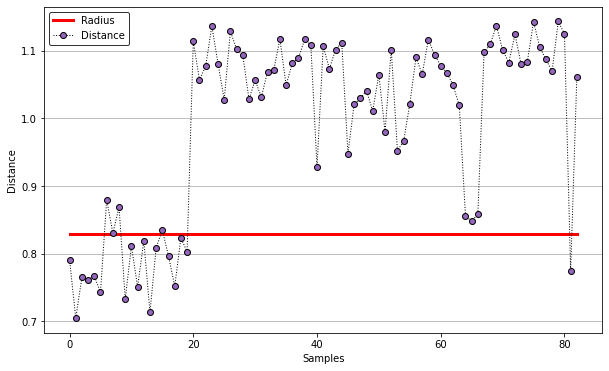

In [10]:
svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
svdd.fit(x_tr)
svdd.predict(x_tg, y_tg)
svdd.predict(x_te, y_te)
svdd.predict(x_ts, y_ts)
radius = svdd.radius
distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)
alphas = svdd.alpha
Param = svdd.C

m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :, :, :]))
  else:
    NSV.append(list(X_train[i, :, :, :]))

sv = np.array(SV)
nsv = np.array(NSV)

In [ ]:
model.fit(sv, sv,epochs=5,batch_size=8,shuffle=True,validation_data=(X_train, X_train))

encoder = models.clone_model(model)
encoder.compile(optimizer='adam',
                loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(7):
    encoder.pop()
X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
X_ts = encoder.predict(X_test,verbose=0)

# x_tr = X_tr
# x_ts = X_ts
x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.6318 - accuracy: 0.3406

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.0546 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9740
number of samples    = 220
number of features   = 90112
number of SVs        = 129
ratio of SVs         = 58.6364 %
accuracy             = 47.7273 %




*** Prediction of the provided data is completed. ***

running time         = 0.2712 seconds
number of samples    = 22
number of alarm      = 12
accuracy             = 45.4545 %




*** Prediction of the provided data is completed. ***

running time         = 1.0092 seconds
number of samples    = 93
number of alarm      = 88
accuracy             = 94.6237 %




*** Prediction of the provided data is completed. ***

running time         = 1.3681 seconds
number of samples    = 115
number of alarm      = 100
accuracy             = 85.2174 %




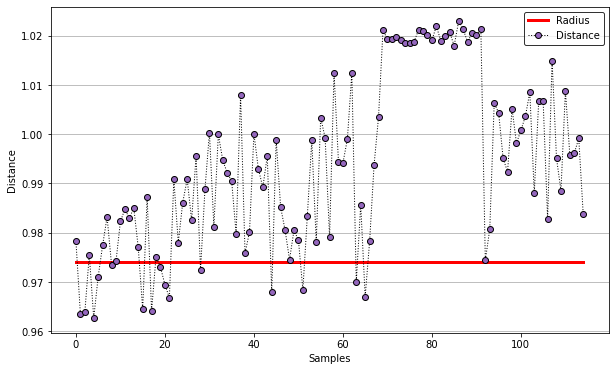

In [12]:
svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
svdd.fit(x_tr)
svdd.predict(x_tg, y_tg)
svdd.predict(x_te, y_te)
svdd.predict(x_ts, y_ts)
radius = svdd.radius
distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)

In [ ]:
acc = []

Epoch 1/3
3/3 [==============================] - 48s 17s/step - loss: 1.7737 - accuracy: 0.4001 - val_loss: 1.7746 - val_accuracy: 0.4062
Epoch 2/3
3/3 [==============================] - 37s 16s/step - loss: 1.7747 - accuracy: 0.4220 - val_loss: 1.7753 - val_accuracy: 0.4245
Epoch 3/3
3/3 [==============================] - 36s 15s/step - loss: 1.7786 - accuracy: 0.4372 - val_loss: 1.7772 - val_accuracy: 0.4399


*** Fitting of the SVDD model is completed. ***

running time         = 2.2006 seconds
kernel function      = rbf
iterations           = 13
radius               = 0.6919
number of samples    = 209
number of features   = 90112
number of SVs        = 21
ratio of SVs         = 10.0478 %
accuracy             = 97.6077 %




*** Prediction of the provided data is completed. ***

running time         = 0.2348 seconds
number of samples    = 20
number of alarm      = 1
accuracy             = 95.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7

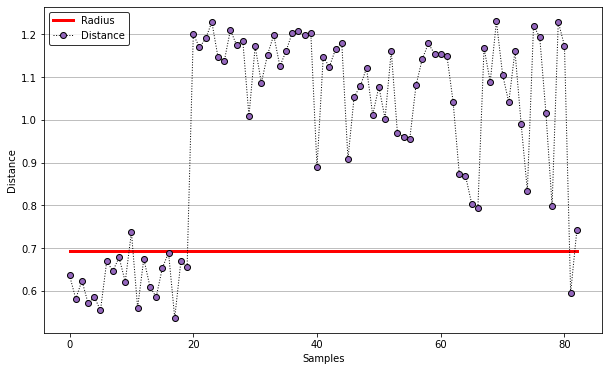

Epoch 1/2
3/3 [==============================] - 40s 17s/step - loss: 1.7938 - accuracy: 0.4481 - val_loss: 1.7822 - val_accuracy: 0.4527
Epoch 2/2
3/3 [==============================] - 41s 18s/step - loss: 1.8460 - accuracy: 0.4558 - val_loss: 1.7948 - val_accuracy: 0.4629


*** Fitting of the SVDD model is completed. ***

running time         = 2.9209 seconds
kernel function      = rbf
iterations           = 13
radius               = 0.7246
number of samples    = 209
number of features   = 90112
number of SVs        = 24
ratio of SVs         = 11.4833 %
accuracy             = 96.6507 %




*** Prediction of the provided data is completed. ***

running time         = 0.7661 seconds
number of samples    = 63
number of alarm      = 62
accuracy             = 98.4127 %




*** Prediction of the provided data is completed. ***

running time         = 0.3528 seconds
number of samples    = 20
number of alarm      = 1
accuracy             = 95.0000 %




*** Prediction of the provided data i

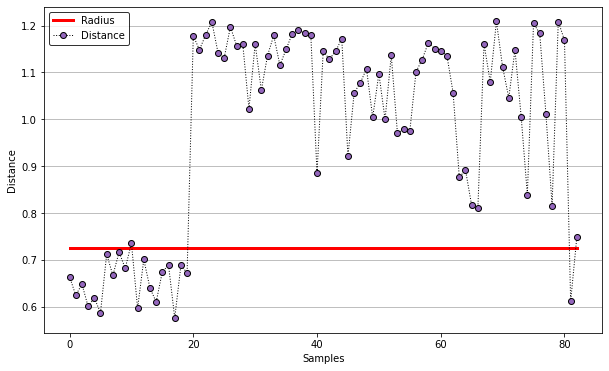

Epoch 1/3
3/3 [==============================] - 50s 17s/step - loss: 1.7759 - accuracy: 0.4172 - val_loss: 1.7737 - val_accuracy: 0.4115
Epoch 2/3
3/3 [==============================] - 35s 15s/step - loss: 1.7760 - accuracy: 0.4111 - val_loss: 1.7738 - val_accuracy: 0.4040
Epoch 3/3
3/3 [==============================] - 33s 14s/step - loss: 1.7767 - accuracy: 0.3992 - val_loss: 1.7740 - val_accuracy: 0.3971


*** Fitting of the SVDD model is completed. ***

running time         = 2.1714 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.7148
number of samples    = 209
number of features   = 90112
number of SVs        = 28
ratio of SVs         = 13.3971 %
accuracy             = 96.6507 %




*** Prediction of the provided data is completed. ***

running time         = 0.2454 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7

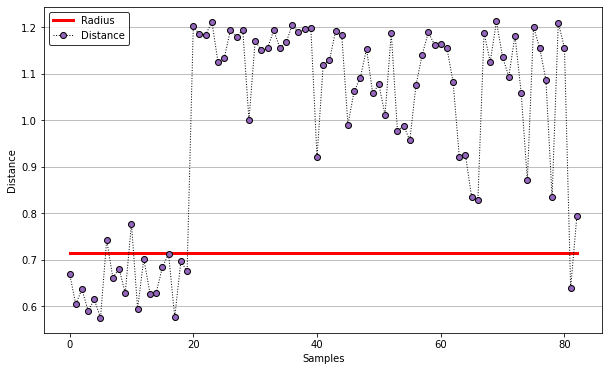

Epoch 1/2
4/4 [==============================] - 47s 14s/step - loss: 1.7751 - accuracy: 0.3838 - val_loss: 1.7756 - val_accuracy: 0.3855
Epoch 2/2
4/4 [==============================] - 42s 12s/step - loss: 1.7824 - accuracy: 0.3640 - val_loss: 1.7798 - val_accuracy: 0.3647


*** Fitting of the SVDD model is completed. ***

running time         = 2.3901 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.8014
number of samples    = 209
number of features   = 90112
number of SVs        = 29
ratio of SVs         = 13.8756 %
accuracy             = 96.1722 %




*** Prediction of the provided data is completed. ***

running time         = 0.6263 seconds
number of samples    = 63
number of alarm      = 62
accuracy             = 98.4127 %




*** Prediction of the provided data is completed. ***

running time         = 0.2737 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data i

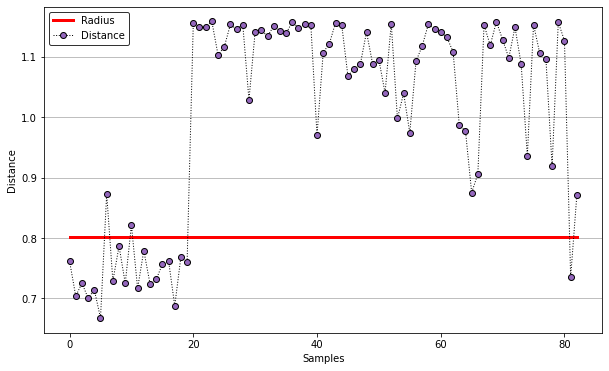

Epoch 1/3
3/3 [==============================] - 45s 16s/step - loss: 1.7725 - accuracy: 0.2469 - val_loss: 1.7748 - val_accuracy: 0.2864
Epoch 2/3
3/3 [==============================] - 35s 15s/step - loss: 1.7732 - accuracy: 0.3065 - val_loss: 1.7746 - val_accuracy: 0.3380
Epoch 3/3
3/3 [==============================] - 34s 15s/step - loss: 1.7752 - accuracy: 0.3713 - val_loss: 1.7749 - val_accuracy: 0.3844


*** Fitting of the SVDD model is completed. ***

running time         = 2.1089 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.7372
number of samples    = 209
number of features   = 90112
number of SVs        = 26
ratio of SVs         = 12.4402 %
accuracy             = 96.6507 %




*** Prediction of the provided data is completed. ***

running time         = 0.2636 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6

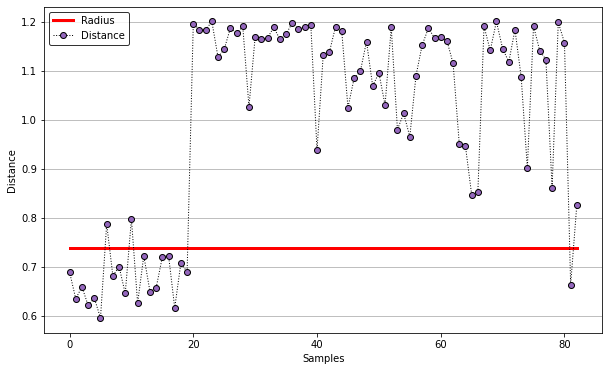

Epoch 1/2
4/4 [==============================] - 41s 12s/step - loss: 1.7855 - accuracy: 0.4276 - val_loss: 1.7765 - val_accuracy: 0.4335
Epoch 2/2
4/4 [==============================] - 42s 12s/step - loss: 1.8073 - accuracy: 0.4810 - val_loss: 1.7852 - val_accuracy: 0.4730


*** Fitting of the SVDD model is completed. ***

running time         = 2.1089 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.8405
number of samples    = 209
number of features   = 90112
number of SVs        = 26
ratio of SVs         = 12.4402 %
accuracy             = 96.6507 %




*** Prediction of the provided data is completed. ***

running time         = 0.7742 seconds
number of samples    = 63
number of alarm      = 62
accuracy             = 98.4127 %




*** Prediction of the provided data is completed. ***

running time         = 0.2517 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data i

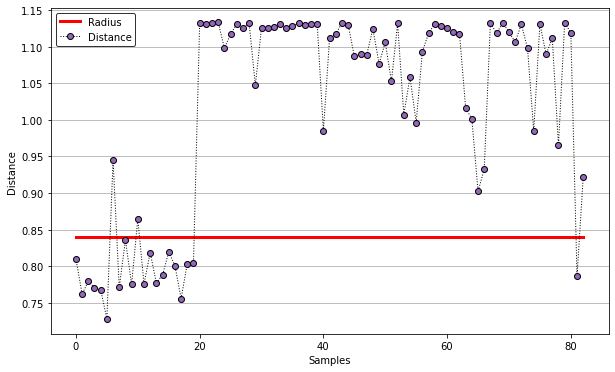

Epoch 1/3
3/3 [==============================] - 45s 15s/step - loss: 1.7753 - accuracy: 0.2558 - val_loss: 1.7745 - val_accuracy: 0.2736
Epoch 2/3
3/3 [==============================] - 33s 14s/step - loss: 1.7757 - accuracy: 0.2567 - val_loss: 1.7748 - val_accuracy: 0.2754
Epoch 3/3
3/3 [==============================] - 34s 15s/step - loss: 1.7789 - accuracy: 0.2536 - val_loss: 1.7757 - val_accuracy: 0.2735


*** Fitting of the SVDD model is completed. ***

running time         = 2.1245 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.6892
number of samples    = 209
number of features   = 90112
number of SVs        = 20
ratio of SVs         = 9.5694 %
accuracy             = 97.6077 %




*** Prediction of the provided data is completed. ***

running time         = 0.2320 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.70

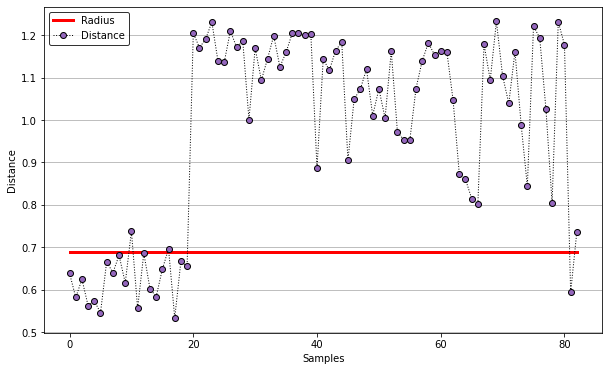

Epoch 1/2
3/3 [==============================] - 37s 16s/step - loss: 1.7861 - accuracy: 0.2547 - val_loss: 1.7780 - val_accuracy: 0.2697
Epoch 2/2
3/3 [==============================] - 36s 16s/step - loss: 1.8235 - accuracy: 0.2555 - val_loss: 1.7837 - val_accuracy: 0.2659


*** Fitting of the SVDD model is completed. ***

running time         = 1.9995 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.7200
number of samples    = 209
number of features   = 90112
number of SVs        = 25
ratio of SVs         = 11.9617 %
accuracy             = 97.1292 %




*** Prediction of the provided data is completed. ***

running time         = 0.7022 seconds
number of samples    = 63
number of alarm      = 62
accuracy             = 98.4127 %




*** Prediction of the provided data is completed. ***

running time         = 0.2373 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data i

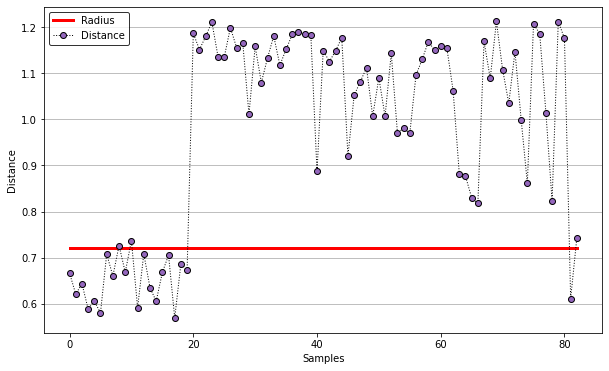

Epoch 1/3
3/3 [==============================] - 45s 15s/step - loss: 1.7775 - accuracy: 0.2468 - val_loss: 1.7744 - val_accuracy: 0.2649
Epoch 2/3
3/3 [==============================] - 33s 14s/step - loss: 1.7775 - accuracy: 0.2684 - val_loss: 1.7745 - val_accuracy: 0.2824
Epoch 3/3
3/3 [==============================] - 32s 14s/step - loss: 1.7787 - accuracy: 0.2832 - val_loss: 1.7751 - val_accuracy: 0.2993


*** Fitting of the SVDD model is completed. ***

running time         = 2.0777 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.6851
number of samples    = 209
number of features   = 90112
number of SVs        = 22
ratio of SVs         = 10.5263 %
accuracy             = 97.6077 %




*** Prediction of the provided data is completed. ***

running time         = 0.2799 seconds
number of samples    = 20
number of alarm      = 1
accuracy             = 95.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7

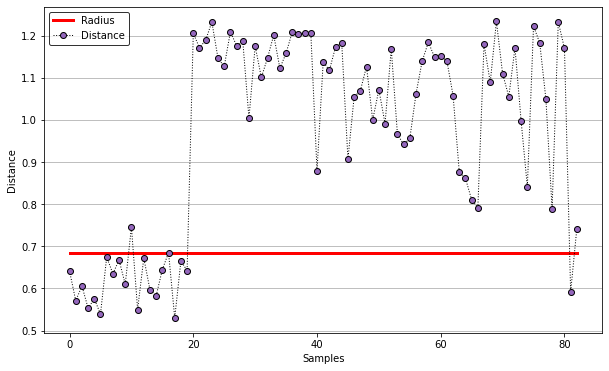

Epoch 1/2
3/3 [==============================] - 38s 17s/step - loss: 1.7783 - accuracy: 0.2936 - val_loss: 1.7770 - val_accuracy: 0.3165
Epoch 2/2
3/3 [==============================] - 38s 16s/step - loss: 1.7928 - accuracy: 0.3067 - val_loss: 1.7808 - val_accuracy: 0.3337


*** Fitting of the SVDD model is completed. ***

running time         = 2.1401 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.7155
number of samples    = 209
number of features   = 90112
number of SVs        = 24
ratio of SVs         = 11.4833 %
accuracy             = 97.1292 %




*** Prediction of the provided data is completed. ***

running time         = 0.7204 seconds
number of samples    = 63
number of alarm      = 62
accuracy             = 98.4127 %




*** Prediction of the provided data is completed. ***

running time         = 0.2340 seconds
number of samples    = 20
number of alarm      = 2
accuracy             = 90.0000 %




*** Prediction of the provided data i

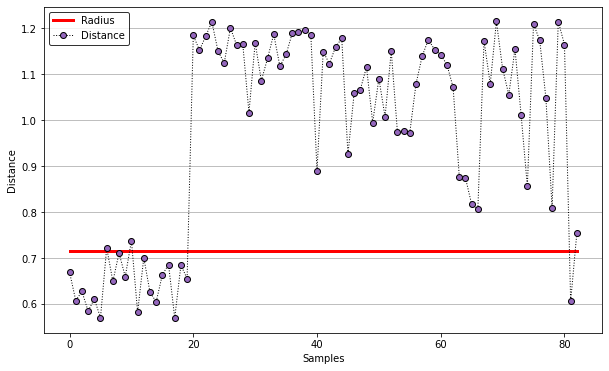

Wall time: 23min 29s


In [2]:
%%time
for num in range(5):
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
3/3 [==============================] - 48s 17s/step - loss: 1.3384 - accuracy: 0.4318 - val_loss: 1.3246 - val_accuracy: 0.4622
Epoch 2/3
3/3 [==============================] - 39s 17s/step - loss: 1.3376 - accuracy: 0.4925 - val_loss: 1.3240 - val_accuracy: 0.5182
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 1.3408 - accuracy: 0.5425 - val_loss: 1.3240 - val_accuracy: 0.5621


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3132 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9674
number of samples    = 224
number of features   = 90112
number of SVs        = 130
ratio of SVs         = 58.0357 %
accuracy             = 91.9643 %




*** Prediction of the provided data is completed. ***

running time         = 0.7771 seconds
number of samples    = 58
number of alarm      = 21
accuracy             = 63.7931 %




*** Prediction of the provided data is completed. ***

running time         = 0.9227 seconds
number of samples    = 82
number of alarm      = 79
accuracy             = 96.3415 %




*** Prediction of the provided data is completed. ***

running time         = 1.3405 seconds
number of samples    = 140
number of alarm      = 100
accuracy             = 82.8571 %




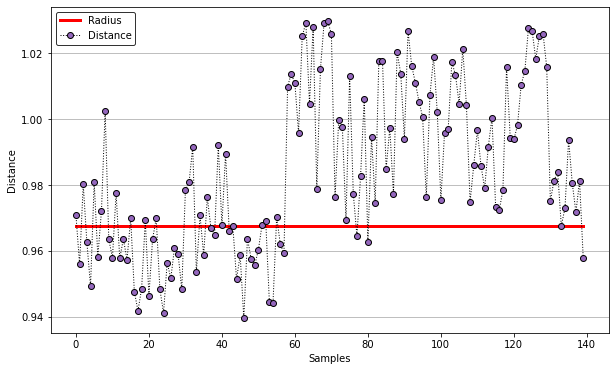

Epoch 1/2
17/17 [==============================] - 103s 6s/step - loss: 1.4968 - accuracy: 0.5713 - val_loss: 1.4720 - val_accuracy: 0.4874
Epoch 2/2
17/17 [==============================] - 100s 6s/step - loss: 3.2510 - accuracy: 0.4233 - val_loss: 4.9407 - val_accuracy: 0.4249


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3287 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9961
number of samples    = 224
number of features   = 90112
number of SVs        = 223
ratio of SVs         = 99.5536 %
accuracy             = 3.5714 %




*** Prediction of the provided data is completed. ***

running time         = 0.9310 seconds
number of samples    = 82
number of alarm      = 82
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6341 seconds
number of samples    = 58
number of alarm      = 58
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.4464 seconds
number of samples    = 140
number of alarm      = 140
accuracy             = 58.5714 %




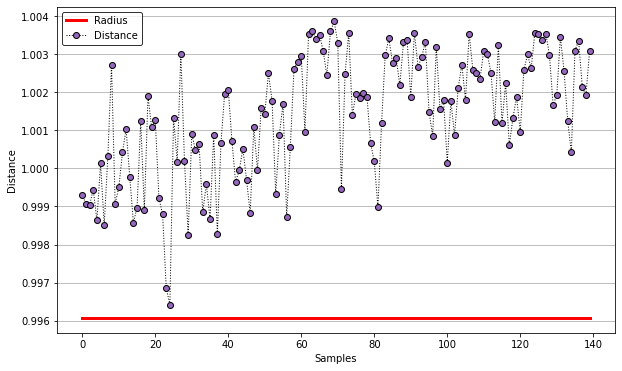

Epoch 1/3
3/3 [==============================] - 49s 17s/step - loss: 1.3186 - accuracy: 0.4931 - val_loss: 1.3287 - val_accuracy: 0.5465
Epoch 2/3
3/3 [==============================] - 38s 16s/step - loss: 1.3175 - accuracy: 0.5646 - val_loss: 1.3281 - val_accuracy: 0.6067
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 1.3176 - accuracy: 0.6170 - val_loss: 1.3280 - val_accuracy: 0.6509


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2495 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9666
number of samples    = 224
number of features   = 90112
number of SVs        = 131
ratio of SVs         = 58.4821 %
accuracy             = 91.9643 %




*** Prediction of the provided data is completed. ***

running time         = 0.6405 seconds
number of samples    = 58
number of alarm      = 20
accuracy             = 65.5172 %




*** Prediction of the provided data is completed. ***

running time         = 0.8904 seconds
number of samples    = 82
number of alarm      = 79
accuracy             = 96.3415 %




*** Prediction of the provided data is completed. ***

running time         = 1.4216 seconds
number of samples    = 140
number of alarm      = 99
accuracy             = 83.5714 %




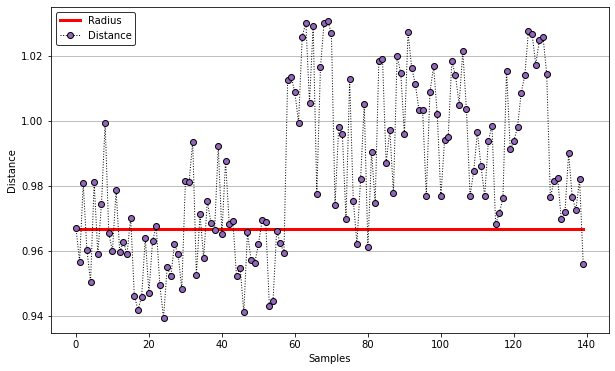

Epoch 1/2
17/17 [==============================] - 107s 6s/step - loss: 1.3880 - accuracy: 0.6593 - val_loss: 1.3828 - val_accuracy: 0.5878
Epoch 2/2
17/17 [==============================] - 99s 6s/step - loss: 2.2654 - accuracy: 0.4658 - val_loss: 3.2699 - val_accuracy: 0.4330


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1558 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9953
number of samples    = 224
number of features   = 90112
number of SVs        = 221
ratio of SVs         = 98.6607 %
accuracy             = 4.4643 %




*** Prediction of the provided data is completed. ***

running time         = 0.9217 seconds
number of samples    = 82
number of alarm      = 82
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6092 seconds
number of samples    = 58
number of alarm      = 57
accuracy             = 1.7241 %




*** Prediction of the provided data is completed. ***

running time         = 1.4059 seconds
number of samples    = 140
number of alarm      = 139
accuracy             = 59.2857 %




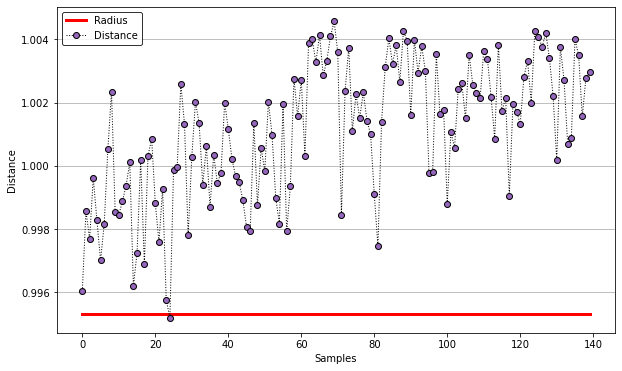

Epoch 1/3
3/3 [==============================] - 48s 17s/step - loss: 1.3073 - accuracy: 0.4831 - val_loss: 1.3288 - val_accuracy: 0.5635
Epoch 2/3
3/3 [==============================] - 38s 17s/step - loss: 1.3060 - accuracy: 0.5914 - val_loss: 1.3280 - val_accuracy: 0.6455
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 1.3060 - accuracy: 0.6665 - val_loss: 1.3277 - val_accuracy: 0.7041


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1089 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9696
number of samples    = 224
number of features   = 90112
number of SVs        = 122
ratio of SVs         = 54.4643 %
accuracy             = 92.4107 %




*** Prediction of the provided data is completed. ***

running time         = 0.6873 seconds
number of samples    = 58
number of alarm      = 21
accuracy             = 63.7931 %




*** Prediction of the provided data is completed. ***

running time         = 0.8805 seconds
number of samples    = 82
number of alarm      = 79
accuracy             = 96.3415 %




*** Prediction of the provided data is completed. ***

running time         = 1.4230 seconds
number of samples    = 140
number of alarm      = 100
accuracy             = 82.8571 %




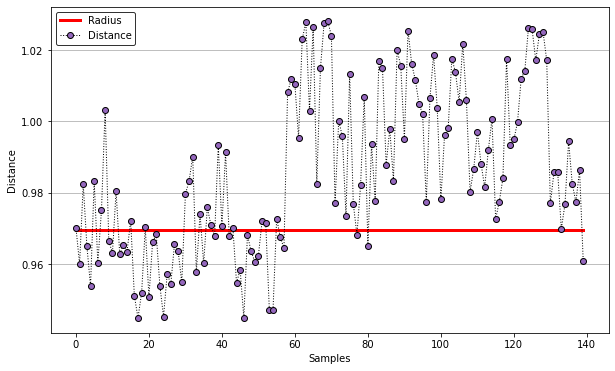

Epoch 1/2
16/16 [==============================] - 97s 6s/step - loss: 1.4152 - accuracy: 0.7465 - val_loss: 1.3906 - val_accuracy: 0.6826
Epoch 2/2
16/16 [==============================] - 96s 6s/step - loss: 2.0572 - accuracy: 0.5049 - val_loss: 3.2212 - val_accuracy: 0.4752


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.0933 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9959
number of samples    = 224
number of features   = 90112
number of SVs        = 224
ratio of SVs         = 100.0000 %
accuracy             = 1.7857 %




*** Prediction of the provided data is completed. ***

running time         = 0.9373 seconds
number of samples    = 82
number of alarm      = 82
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7498 seconds
number of samples    = 58
number of alarm      = 58
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.2966 seconds
number of samples    = 140
number of alarm      = 140
accuracy             = 58.5714 %




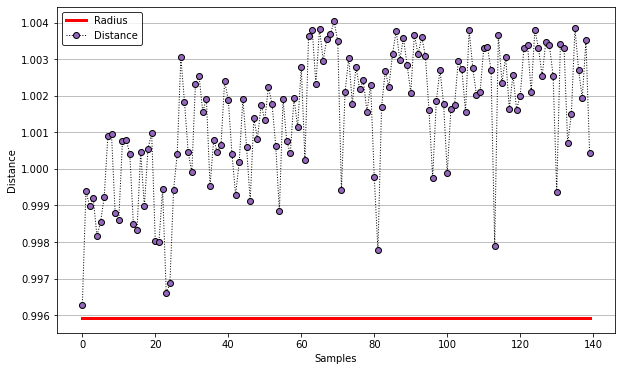

Epoch 1/3
3/3 [==============================] - 48s 17s/step - loss: 1.3169 - accuracy: 0.2991 - val_loss: 1.3294 - val_accuracy: 0.3465
Epoch 2/3
3/3 [==============================] - 48s 21s/step - loss: 1.3160 - accuracy: 0.3552 - val_loss: 1.3287 - val_accuracy: 0.3904
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 1.3164 - accuracy: 0.3947 - val_loss: 1.3283 - val_accuracy: 0.4217


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3459 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9690
number of samples    = 224
number of features   = 90112
number of SVs        = 132
ratio of SVs         = 58.9286 %
accuracy             = 92.4107 %




*** Prediction of the provided data is completed. ***

running time         = 0.6619 seconds
number of samples    = 58
number of alarm      = 22
accuracy             = 62.0690 %




*** Prediction of the provided data is completed. ***

running time         = 0.9174 seconds
number of samples    = 82
number of alarm      = 79
accuracy             = 96.3415 %




*** Prediction of the provided data is completed. ***

running time         = 1.4019 seconds
number of samples    = 140
number of alarm      = 101
accuracy             = 82.1429 %




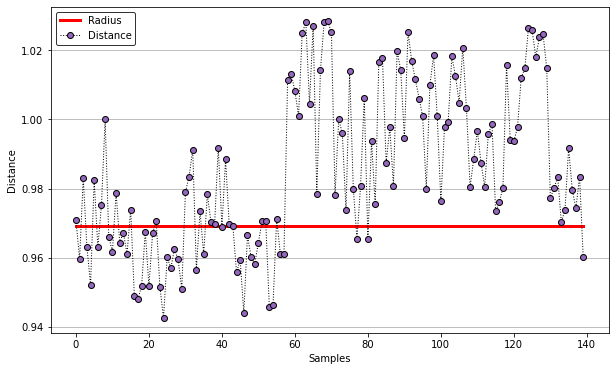

Epoch 1/2
17/17 [==============================] - 108s 6s/step - loss: 1.4139 - accuracy: 0.4602 - val_loss: 1.4255 - val_accuracy: 0.4889
Epoch 2/2
17/17 [==============================] - 100s 6s/step - loss: 2.6264 - accuracy: 0.4783 - val_loss: 4.1845 - val_accuracy: 0.4414


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2835 seconds
kernel function      = rbf
iterations           = 4
radius               = 0.9966
number of samples    = 224
number of features   = 90112
number of SVs        = 224
ratio of SVs         = 100.0000 %
accuracy             = 11.6071 %




*** Prediction of the provided data is completed. ***

running time         = 0.9424 seconds
number of samples    = 82
number of alarm      = 82
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6697 seconds
number of samples    = 58
number of alarm      = 58
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.3702 seconds
number of samples    = 140
number of alarm      = 140
accuracy             = 58.5714 %




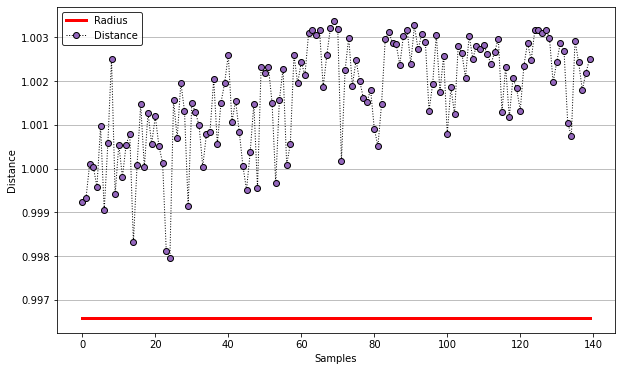

Epoch 1/3
3/3 [==============================] - 51s 18s/step - loss: 1.3226 - accuracy: 0.7693 - val_loss: 1.3256 - val_accuracy: 0.7821
Epoch 2/3
3/3 [==============================] - 38s 17s/step - loss: 1.3214 - accuracy: 0.7836 - val_loss: 1.3249 - val_accuracy: 0.7938
Epoch 3/3
3/3 [==============================] - 38s 16s/step - loss: 1.3208 - accuracy: 0.7936 - val_loss: 1.3242 - val_accuracy: 0.8006


*** Fitting of the SVDD model is completed. ***

running time         = 2.1870 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9606
number of samples    = 224
number of features   = 90112
number of SVs        = 112
ratio of SVs         = 50.0000 %
accuracy             = 91.0714 %




*** Prediction of the provided data is completed. ***

running time         = 0.7548 seconds
number of samples    = 58
number of alarm      = 15
accuracy             = 74.1379 %




*** Prediction of the provided data is completed. ***

running time         = 0.

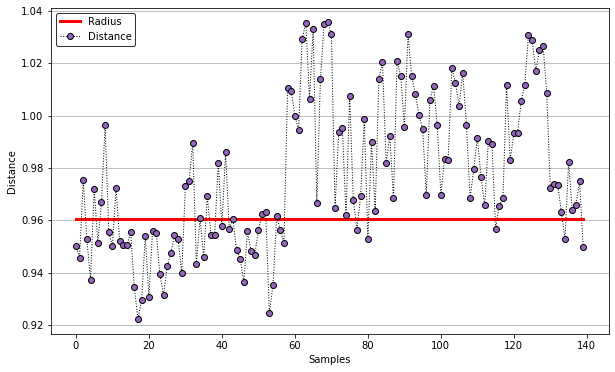

Epoch 1/2
14/14 [==============================] - 100s 7s/step - loss: 1.3160 - accuracy: 0.8042 - val_loss: 1.3182 - val_accuracy: 0.8036
Epoch 2/2
14/14 [==============================] - 91s 7s/step - loss: 1.3446 - accuracy: 0.7522 - val_loss: 1.3465 - val_accuracy: 0.6280


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2244 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9843
number of samples    = 224
number of features   = 90112
number of SVs        = 156
ratio of SVs         = 69.6429 %
accuracy             = 95.5357 %




*** Prediction of the provided data is completed. ***

running time         = 0.9359 seconds
number of samples    = 82
number of alarm      = 78
accuracy             = 95.1220 %




*** Prediction of the provided data is completed. ***

running time         = 0.6375 seconds
number of samples    = 58
number of alarm      = 34
accuracy             = 41.3793 %




*** Prediction of the provided data is completed. ***

running time         = 1.4463 seconds
number of samples    = 140
number of alarm      = 112
accuracy             = 72.8571 %




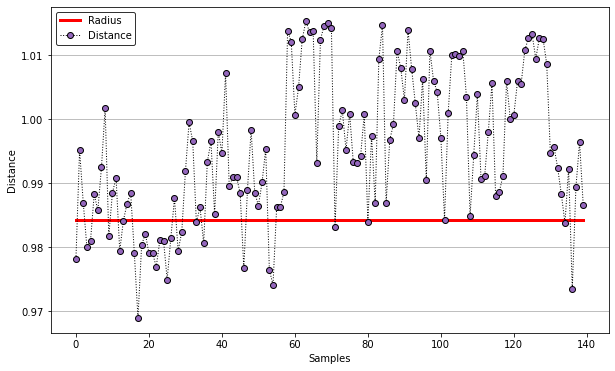

Wall time: 36min 59s


In [3]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-6), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
3/3 [==============================] - 49s 17s/step - loss: 2.2216 - accuracy: 0.2254 - val_loss: 2.2187 - val_accuracy: 0.2408
Epoch 2/3
3/3 [==============================] - 37s 16s/step - loss: 2.2238 - accuracy: 0.2221 - val_loss: 2.2210 - val_accuracy: 0.2419
Epoch 3/3
3/3 [==============================] - 36s 16s/step - loss: 2.2381 - accuracy: 0.2226 - val_loss: 2.2273 - val_accuracy: 0.2444


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2675 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9928
number of samples    = 219
number of features   = 90112
number of SVs        = 173
ratio of SVs         = 78.9954 %
accuracy             = 23.7443 %




*** Prediction of the provided data is completed. ***

running time         = 0.2627 seconds
number of samples    = 23
number of alarm      = 17
accuracy             = 26.0870 %




*** Prediction of the provided data is completed. ***

running time         = 1.1115 seconds
number of samples    = 109
number of alarm      = 105
accuracy             = 96.3303 %




*** Prediction of the provided data is completed. ***

running time         = 1.3667 seconds
number of samples    = 132
number of alarm      = 122
accuracy             = 84.0909 %




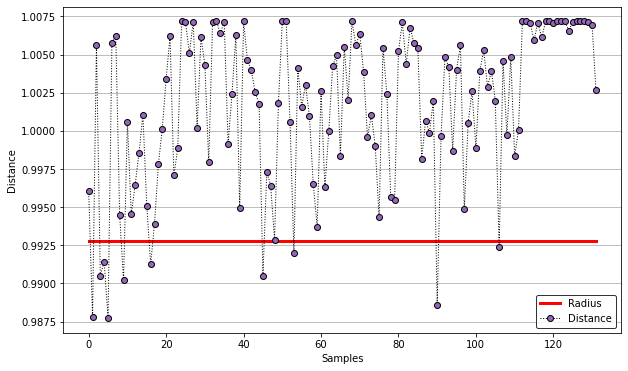

Epoch 1/2
22/22 [==============================] - 130s 6s/step - loss: 4.3892 - accuracy: 0.2376 - val_loss: 3.0221 - val_accuracy: 0.2276
Epoch 2/2
22/22 [==============================] - 125s 6s/step - loss: 31.9335 - accuracy: 0.2388 - val_loss: 9.0097 - val_accuracy: 0.2319


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1955 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9876
number of samples    = 219
number of features   = 90112
number of SVs        = 137
ratio of SVs         = 62.5571 %
accuracy             = 92.6941 %




*** Prediction of the provided data is completed. ***

running time         = 1.2641 seconds
number of samples    = 109
number of alarm      = 90
accuracy             = 82.5688 %




*** Prediction of the provided data is completed. ***

running time         = 0.2637 seconds
number of samples    = 23
number of alarm      = 16
accuracy             = 30.4348 %




*** Prediction of the provided data is completed. ***

running time         = 1.2815 seconds
number of samples    = 132
number of alarm      = 106
accuracy             = 73.4848 %




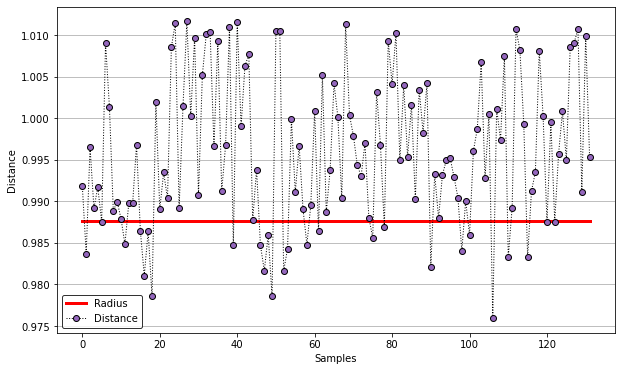

Epoch 1/3
3/3 [==============================] - 49s 17s/step - loss: 2.2136 - accuracy: 0.2505 - val_loss: 2.2185 - val_accuracy: 0.2507
Epoch 2/3
3/3 [==============================] - 37s 16s/step - loss: 2.2127 - accuracy: 0.2467 - val_loss: 2.2189 - val_accuracy: 0.2497
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 2.2135 - accuracy: 0.2434 - val_loss: 2.2206 - val_accuracy: 0.2479


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3690 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9933
number of samples    = 219
number of features   = 90112
number of SVs        = 199
ratio of SVs         = 90.8676 %
accuracy             = 19.1781 %




*** Prediction of the provided data is completed. ***

running time         = 0.2566 seconds
number of samples    = 23
number of alarm      = 17
accuracy             = 26.0870 %




*** Prediction of the provided data is completed. ***

running time         = 1.1263 seconds
number of samples    = 109
number of alarm      = 106
accuracy             = 97.2477 %




*** Prediction of the provided data is completed. ***

running time         = 1.2741 seconds
number of samples    = 132
number of alarm      = 123
accuracy             = 84.8485 %




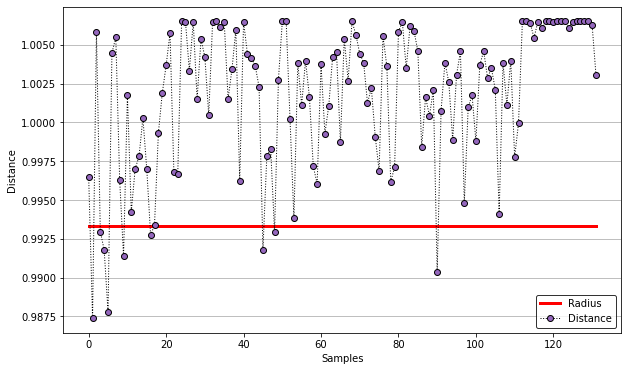

Epoch 1/2
25/25 [==============================] - 143s 6s/step - loss: 2.6792 - accuracy: 0.2374 - val_loss: 3.2688 - val_accuracy: 0.2408
Epoch 2/2
25/25 [==============================] - 144s 6s/step - loss: 10.6543 - accuracy: 0.2494 - val_loss: 13.2563 - val_accuracy: 0.2435


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2758 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9961
number of samples    = 219
number of features   = 90112
number of SVs        = 219
ratio of SVs         = 100.0000 %
accuracy             = 3.1963 %




*** Prediction of the provided data is completed. ***

running time         = 1.1077 seconds
number of samples    = 109
number of alarm      = 109
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.3367 seconds
number of samples    = 23
number of alarm      = 22
accuracy             = 4.3478 %




*** Prediction of the provided data is completed. ***

running time         = 1.2553 seconds
number of samples    = 132
number of alarm      = 131
accuracy             = 83.3333 %




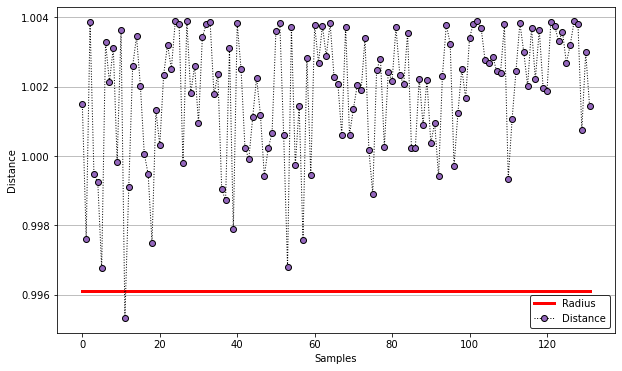

Epoch 1/3
3/3 [==============================] - 52s 18s/step - loss: 2.2397 - accuracy: 0.2833 - val_loss: 2.2149 - val_accuracy: 0.2841
Epoch 2/3
3/3 [==============================] - 35s 15s/step - loss: 2.2394 - accuracy: 0.2786 - val_loss: 2.2153 - val_accuracy: 0.2821
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 2.2405 - accuracy: 0.2728 - val_loss: 2.2167 - val_accuracy: 0.2774


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3160 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9935
number of samples    = 219
number of features   = 90112
number of SVs        = 196
ratio of SVs         = 89.4977 %
accuracy             = 20.5479 %




*** Prediction of the provided data is completed. ***

running time         = 0.2548 seconds
number of samples    = 23
number of alarm      = 16
accuracy             = 30.4348 %




*** Prediction of the provided data is completed. ***

running time         = 1.1251 seconds
number of samples    = 109
number of alarm      = 107
accuracy             = 98.1651 %




*** Prediction of the provided data is completed. ***

running time         = 1.3533 seconds
number of samples    = 132
number of alarm      = 123
accuracy             = 86.3636 %




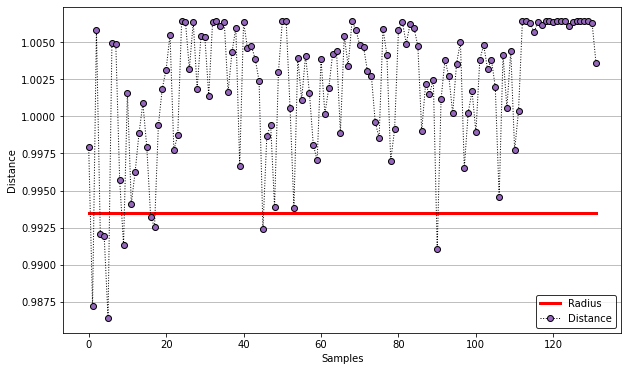

Epoch 1/2
25/25 [==============================] - 141s 6s/step - loss: 2.5420 - accuracy: 0.2590 - val_loss: 2.9241 - val_accuracy: 0.2401
Epoch 2/2
25/25 [==============================] - 138s 6s/step - loss: 9.6076 - accuracy: 0.2497 - val_loss: 13.5732 - val_accuracy: 0.2620


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2986 seconds
kernel function      = rbf
iterations           = 4
radius               = 0.9975
number of samples    = 219
number of features   = 90112
number of SVs        = 219
ratio of SVs         = 100.0000 %
accuracy             = 9.1324 %




*** Prediction of the provided data is completed. ***

running time         = 1.1454 seconds
number of samples    = 109
number of alarm      = 109
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2468 seconds
number of samples    = 23
number of alarm      = 23
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.2786 seconds
number of samples    = 132
number of alarm      = 132
accuracy             = 82.5758 %




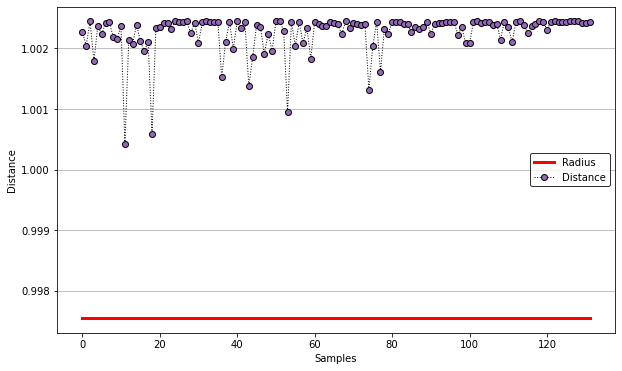

Epoch 1/3
3/3 [==============================] - 49s 17s/step - loss: 2.2150 - accuracy: 0.2471 - val_loss: 2.2219 - val_accuracy: 0.2560
Epoch 2/3
3/3 [==============================] - 38s 17s/step - loss: 2.2194 - accuracy: 0.2501 - val_loss: 2.2263 - val_accuracy: 0.2589
Epoch 3/3
3/3 [==============================] - 37s 16s/step - loss: 2.2442 - accuracy: 0.2543 - val_loss: 2.2371 - val_accuracy: 0.2606


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2878 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9930
number of samples    = 219
number of features   = 90112
number of SVs        = 192
ratio of SVs         = 87.6712 %
accuracy             = 21.9178 %




*** Prediction of the provided data is completed. ***

running time         = 0.2507 seconds
number of samples    = 23
number of alarm      = 17
accuracy             = 26.0870 %




*** Prediction of the provided data is completed. ***

running time         = 1.0636 seconds
number of samples    = 109
number of alarm      = 105
accuracy             = 96.3303 %




*** Prediction of the provided data is completed. ***

running time         = 1.3947 seconds
number of samples    = 132
number of alarm      = 122
accuracy             = 84.0909 %




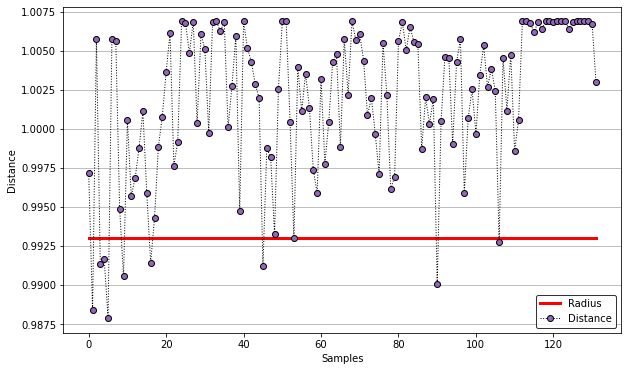

Epoch 1/2
24/24 [==============================] - 141s 6s/step - loss: 4.8536 - accuracy: 0.2809 - val_loss: 2.8544 - val_accuracy: 0.3323
Epoch 2/2
24/24 [==============================] - 138s 6s/step - loss: 24.8663 - accuracy: 0.3565 - val_loss: 6.2744 - val_accuracy: 0.3535


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.7667 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9847
number of samples    = 219
number of features   = 90112
number of SVs        = 124
ratio of SVs         = 56.6210 %
accuracy             = 89.0411 %




*** Prediction of the provided data is completed. ***

running time         = 1.0507 seconds
number of samples    = 109
number of alarm      = 79
accuracy             = 72.4771 %




*** Prediction of the provided data is completed. ***

running time         = 0.2487 seconds
number of samples    = 23
number of alarm      = 12
accuracy             = 47.8261 %




*** Prediction of the provided data is completed. ***

running time         = 1.1458 seconds
number of samples    = 132
number of alarm      = 91
accuracy             = 68.1818 %




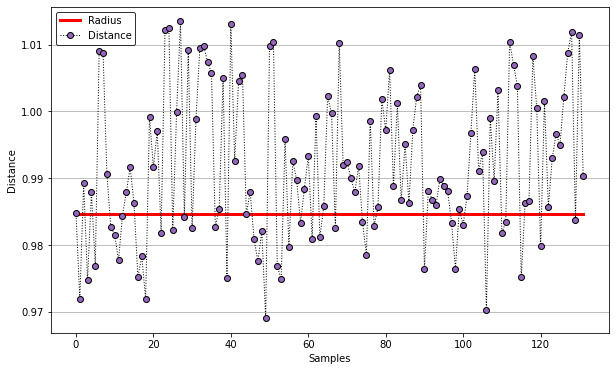

Epoch 1/3
3/3 [==============================] - 49s 17s/step - loss: 2.2042 - accuracy: 0.3826 - val_loss: 2.2165 - val_accuracy: 0.3857
Epoch 2/3
3/3 [==============================] - 38s 16s/step - loss: 2.2039 - accuracy: 0.3858 - val_loss: 2.2164 - val_accuracy: 0.3881
Epoch 3/3
3/3 [==============================] - 41s 17s/step - loss: 2.2043 - accuracy: 0.3924 - val_loss: 2.2168 - val_accuracy: 0.3911


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2705 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9932
number of samples    = 219
number of features   = 90112
number of SVs        = 197
ratio of SVs         = 89.9543 %
accuracy             = 21.0046 %




*** Prediction of the provided data is completed. ***

running time         = 0.2651 seconds
number of samples    = 23
number of alarm      = 17
accuracy             = 26.0870 %




*** Prediction of the provided data is completed. ***

running time         = 1.1270 seconds
number of samples    = 109
number of alarm      = 107
accuracy             = 98.1651 %




*** Prediction of the provided data is completed. ***

running time         = 1.3678 seconds
number of samples    = 132
number of alarm      = 124
accuracy             = 85.6061 %




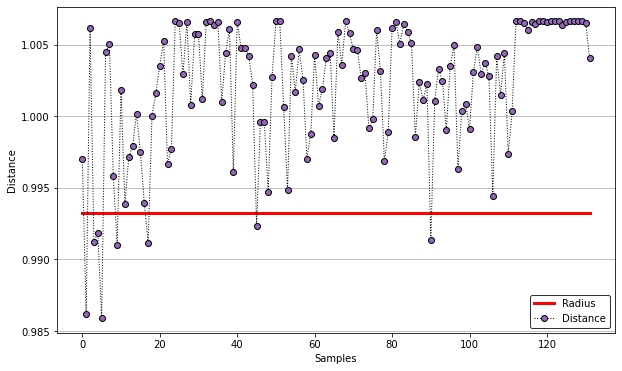

Epoch 1/2
25/25 [==============================] - 143s 6s/step - loss: 2.5018 - accuracy: 0.4053 - val_loss: 2.4178 - val_accuracy: 0.3899
Epoch 2/2
25/25 [==============================] - 138s 6s/step - loss: 8.2385 - accuracy: 0.3898 - val_loss: 5.2755 - val_accuracy: 0.3894


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2465 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9944
number of samples    = 219
number of features   = 90112
number of SVs        = 204
ratio of SVs         = 93.1507 %
accuracy             = 15.0685 %




*** Prediction of the provided data is completed. ***

running time         = 1.1397 seconds
number of samples    = 109
number of alarm      = 108
accuracy             = 99.0826 %




*** Prediction of the provided data is completed. ***

running time         = 0.3378 seconds
number of samples    = 23
number of alarm      = 21
accuracy             = 8.6957 %




*** Prediction of the provided data is completed. ***

running time         = 1.2853 seconds
number of samples    = 132
number of alarm      = 129
accuracy             = 83.3333 %




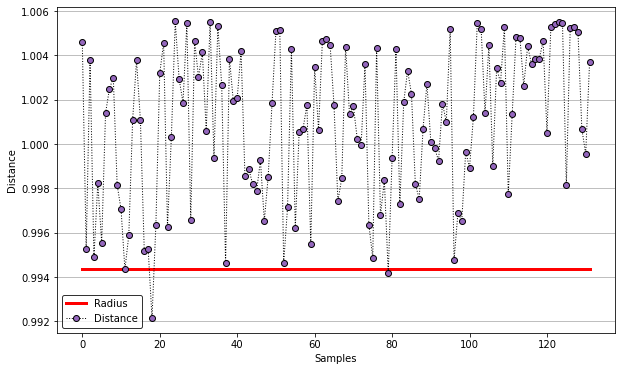

Wall time: 42min 42s


In [4]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-3), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-6), gamma=10**(-3), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
4/4 [==============================] - 61s 15s/step - loss: 1.1736 - accuracy: 0.3488 - val_loss: 1.1768 - val_accuracy: 0.3747
Epoch 2/3
4/4 [==============================] - 50s 15s/step - loss: 1.1734 - accuracy: 0.3854 - val_loss: 1.1768 - val_accuracy: 0.4011
Epoch 3/3
4/4 [==============================] - 49s 15s/step - loss: 1.1735 - accuracy: 0.4151 - val_loss: 1.1772 - val_accuracy: 0.4217


*** Fitting of the SVDD model is completed. ***

running time         = 2.7338 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.4229
number of samples    = 280
number of features   = 90112
number of SVs        = 134
ratio of SVs         = 47.8571 %
accuracy             = 80.3571 %




*** Prediction of the provided data is completed. ***

running time         = 0.3963 seconds
number of samples    = 28
number of alarm      = 14
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.

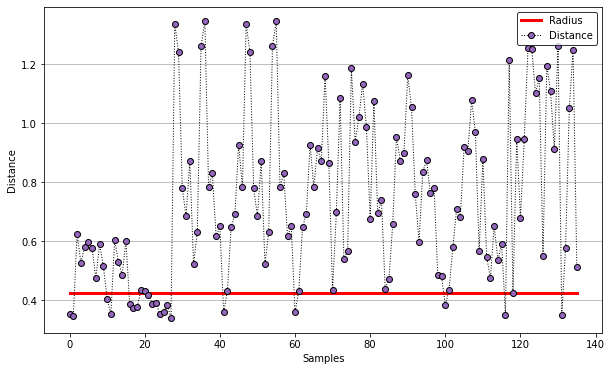

Epoch 1/2
17/17 [==============================] - 118s 7s/step - loss: 1.1848 - accuracy: 0.4358 - val_loss: 1.1919 - val_accuracy: 0.3690
Epoch 2/2
17/17 [==============================] - 113s 7s/step - loss: 1.2963 - accuracy: 0.3448 - val_loss: 1.2601 - val_accuracy: 0.3322


*** Fitting of the SVDD model is completed. ***

running time         = 2.9056 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.4534
number of samples    = 280
number of features   = 90112
number of SVs        = 133
ratio of SVs         = 47.5000 %
accuracy             = 84.2857 %




*** Prediction of the provided data is completed. ***

running time         = 1.1504 seconds
number of samples    = 108
number of alarm      = 101
accuracy             = 93.5185 %




*** Prediction of the provided data is completed. ***

running time         = 0.4508 seconds
number of samples    = 28
number of alarm      = 12
accuracy             = 57.1429 %




*** Prediction of the provided

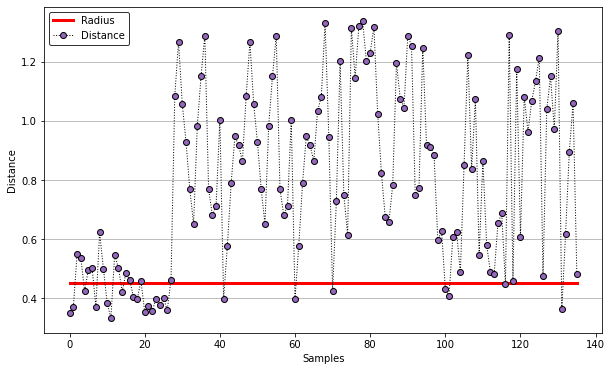

Epoch 1/3
4/4 [==============================] - 65s 16s/step - loss: 1.1826 - accuracy: 0.2389 - val_loss: 1.1768 - val_accuracy: 0.2292
Epoch 2/3
4/4 [==============================] - 51s 15s/step - loss: 1.1815 - accuracy: 0.2339 - val_loss: 1.1767 - val_accuracy: 0.2288
Epoch 3/3
4/4 [==============================] - 51s 15s/step - loss: 1.1813 - accuracy: 0.2322 - val_loss: 1.1767 - val_accuracy: 0.2308


*** Fitting of the SVDD model is completed. ***

running time         = 2.7806 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.4243
number of samples    = 280
number of features   = 90112
number of SVs        = 130
ratio of SVs         = 46.4286 %
accuracy             = 81.0714 %




*** Prediction of the provided data is completed. ***

running time         = 0.4210 seconds
number of samples    = 28
number of alarm      = 14
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1

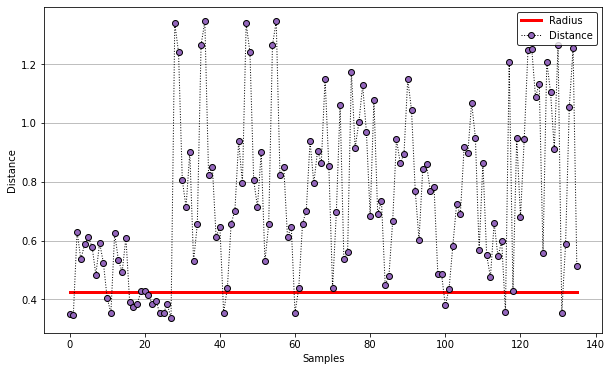

Epoch 1/2
17/17 [==============================] - 117s 7s/step - loss: 1.1827 - accuracy: 0.2410 - val_loss: 1.1851 - val_accuracy: 0.2809
Epoch 2/2
17/17 [==============================] - 113s 7s/step - loss: 1.2697 - accuracy: 0.3207 - val_loss: 1.2487 - val_accuracy: 0.3381


*** Fitting of the SVDD model is completed. ***

running time         = 3.0405 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.4552
number of samples    = 280
number of features   = 90112
number of SVs        = 132
ratio of SVs         = 47.1429 %
accuracy             = 84.6429 %




*** Prediction of the provided data is completed. ***

running time         = 1.2040 seconds
number of samples    = 108
number of alarm      = 101
accuracy             = 93.5185 %




*** Prediction of the provided data is completed. ***

running time         = 0.4049 seconds
number of samples    = 28
number of alarm      = 9
accuracy             = 67.8571 %




*** Prediction of the provided

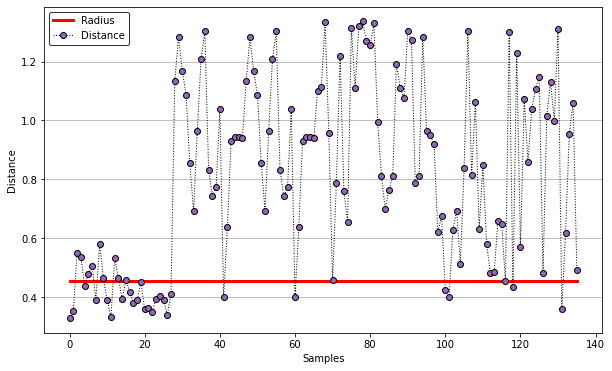

Epoch 1/3
4/4 [==============================] - 65s 17s/step - loss: 1.1732 - accuracy: 0.3278 - val_loss: 1.1769 - val_accuracy: 0.3377
Epoch 2/3
4/4 [==============================] - 51s 15s/step - loss: 1.1729 - accuracy: 0.3442 - val_loss: 1.1769 - val_accuracy: 0.3533
Epoch 3/3
4/4 [==============================] - 52s 16s/step - loss: 1.1729 - accuracy: 0.3643 - val_loss: 1.1772 - val_accuracy: 0.3698


*** Fitting of the SVDD model is completed. ***

running time         = 2.8382 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.4220
number of samples    = 280
number of features   = 90112
number of SVs        = 131
ratio of SVs         = 46.7857 %
accuracy             = 79.6429 %




*** Prediction of the provided data is completed. ***

running time         = 0.4087 seconds
number of samples    = 28
number of alarm      = 14
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.

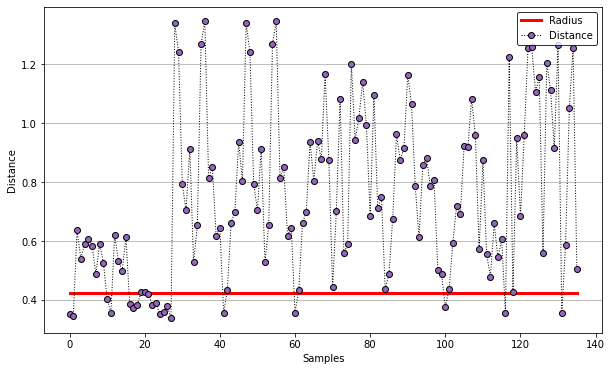

Epoch 1/2
17/17 [==============================] - 117s 7s/step - loss: 1.1863 - accuracy: 0.3881 - val_loss: 1.1906 - val_accuracy: 0.3459
Epoch 2/2
17/17 [==============================] - 116s 7s/step - loss: 1.3032 - accuracy: 0.3326 - val_loss: 1.2610 - val_accuracy: 0.3382


*** Fitting of the SVDD model is completed. ***

running time         = 2.8275 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.4759
number of samples    = 280
number of features   = 90112
number of SVs        = 131
ratio of SVs         = 46.7857 %
accuracy             = 83.5714 %




*** Prediction of the provided data is completed. ***

running time         = 1.1699 seconds
number of samples    = 108
number of alarm      = 101
accuracy             = 93.5185 %




*** Prediction of the provided data is completed. ***

running time         = 0.3240 seconds
number of samples    = 28
number of alarm      = 10
accuracy             = 64.2857 %




*** Prediction of the provided

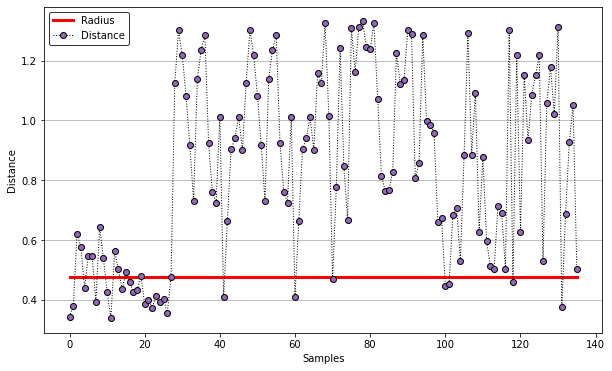

Epoch 1/3
4/4 [==============================] - 73s 19s/step - loss: 1.1742 - accuracy: 0.2540 - val_loss: 1.1771 - val_accuracy: 0.2465
Epoch 2/3
4/4 [==============================] - 56s 17s/step - loss: 1.1735 - accuracy: 0.2584 - val_loss: 1.1770 - val_accuracy: 0.2473
Epoch 3/3
4/4 [==============================] - 55s 17s/step - loss: 1.1733 - accuracy: 0.2670 - val_loss: 1.1770 - val_accuracy: 0.2520


*** Fitting of the SVDD model is completed. ***

running time         = 3.0930 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.4242
number of samples    = 280
number of features   = 90112
number of SVs        = 137
ratio of SVs         = 48.9286 %
accuracy             = 80.3571 %




*** Prediction of the provided data is completed. ***

running time         = 0.3668 seconds
number of samples    = 28
number of alarm      = 15
accuracy             = 46.4286 %




*** Prediction of the provided data is completed. ***

running time         = 1.

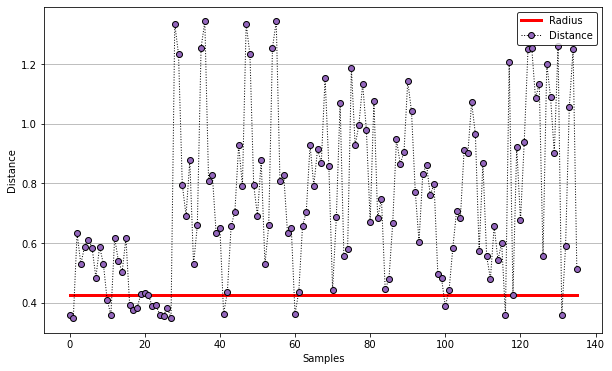

Epoch 1/2
18/18 [==============================] - 131s 7s/step - loss: 1.1797 - accuracy: 0.2950 - val_loss: 1.1822 - val_accuracy: 0.2828
Epoch 2/2
18/18 [==============================] - 124s 7s/step - loss: 1.2397 - accuracy: 0.3180 - val_loss: 1.2419 - val_accuracy: 0.2694


*** Fitting of the SVDD model is completed. ***

running time         = 2.9837 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.4370
number of samples    = 280
number of features   = 90112
number of SVs        = 131
ratio of SVs         = 46.7857 %
accuracy             = 81.4286 %




*** Prediction of the provided data is completed. ***

running time         = 1.2556 seconds
number of samples    = 108
number of alarm      = 102
accuracy             = 94.4444 %




*** Prediction of the provided data is completed. ***

running time         = 0.3303 seconds
number of samples    = 28
number of alarm      = 10
accuracy             = 64.2857 %




*** Prediction of the provide

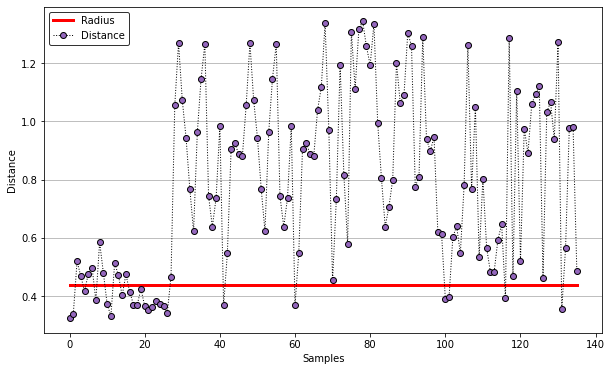

Epoch 1/3
4/4 [==============================] - 65s 16s/step - loss: 1.1837 - accuracy: 0.3436 - val_loss: 1.1755 - val_accuracy: 0.3416
Epoch 2/3
4/4 [==============================] - 50s 15s/step - loss: 1.1835 - accuracy: 0.3539 - val_loss: 1.1755 - val_accuracy: 0.3540
Epoch 3/3
4/4 [==============================] - 50s 15s/step - loss: 1.1834 - accuracy: 0.3705 - val_loss: 1.1755 - val_accuracy: 0.3675


*** Fitting of the SVDD model is completed. ***

running time         = 2.9525 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.4190
number of samples    = 280
number of features   = 90112
number of SVs        = 135
ratio of SVs         = 48.2143 %
accuracy             = 80.7143 %




*** Prediction of the provided data is completed. ***

running time         = 0.3310 seconds
number of samples    = 28
number of alarm      = 14
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.

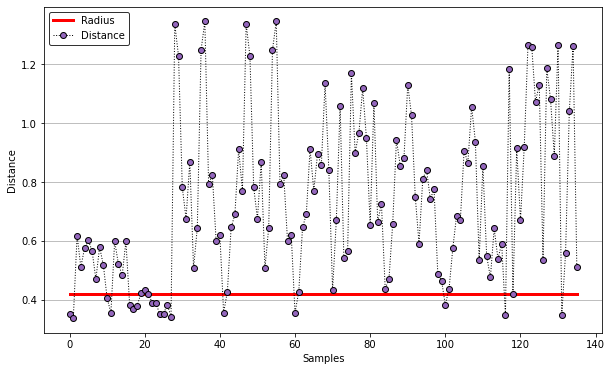

Epoch 1/2
17/17 [==============================] - 118s 7s/step - loss: 1.1801 - accuracy: 0.4004 - val_loss: 1.1825 - val_accuracy: 0.4047
Epoch 2/2
17/17 [==============================] - 115s 7s/step - loss: 1.2280 - accuracy: 0.3637 - val_loss: 1.2305 - val_accuracy: 0.3628


*** Fitting of the SVDD model is completed. ***

running time         = 2.9056 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.4568
number of samples    = 280
number of features   = 90112
number of SVs        = 136
ratio of SVs         = 48.5714 %
accuracy             = 81.7857 %




*** Prediction of the provided data is completed. ***

running time         = 1.2025 seconds
number of samples    = 108
number of alarm      = 102
accuracy             = 94.4444 %




*** Prediction of the provided data is completed. ***

running time         = 0.4210 seconds
number of samples    = 28
number of alarm      = 12
accuracy             = 57.1429 %




*** Prediction of the provide

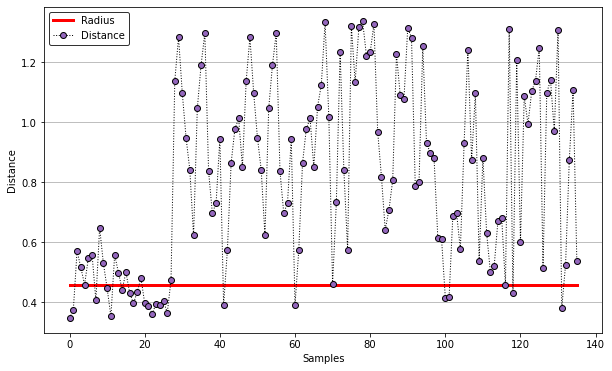

Wall time: 44min 48s


In [5]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-7), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-7), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
4/4 [==============================] - 60s 15s/step - loss: 1.4532 - accuracy: 0.1712 - val_loss: 1.4804 - val_accuracy: 0.2051
Epoch 2/3
4/4 [==============================] - 49s 15s/step - loss: 1.4530 - accuracy: 0.2092 - val_loss: 1.4804 - val_accuracy: 0.2483
Epoch 3/3
4/4 [==============================] - 48s 14s/step - loss: 1.4531 - accuracy: 0.2513 - val_loss: 1.4807 - val_accuracy: 0.2931


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.7413 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9981
number of samples    = 264
number of features   = 90112
number of SVs        = 264
ratio of SVs         = 100.0000 %
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.3775 seconds
number of samples    = 21
number of alarm      = 21
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6626 seconds
number of samples    = 57
number of alarm      = 57
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.9016 seconds
number of samples    = 78
number of alarm      = 78
accuracy             = 73.0769 %




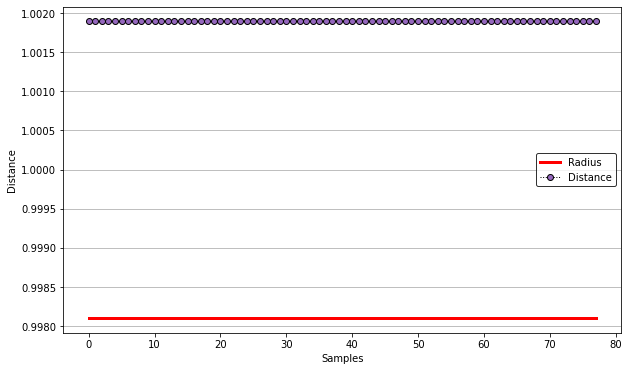

Epoch 1/2
33/33 [==============================] - 196s 6s/step - loss: 1.6786 - accuracy: 0.3879 - val_loss: 2.0137 - val_accuracy: 0.4018
Epoch 2/2
33/33 [==============================] - 194s 6s/step - loss: 6.5138 - accuracy: 0.3401 - val_loss: 5.5482 - val_accuracy: 0.3506


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.8313 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9981
number of samples    = 264
number of features   = 90112
number of SVs        = 264
ratio of SVs         = 100.0000 %
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7289 seconds
number of samples    = 57
number of alarm      = 57
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2936 seconds
number of samples    = 21
number of alarm      = 21
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.9242 seconds
number of samples    = 78
number of alarm      = 78
accuracy             = 73.0769 %




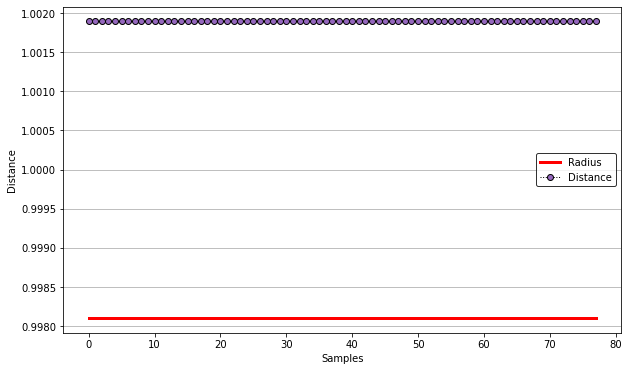

Epoch 1/3
4/4 [==============================] - 61s 15s/step - loss: 1.4821 - accuracy: 0.1428 - val_loss: 1.4787 - val_accuracy: 0.1504
Epoch 2/3
4/4 [==============================] - 48s 14s/step - loss: 1.4849 - accuracy: 0.1670 - val_loss: 1.4825 - val_accuracy: 0.1608
Epoch 3/3
4/4 [==============================] - 48s 14s/step - loss: 1.4973 - accuracy: 0.1782 - val_loss: 1.4915 - val_accuracy: 0.1646


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.7374 seconds
kernel function      = rbf
iterations           = 5
radius               = 0.9981
number of samples    = 264
number of features   = 90112
number of SVs        = 264
ratio of SVs         = 100.0000 %
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2835 seconds
number of samples    = 21
number of alarm      = 21
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6948 seconds
number of samples    = 57
number of alarm      = 57
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.9309 seconds
number of samples    = 78
number of alarm      = 78
accuracy             = 73.0769 %




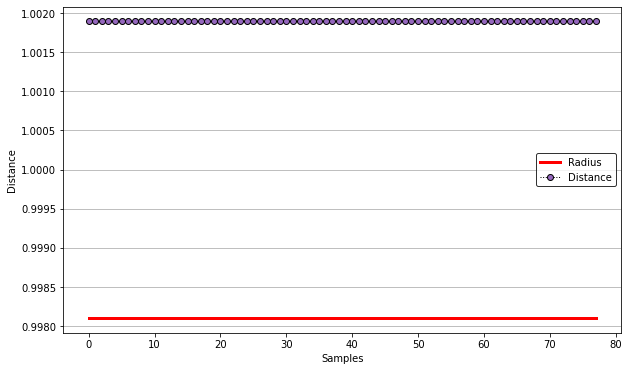

Epoch 1/2
21/33 [==================>...........] - ETA: 1:03 - loss: 1.9845 - accuracy: 0.2009

KeyboardInterrupt: 

In [6]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-1), gamma=10**(-1), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-1), gamma=10**(-1), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
5/5 [==============================] - 100s 20s/step - loss: 0.6588 - accuracy: 0.2106 - val_loss: 0.6456 - val_accuracy: 0.2146
Epoch 2/3
5/5 [==============================] - 74s 17s/step - loss: 0.6563 - accuracy: 0.2206 - val_loss: 0.6429 - val_accuracy: 0.2351
Epoch 3/3
5/5 [==============================] - 72s 17s/step - loss: 0.6528 - accuracy: 0.2612 - val_loss: 0.6398 - val_accuracy: 0.2886


*** Fitting of the SVDD model is completed. ***

running time         = 3.9991 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.6921
number of samples    = 391
number of features   = 90112
number of SVs        = 76
ratio of SVs         = 19.4373 %
accuracy             = 93.3504 %




*** Prediction of the provided data is completed. ***

running time         = 0.5778 seconds
number of samples    = 40
number of alarm      = 4
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.

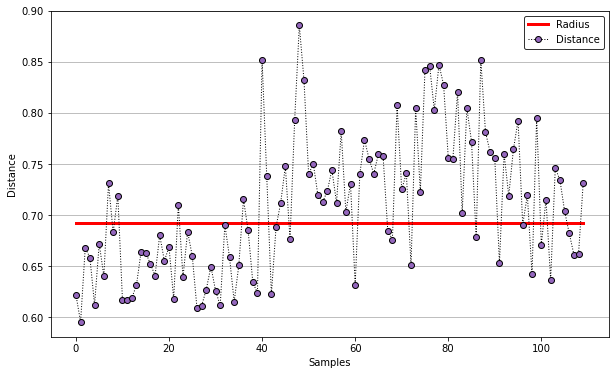

Epoch 1/2
10/10 [==============================] - 102s 11s/step - loss: 0.6363 - accuracy: 0.3234 - val_loss: 0.6423 - val_accuracy: 0.3350
Epoch 2/2
10/10 [==============================] - 98s 10s/step - loss: 0.6511 - accuracy: 0.3335 - val_loss: 0.6705 - val_accuracy: 0.3249


*** Fitting of the SVDD model is completed. ***

running time         = 4.1709 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7939
number of samples    = 391
number of features   = 90112
number of SVs        = 73
ratio of SVs         = 18.6701 %
accuracy             = 93.3504 %




*** Prediction of the provided data is completed. ***

running time         = 0.9908 seconds
number of samples    = 70
number of alarm      = 52
accuracy             = 74.2857 %




*** Prediction of the provided data is completed. ***

running time         = 0.4864 seconds
number of samples    = 40
number of alarm      = 2
accuracy             = 95.0000 %




*** Prediction of the provided d

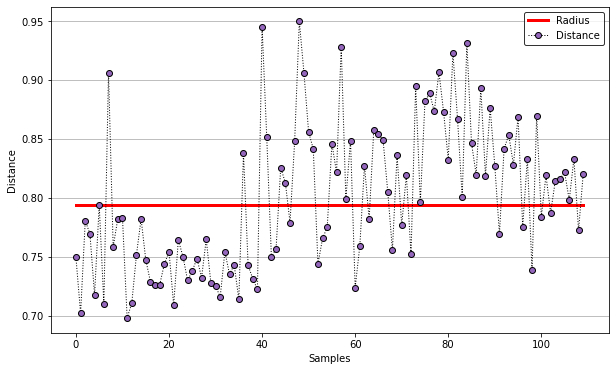

Epoch 1/3
5/5 [==============================] - 89s 18s/step - loss: 0.6393 - accuracy: 0.4073 - val_loss: 0.6448 - val_accuracy: 0.4406
Epoch 2/3
5/5 [==============================] - 72s 17s/step - loss: 0.6367 - accuracy: 0.4312 - val_loss: 0.6427 - val_accuracy: 0.4442
Epoch 3/3
5/5 [==============================] - 72s 17s/step - loss: 0.6451 - accuracy: 0.4285 - val_loss: 0.6464 - val_accuracy: 0.4365


*** Fitting of the SVDD model is completed. ***

running time         = 4.0616 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7140
number of samples    = 391
number of features   = 90112
number of SVs        = 74
ratio of SVs         = 18.9258 %
accuracy             = 93.8619 %




*** Prediction of the provided data is completed. ***

running time         = 0.5162 seconds
number of samples    = 40
number of alarm      = 2
accuracy             = 95.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.9

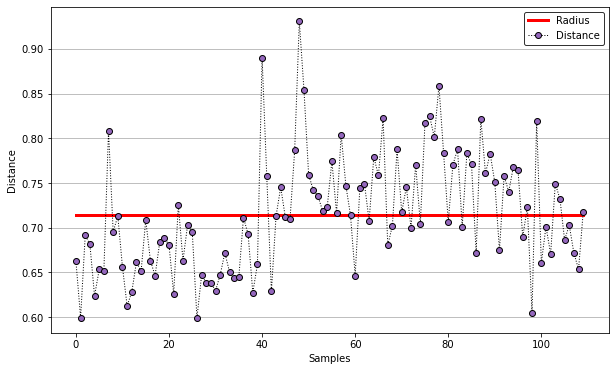

Epoch 1/2
10/10 [==============================] - 104s 11s/step - loss: 0.6895 - accuracy: 0.4290 - val_loss: 0.6785 - val_accuracy: 0.4438
Epoch 2/2
10/10 [==============================] - 100s 11s/step - loss: 0.8788 - accuracy: 0.4200 - val_loss: 0.8321 - val_accuracy: 0.4134


*** Fitting of the SVDD model is completed. ***

running time         = 4.0303 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7569
number of samples    = 391
number of features   = 90112
number of SVs        = 76
ratio of SVs         = 19.4373 %
accuracy             = 91.8159 %




*** Prediction of the provided data is completed. ***

running time         = 1.0067 seconds
number of samples    = 70
number of alarm      = 25
accuracy             = 35.7143 %




*** Prediction of the provided data is completed. ***

running time         = 0.5630 seconds
number of samples    = 40
number of alarm      = 3
accuracy             = 92.5000 %




*** Prediction of the provided 

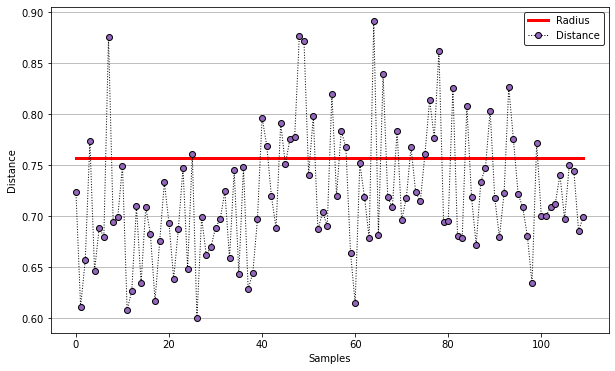

Epoch 1/3
5/5 [==============================] - 86s 18s/step - loss: 0.6458 - accuracy: 0.1123 - val_loss: 0.6489 - val_accuracy: 0.1139
Epoch 2/3
5/5 [==============================] - 71s 17s/step - loss: 0.6445 - accuracy: 0.1235 - val_loss: 0.6490 - val_accuracy: 0.1209
Epoch 3/3
5/5 [==============================] - 72s 17s/step - loss: 0.6482 - accuracy: 0.1360 - val_loss: 0.6521 - val_accuracy: 0.1332


*** Fitting of the SVDD model is completed. ***

running time         = 4.0459 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6917
number of samples    = 391
number of features   = 90112
number of SVs        = 78
ratio of SVs         = 19.9488 %
accuracy             = 92.8389 %




*** Prediction of the provided data is completed. ***

running time         = 0.5673 seconds
number of samples    = 40
number of alarm      = 3
accuracy             = 92.5000 %




*** Prediction of the provided data is completed. ***

running time         = 1.0

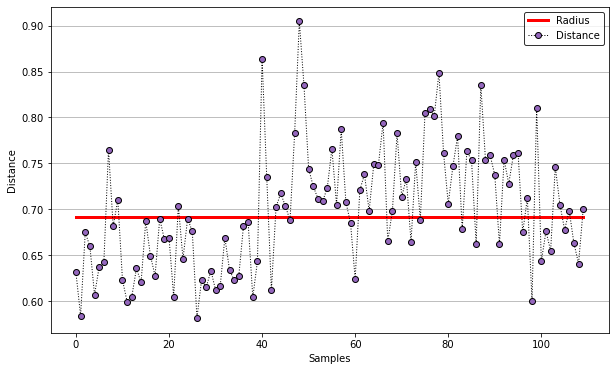

Epoch 1/2
10/10 [==============================] - 105s 11s/step - loss: 0.6776 - accuracy: 0.1634 - val_loss: 0.6795 - val_accuracy: 0.1873
Epoch 2/2
10/10 [==============================] - 100s 11s/step - loss: 0.8005 - accuracy: 0.2308 - val_loss: 0.7802 - val_accuracy: 0.2893


*** Fitting of the SVDD model is completed. ***

running time         = 4.0780 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.7692
number of samples    = 391
number of features   = 90112
number of SVs        = 80
ratio of SVs         = 20.4604 %
accuracy             = 92.5831 %




*** Prediction of the provided data is completed. ***

running time         = 0.9774 seconds
number of samples    = 70
number of alarm      = 30
accuracy             = 42.8571 %




*** Prediction of the provided data is completed. ***

running time         = 0.5936 seconds
number of samples    = 40
number of alarm      = 2
accuracy             = 95.0000 %




*** Prediction of the provided d

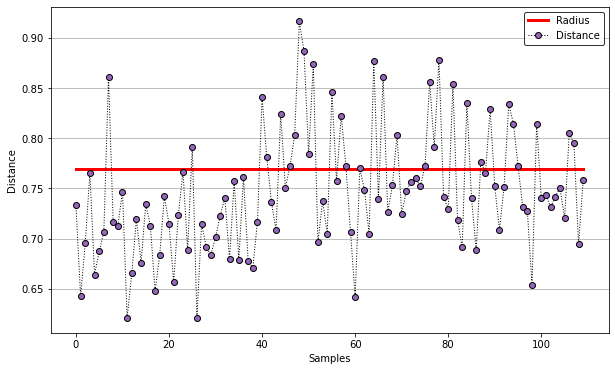

Epoch 1/3
5/5 [==============================] - 87s 18s/step - loss: 0.6377 - accuracy: 0.4317 - val_loss: 0.6418 - val_accuracy: 0.4427
Epoch 2/3
5/5 [==============================] - 72s 17s/step - loss: 0.6345 - accuracy: 0.4281 - val_loss: 0.6400 - val_accuracy: 0.4246
Epoch 3/3
5/5 [==============================] - 72s 17s/step - loss: 0.6336 - accuracy: 0.4077 - val_loss: 0.6406 - val_accuracy: 0.4060


*** Fitting of the SVDD model is completed. ***

running time         = 4.0459 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6923
number of samples    = 391
number of features   = 90112
number of SVs        = 75
ratio of SVs         = 19.1816 %
accuracy             = 93.6061 %




*** Prediction of the provided data is completed. ***

running time         = 0.4999 seconds
number of samples    = 40
number of alarm      = 4
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.9

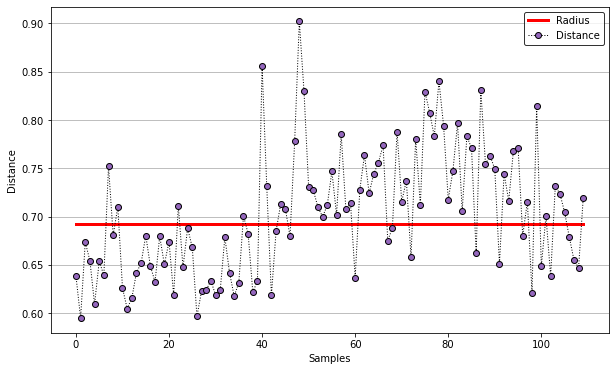

Epoch 1/2
10/10 [==============================] - 100s 11s/step - loss: 0.6466 - accuracy: 0.3901 - val_loss: 0.6551 - val_accuracy: 0.3904
Epoch 2/2
10/10 [==============================] - 97s 10s/step - loss: 0.7208 - accuracy: 0.3796 - val_loss: 0.6970 - val_accuracy: 0.3662


*** Fitting of the SVDD model is completed. ***

running time         = 3.9522 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7491
number of samples    = 391
number of features   = 90112
number of SVs        = 75
ratio of SVs         = 19.1816 %
accuracy             = 93.6061 %




*** Prediction of the provided data is completed. ***

running time         = 0.9529 seconds
number of samples    = 70
number of alarm      = 41
accuracy             = 58.5714 %




*** Prediction of the provided data is completed. ***

running time         = 0.4686 seconds
number of samples    = 40
number of alarm      = 4
accuracy             = 90.0000 %




*** Prediction of the provided d

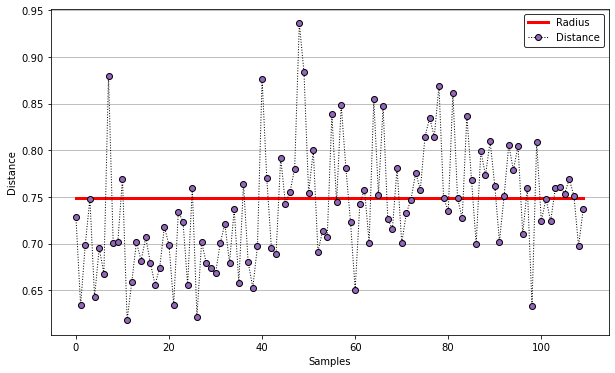

Epoch 1/3
5/5 [==============================] - 88s 18s/step - loss: 0.6428 - accuracy: 0.2296 - val_loss: 0.6467 - val_accuracy: 0.2556
Epoch 2/3
5/5 [==============================] - 72s 17s/step - loss: 0.6418 - accuracy: 0.2688 - val_loss: 0.6455 - val_accuracy: 0.2789
Epoch 3/3
5/5 [==============================] - 71s 16s/step - loss: 0.6532 - accuracy: 0.2879 - val_loss: 0.6505 - val_accuracy: 0.2841


*** Fitting of the SVDD model is completed. ***

running time         = 4.1709 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.7024
number of samples    = 391
number of features   = 90112
number of SVs        = 74
ratio of SVs         = 18.9258 %
accuracy             = 92.8389 %




*** Prediction of the provided data is completed. ***

running time         = 0.5166 seconds
number of samples    = 40
number of alarm      = 4
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.96

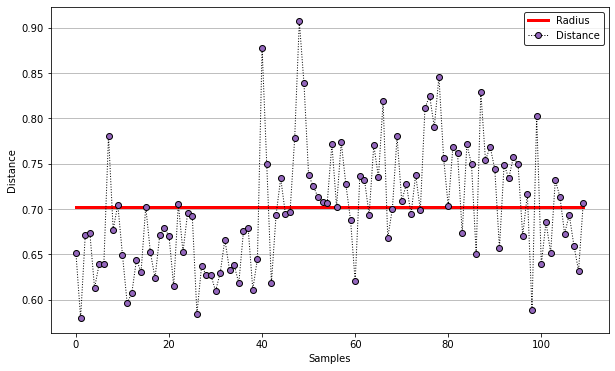

Epoch 1/2
10/10 [==============================] - 113s 12s/step - loss: 0.7206 - accuracy: 0.2723 - val_loss: 0.6937 - val_accuracy: 0.2440
Epoch 2/2
10/10 [==============================] - 97s 10s/step - loss: 0.9131 - accuracy: 0.2657 - val_loss: 0.8379 - val_accuracy: 0.3068


*** Fitting of the SVDD model is completed. ***

running time         = 4.0772 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7626
number of samples    = 391
number of features   = 90112
number of SVs        = 73
ratio of SVs         = 18.6701 %
accuracy             = 93.8619 %




*** Prediction of the provided data is completed. ***

running time         = 0.9975 seconds
number of samples    = 70
number of alarm      = 22
accuracy             = 31.4286 %




*** Prediction of the provided data is completed. ***

running time         = 0.5800 seconds
number of samples    = 40
number of alarm      = 5
accuracy             = 87.5000 %




*** Prediction of the provided d

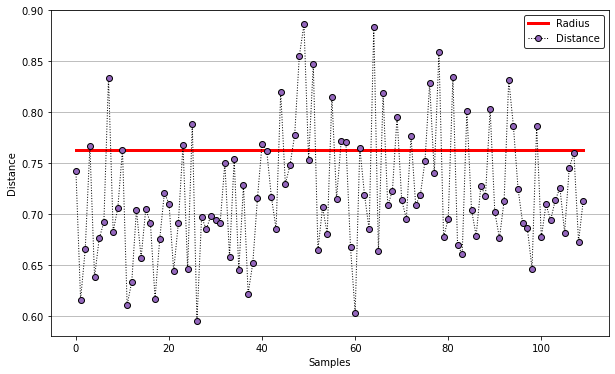

Wall time: 50min 30s


In [21]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-5), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-6), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
3/3 [==============================] - 57s 21s/step - loss: 0.9641 - accuracy: 0.1992 - val_loss: 0.9599 - val_accuracy: 0.3023
Epoch 2/3
3/3 [==============================] - 46s 21s/step - loss: 0.9617 - accuracy: 0.3690 - val_loss: 0.9584 - val_accuracy: 0.4628
Epoch 3/3
3/3 [==============================] - 45s 20s/step - loss: 0.9595 - accuracy: 0.5563 - val_loss: 0.9566 - val_accuracy: 0.6264


*** Fitting of the SVDD model is completed. ***

running time         = 2.7367 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.5116
number of samples    = 245
number of features   = 90112
number of SVs        = 8
ratio of SVs         = 3.2653 %
accuracy             = 97.9592 %




*** Prediction of the provided data is completed. ***

running time         = 0.4169 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.06

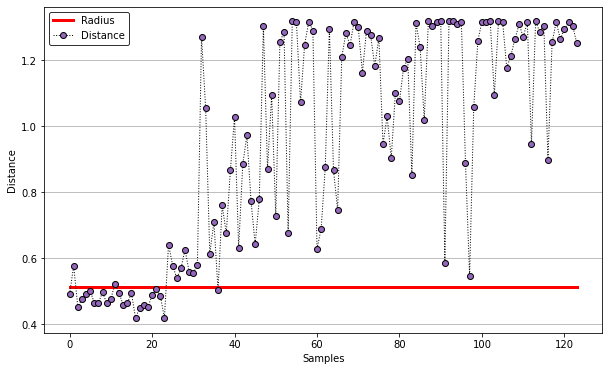

Epoch 1/2
1/1 [==============================] - 46s 46s/step - loss: 1.0018 - accuracy: 0.6725 - val_loss: 0.9563 - val_accuracy: 0.6754
Epoch 2/2
1/1 [==============================] - 41s 41s/step - loss: 1.0007 - accuracy: 0.7211 - val_loss: 0.9556 - val_accuracy: 0.7218


*** Fitting of the SVDD model is completed. ***

running time         = 2.7414 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.5284
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 99.5918 %




*** Prediction of the provided data is completed. ***

running time         = 1.1338 seconds
number of samples    = 92
number of alarm      = 91
accuracy             = 98.9130 %




*** Prediction of the provided data is completed. ***

running time         = 0.5775 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is

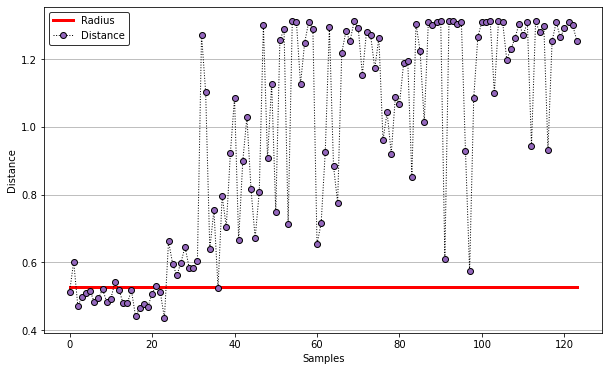

Epoch 1/3
3/3 [==============================] - 58s 22s/step - loss: 0.9634 - accuracy: 0.5088 - val_loss: 0.9575 - val_accuracy: 0.6148
Epoch 2/3
3/3 [==============================] - 47s 21s/step - loss: 0.9602 - accuracy: 0.7362 - val_loss: 0.9565 - val_accuracy: 0.7707
Epoch 3/3
3/3 [==============================] - 49s 22s/step - loss: 0.9559 - accuracy: 0.8861 - val_loss: 0.9573 - val_accuracy: 0.8820


*** Fitting of the SVDD model is completed. ***

running time         = 2.7606 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.4953
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 97.1429 %




*** Prediction of the provided data is completed. ***

running time         = 0.4430 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.14

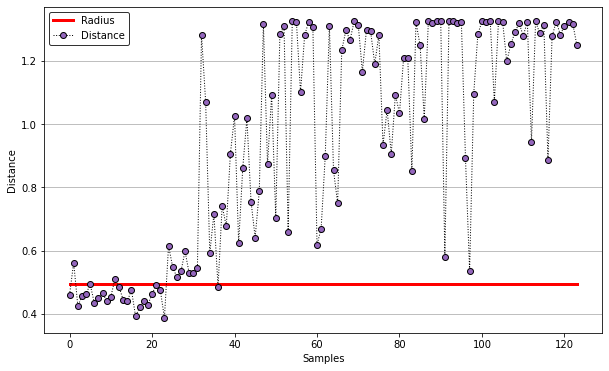

Epoch 1/2
1/1 [==============================] - 45s 45s/step - loss: 1.0072 - accuracy: 0.9449 - val_loss: 0.9587 - val_accuracy: 0.9053
Epoch 2/2
1/1 [==============================] - 39s 39s/step - loss: 1.0056 - accuracy: 0.9622 - val_loss: 0.9598 - val_accuracy: 0.9240


*** Fitting of the SVDD model is completed. ***

running time         = 2.4369 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.5081
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 99.1837 %




*** Prediction of the provided data is completed. ***

running time         = 1.0430 seconds
number of samples    = 92
number of alarm      = 91
accuracy             = 98.9130 %




*** Prediction of the provided data is completed. ***

running time         = 0.4876 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is

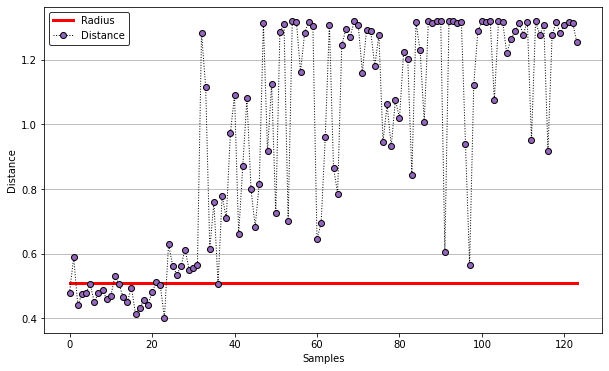

Epoch 1/3
3/3 [==============================] - 58s 22s/step - loss: 0.9739 - accuracy: 0.3265 - val_loss: 0.9590 - val_accuracy: 0.3983
Epoch 2/3
3/3 [==============================] - 45s 20s/step - loss: 0.9707 - accuracy: 0.5685 - val_loss: 0.9570 - val_accuracy: 0.6173
Epoch 3/3
3/3 [==============================] - 44s 20s/step - loss: 0.9673 - accuracy: 0.7830 - val_loss: 0.9549 - val_accuracy: 0.8005


*** Fitting of the SVDD model is completed. ***

running time         = 2.6088 seconds
kernel function      = rbf
iterations           = 13
radius               = 0.5133
number of samples    = 245
number of features   = 90112
number of SVs        = 8
ratio of SVs         = 3.2653 %
accuracy             = 99.5918 %




*** Prediction of the provided data is completed. ***

running time         = 0.3771 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.02

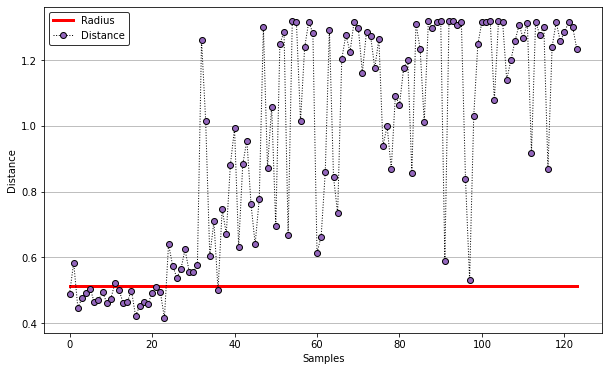

Epoch 1/2
1/1 [==============================] - 38s 38s/step - loss: 0.9986 - accuracy: 0.8800 - val_loss: 0.9556 - val_accuracy: 0.8485
Epoch 2/2
1/1 [==============================] - 38s 38s/step - loss: 0.9973 - accuracy: 0.9114 - val_loss: 0.9551 - val_accuracy: 0.8886


*** Fitting of the SVDD model is completed. ***

running time         = 2.3745 seconds
kernel function      = rbf
iterations           = 13
radius               = 0.5286
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 99.5918 %




*** Prediction of the provided data is completed. ***

running time         = 0.9520 seconds
number of samples    = 92
number of alarm      = 91
accuracy             = 98.9130 %




*** Prediction of the provided data is completed. ***

running time         = 0.3877 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is

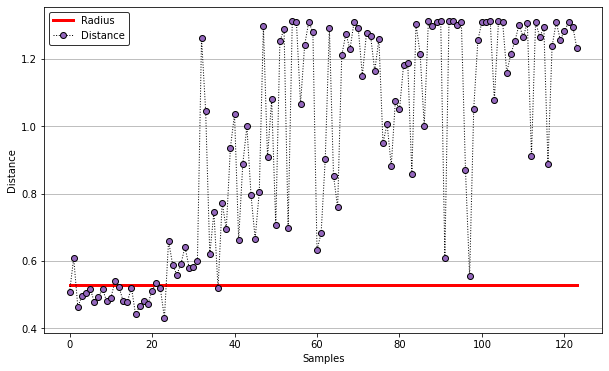

Epoch 1/3
3/3 [==============================] - 54s 21s/step - loss: 0.9850 - accuracy: 0.1155 - val_loss: 0.9588 - val_accuracy: 0.1918
Epoch 2/3
3/3 [==============================] - 45s 20s/step - loss: 0.9822 - accuracy: 0.2558 - val_loss: 0.9571 - val_accuracy: 0.3447
Epoch 3/3
3/3 [==============================] - 44s 20s/step - loss: 0.9799 - accuracy: 0.4493 - val_loss: 0.9552 - val_accuracy: 0.5275


*** Fitting of the SVDD model is completed. ***

running time         = 2.5307 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.4953
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 99.5918 %




*** Prediction of the provided data is completed. ***

running time         = 0.4132 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 0.99

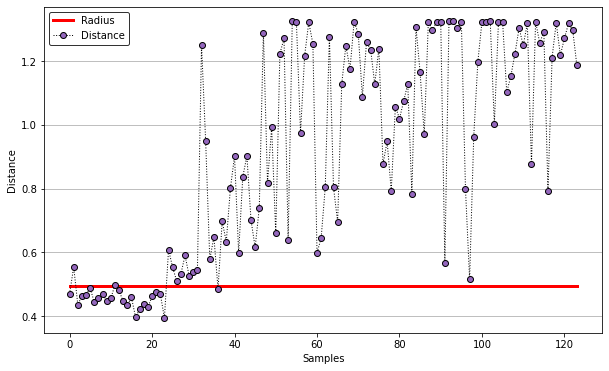

Epoch 1/2
1/1 [==============================] - 44s 44s/step - loss: 1.0163 - accuracy: 0.5761 - val_loss: 0.9569 - val_accuracy: 0.5878
Epoch 2/2
1/1 [==============================] - 38s 38s/step - loss: 1.0153 - accuracy: 0.6365 - val_loss: 0.9563 - val_accuracy: 0.6432


*** Fitting of the SVDD model is completed. ***

running time         = 2.4057 seconds
kernel function      = rbf
iterations           = 13
radius               = 0.5092
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 99.5918 %




*** Prediction of the provided data is completed. ***

running time         = 1.0190 seconds
number of samples    = 92
number of alarm      = 91
accuracy             = 98.9130 %




*** Prediction of the provided data is completed. ***

running time         = 0.4527 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is

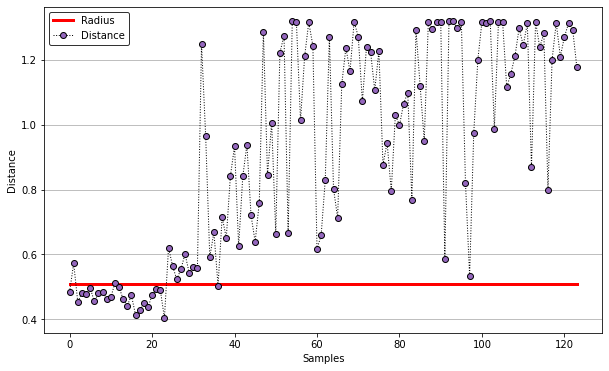

Epoch 1/3
3/3 [==============================] - 58s 22s/step - loss: 0.9731 - accuracy: 0.2384 - val_loss: 0.9609 - val_accuracy: 0.3482
Epoch 2/3
3/3 [==============================] - 45s 20s/step - loss: 0.9699 - accuracy: 0.4275 - val_loss: 0.9592 - val_accuracy: 0.5103
Epoch 3/3
3/3 [==============================] - 45s 20s/step - loss: 0.9677 - accuracy: 0.6037 - val_loss: 0.9573 - val_accuracy: 0.6617


*** Fitting of the SVDD model is completed. ***

running time         = 2.5150 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.5000
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 97.5510 %




*** Prediction of the provided data is completed. ***

running time         = 0.4036 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is completed. ***

running time         = 0.94

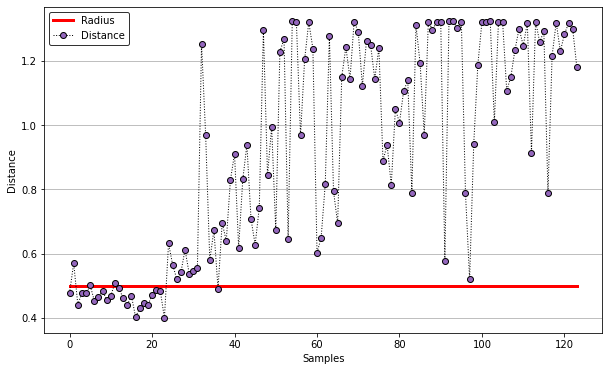

Epoch 1/2
1/1 [==============================] - 45s 45s/step - loss: 1.0173 - accuracy: 0.7029 - val_loss: 0.9576 - val_accuracy: 0.7073
Epoch 2/2
1/1 [==============================] - 38s 38s/step - loss: 1.0165 - accuracy: 0.7509 - val_loss: 0.9569 - val_accuracy: 0.7506


*** Fitting of the SVDD model is completed. ***

running time         = 2.4526 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.5132
number of samples    = 245
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.8571 %
accuracy             = 99.5918 %




*** Prediction of the provided data is completed. ***

running time         = 1.0194 seconds
number of samples    = 92
number of alarm      = 91
accuracy             = 98.9130 %




*** Prediction of the provided data is completed. ***

running time         = 0.4253 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is

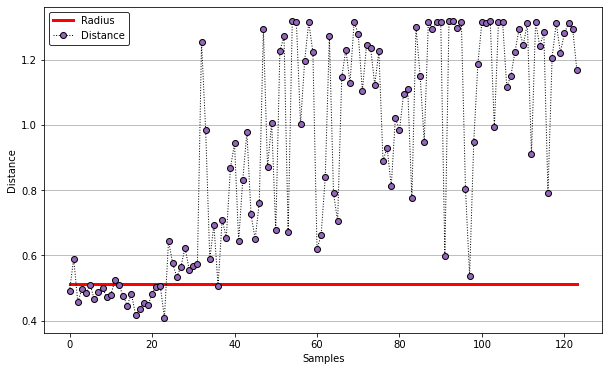

Wall time: 28min 54s


In [22]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
3/3 [==============================] - 54s 20s/step - loss: 0.7448 - accuracy: 0.3052 - val_loss: 0.7576 - val_accuracy: 0.3111
Epoch 2/3
3/3 [==============================] - 40s 18s/step - loss: 0.7447 - accuracy: 0.3235 - val_loss: 0.7578 - val_accuracy: 0.3225
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.7454 - accuracy: 0.3343 - val_loss: 0.7584 - val_accuracy: 0.3279


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1365 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9617
number of samples    = 220
number of features   = 90112
number of SVs        = 118
ratio of SVs         = 53.6364 %
accuracy             = 51.8182 %




*** Prediction of the provided data is completed. ***

running time         = 0.3069 seconds
number of samples    = 22
number of alarm      = 9
accuracy             = 59.0909 %




*** Prediction of the provided data is completed. ***

running time         = 1.0210 seconds
number of samples    = 93
number of alarm      = 89
accuracy             = 95.6989 %




*** Prediction of the provided data is completed. ***

running time         = 1.1580 seconds
number of samples    = 115
number of alarm      = 98
accuracy             = 88.6957 %




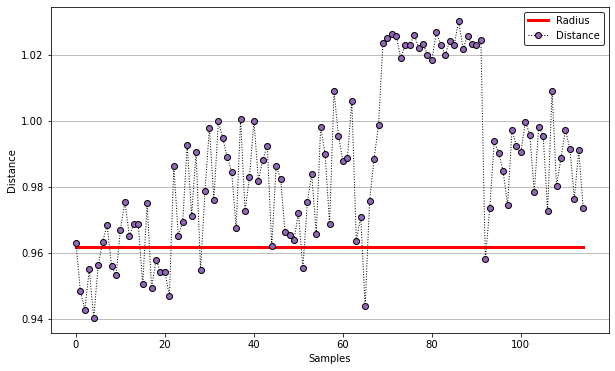

Epoch 1/2
15/15 [==============================] - 103s 7s/step - loss: 0.7799 - accuracy: 0.3344 - val_loss: 0.7871 - val_accuracy: 0.3167
Epoch 2/2
15/15 [==============================] - 98s 7s/step - loss: 0.9411 - accuracy: 0.3112 - val_loss: 1.1738 - val_accuracy: 0.3057


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1434 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9876
number of samples    = 220
number of features   = 90112
number of SVs        = 188
ratio of SVs         = 85.4545 %
accuracy             = 22.2727 %




*** Prediction of the provided data is completed. ***

running time         = 1.0106 seconds
number of samples    = 93
number of alarm      = 90
accuracy             = 96.7742 %




*** Prediction of the provided data is completed. ***

running time         = 0.3461 seconds
number of samples    = 22
number of alarm      = 16
accuracy             = 27.2727 %




*** Prediction of the provided data is completed. ***

running time         = 1.2218 seconds
number of samples    = 115
number of alarm      = 106
accuracy             = 83.4783 %




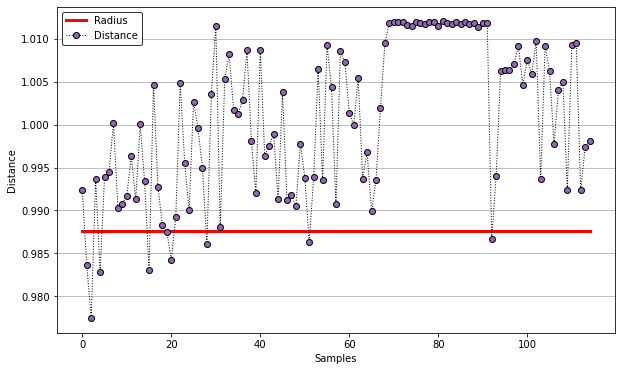

Epoch 1/3
3/3 [==============================] - 54s 19s/step - loss: 0.7829 - accuracy: 0.2789 - val_loss: 0.7531 - val_accuracy: 0.3105
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 0.7824 - accuracy: 0.3179 - val_loss: 0.7530 - val_accuracy: 0.3386
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.7822 - accuracy: 0.3491 - val_loss: 0.7529 - val_accuracy: 0.3576


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1642 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9553
number of samples    = 220
number of features   = 90112
number of SVs        = 111
ratio of SVs         = 50.4545 %
accuracy             = 56.3636 %




*** Prediction of the provided data is completed. ***

running time         = 0.2619 seconds
number of samples    = 22
number of alarm      = 8
accuracy             = 63.6364 %




*** Prediction of the provided data is completed. ***

running time         = 1.0207 seconds
number of samples    = 93
number of alarm      = 87
accuracy             = 93.5484 %




*** Prediction of the provided data is completed. ***

running time         = 1.2678 seconds
number of samples    = 115
number of alarm      = 95
accuracy             = 87.8261 %




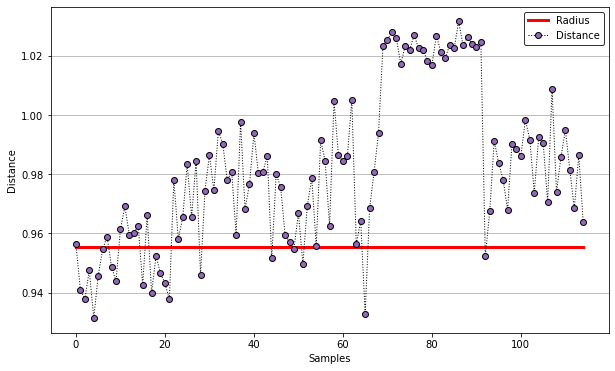

Epoch 1/2
14/14 [==============================] - 97s 7s/step - loss: 0.7668 - accuracy: 0.3765 - val_loss: 0.7636 - val_accuracy: 0.3749
Epoch 2/2
14/14 [==============================] - 95s 7s/step - loss: 0.8119 - accuracy: 0.3602 - val_loss: 0.8946 - val_accuracy: 0.3346


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.0879 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9719
number of samples    = 220
number of features   = 90112
number of SVs        = 119
ratio of SVs         = 54.0909 %
accuracy             = 54.0909 %




*** Prediction of the provided data is completed. ***

running time         = 1.0707 seconds
number of samples    = 93
number of alarm      = 83
accuracy             = 89.2473 %




*** Prediction of the provided data is completed. ***

running time         = 0.3318 seconds
number of samples    = 22
number of alarm      = 11
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.2095 seconds
number of samples    = 115
number of alarm      = 94
accuracy             = 81.7391 %




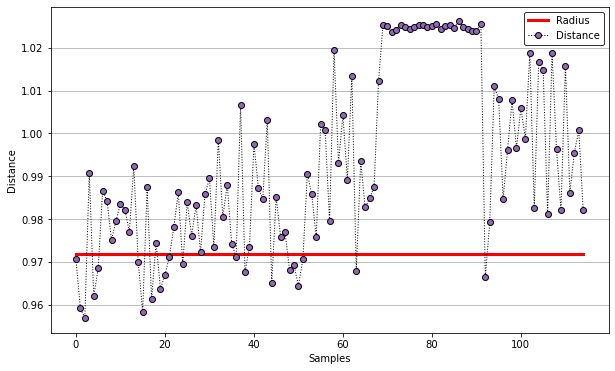

Epoch 1/3
3/3 [==============================] - 53s 19s/step - loss: 0.7641 - accuracy: 0.4232 - val_loss: 0.7552 - val_accuracy: 0.4244
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 0.7638 - accuracy: 0.4322 - val_loss: 0.7551 - val_accuracy: 0.4305
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.7637 - accuracy: 0.4425 - val_loss: 0.7550 - val_accuracy: 0.4388


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1464 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9569
number of samples    = 220
number of features   = 90112
number of SVs        = 118
ratio of SVs         = 53.6364 %
accuracy             = 52.7273 %




*** Prediction of the provided data is completed. ***

running time         = 0.2597 seconds
number of samples    = 22
number of alarm      = 8
accuracy             = 63.6364 %




*** Prediction of the provided data is completed. ***

running time         = 1.0175 seconds
number of samples    = 93
number of alarm      = 88
accuracy             = 94.6237 %




*** Prediction of the provided data is completed. ***

running time         = 1.2353 seconds
number of samples    = 115
number of alarm      = 96
accuracy             = 88.6957 %




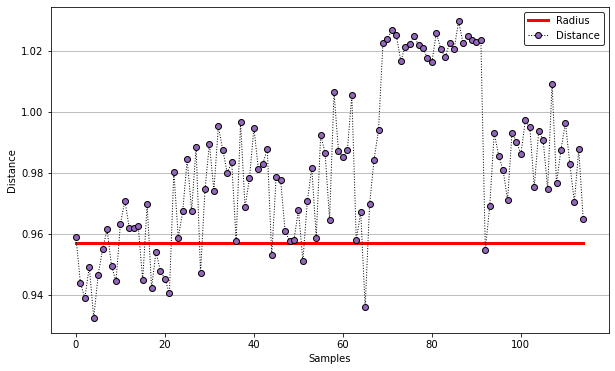

Epoch 1/2
15/15 [==============================] - 102s 7s/step - loss: 0.7657 - accuracy: 0.4633 - val_loss: 0.7590 - val_accuracy: 0.4623
Epoch 2/2
15/15 [==============================] - 101s 7s/step - loss: 0.8026 - accuracy: 0.4464 - val_loss: 0.8890 - val_accuracy: 0.4324


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1820 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9813
number of samples    = 220
number of features   = 90112
number of SVs        = 147
ratio of SVs         = 66.8182 %
accuracy             = 40.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.0304 seconds
number of samples    = 93
number of alarm      = 85
accuracy             = 91.3978 %




*** Prediction of the provided data is completed. ***

running time         = 0.2842 seconds
number of samples    = 22
number of alarm      = 14
accuracy             = 36.3636 %




*** Prediction of the provided data is completed. ***

running time         = 1.3839 seconds
number of samples    = 115
number of alarm      = 99
accuracy             = 80.8696 %




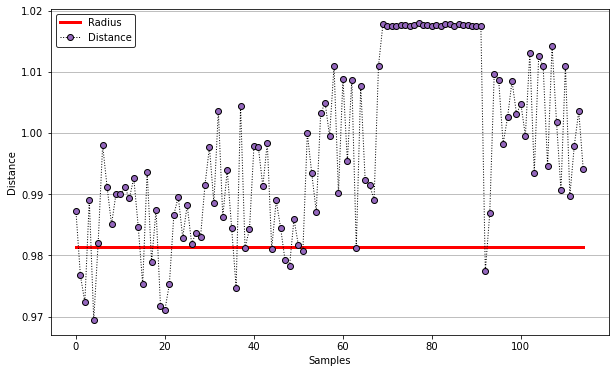

Epoch 1/3
3/3 [==============================] - 52s 19s/step - loss: 0.7768 - accuracy: 0.2758 - val_loss: 0.7540 - val_accuracy: 0.2928
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 0.7764 - accuracy: 0.3051 - val_loss: 0.7539 - val_accuracy: 0.3161
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.7763 - accuracy: 0.3313 - val_loss: 0.7539 - val_accuracy: 0.3349


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 1.9413 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9567
number of samples    = 220
number of features   = 90112
number of SVs        = 117
ratio of SVs         = 53.1818 %
accuracy             = 55.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.3349 seconds
number of samples    = 22
number of alarm      = 8
accuracy             = 63.6364 %




*** Prediction of the provided data is completed. ***

running time         = 1.0692 seconds
number of samples    = 93
number of alarm      = 87
accuracy             = 93.5484 %




*** Prediction of the provided data is completed. ***

running time         = 1.1923 seconds
number of samples    = 115
number of alarm      = 95
accuracy             = 87.8261 %




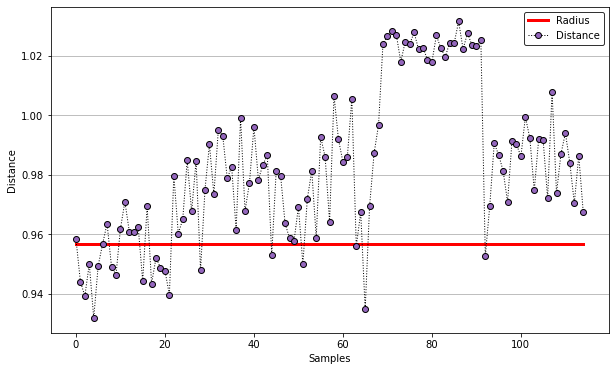

Epoch 1/2
15/15 [==============================] - 101s 7s/step - loss: 0.7683 - accuracy: 0.3593 - val_loss: 0.7727 - val_accuracy: 0.3599
Epoch 2/2
15/15 [==============================] - 100s 7s/step - loss: 0.8462 - accuracy: 0.3500 - val_loss: 1.0418 - val_accuracy: 0.3362


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2067 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9889
number of samples    = 220
number of features   = 90112
number of SVs        = 201
ratio of SVs         = 91.3636 %
accuracy             = 19.0909 %




*** Prediction of the provided data is completed. ***

running time         = 1.0287 seconds
number of samples    = 93
number of alarm      = 89
accuracy             = 95.6989 %




*** Prediction of the provided data is completed. ***

running time         = 0.2483 seconds
number of samples    = 22
number of alarm      = 17
accuracy             = 22.7273 %




*** Prediction of the provided data is completed. ***

running time         = 1.2691 seconds
number of samples    = 115
number of alarm      = 106
accuracy             = 81.7391 %




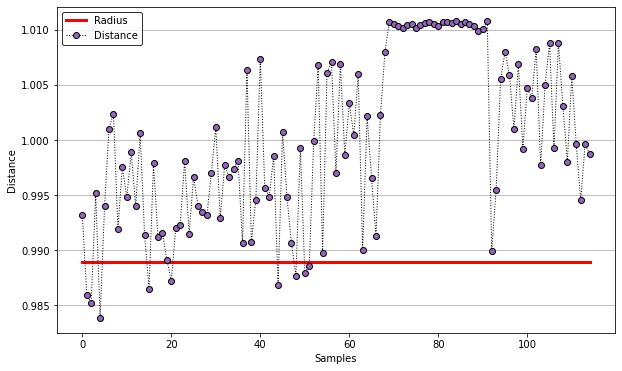

Epoch 1/3
3/3 [==============================] - 54s 20s/step - loss: 0.7741 - accuracy: 0.2606 - val_loss: 0.7545 - val_accuracy: 0.2873
Epoch 2/3
3/3 [==============================] - 42s 18s/step - loss: 0.7735 - accuracy: 0.2976 - val_loss: 0.7542 - val_accuracy: 0.3273
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.7732 - accuracy: 0.3393 - val_loss: 0.7541 - val_accuracy: 0.3677


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1463 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9563
number of samples    = 220
number of features   = 90112
number of SVs        = 115
ratio of SVs         = 52.2727 %
accuracy             = 55.4545 %




*** Prediction of the provided data is completed. ***

running time         = 0.3366 seconds
number of samples    = 22
number of alarm      = 8
accuracy             = 63.6364 %




*** Prediction of the provided data is completed. ***

running time         = 1.0043 seconds
number of samples    = 93
number of alarm      = 87
accuracy             = 93.5484 %




*** Prediction of the provided data is completed. ***

running time         = 1.2348 seconds
number of samples    = 115
number of alarm      = 95
accuracy             = 87.8261 %




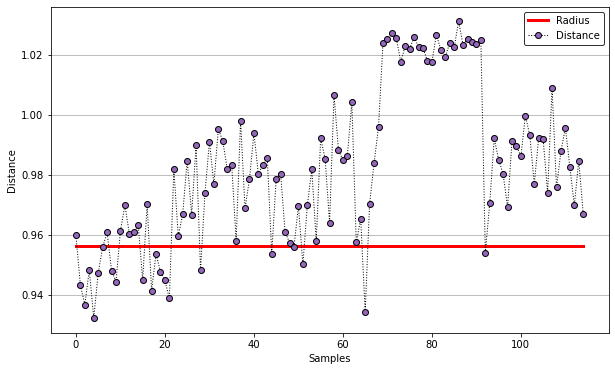

Epoch 1/2
15/15 [==============================] - 99s 7s/step - loss: 0.7660 - accuracy: 0.4223 - val_loss: 0.7666 - val_accuracy: 0.4721
Epoch 2/2
15/15 [==============================] - 97s 7s/step - loss: 0.8121 - accuracy: 0.4780 - val_loss: 0.9330 - val_accuracy: 0.4586


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.0621 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9773
number of samples    = 220
number of features   = 90112
number of SVs        = 120
ratio of SVs         = 54.5455 %
accuracy             = 46.8182 %




*** Prediction of the provided data is completed. ***

running time         = 1.0543 seconds
number of samples    = 93
number of alarm      = 84
accuracy             = 90.3226 %




*** Prediction of the provided data is completed. ***

running time         = 0.3337 seconds
number of samples    = 22
number of alarm      = 13
accuracy             = 40.9091 %




*** Prediction of the provided data is completed. ***

running time         = 1.2070 seconds
number of samples    = 115
number of alarm      = 97
accuracy             = 80.8696 %




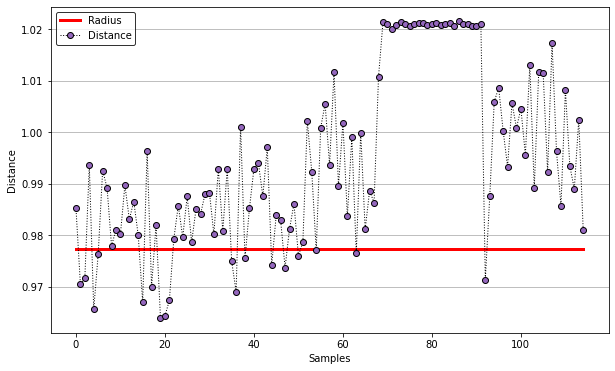

Wall time: 36min 21s


In [23]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
4/4 [==============================] - 62s 16s/step - loss: 1.0227 - accuracy: 0.3437 - val_loss: 1.0230 - val_accuracy: 0.3658
Epoch 2/3
4/4 [==============================] - 49s 15s/step - loss: 1.0243 - accuracy: 0.3498 - val_loss: 1.0258 - val_accuracy: 0.3784
Epoch 3/3
4/4 [==============================] - 49s 15s/step - loss: 1.0405 - accuracy: 0.3587 - val_loss: 1.0401 - val_accuracy: 0.3822


*** Fitting of the SVDD model is completed. ***

running time         = 0.4062 seconds
kernel function      = poly
iterations           = 9
radius               = 2.9291
number of samples    = 267
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 6.3670 %
accuracy             = 35.5805 %




*** Prediction of the provided data is completed. ***

running time         = 0.0312 seconds
number of samples    = 26
number of alarm      = 20
accuracy             = 23.0769 %




*** Prediction of the provided data is completed. ***

running time         = 0.0

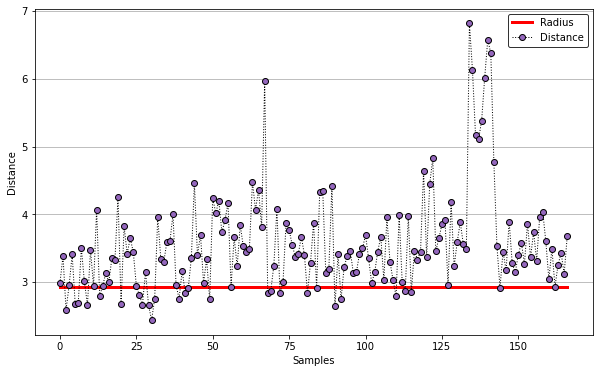

Epoch 1/2
3/3 [==============================] - 46s 21s/step - loss: 1.0919 - accuracy: 0.3635 - val_loss: 1.0729 - val_accuracy: 0.3788
Epoch 2/2
3/3 [==============================] - 47s 21s/step - loss: 1.2033 - accuracy: 0.3641 - val_loss: 1.1425 - val_accuracy: 0.3706


*** Fitting of the SVDD model is completed. ***

running time         = 0.3749 seconds
kernel function      = poly
iterations           = 9
radius               = 3.2193
number of samples    = 267
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 5.6180 %
accuracy             = 69.6629 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 141
number of alarm      = 91
accuracy             = 64.5390 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 12
accuracy             = 53.8462 %




*** Prediction of the provided data 

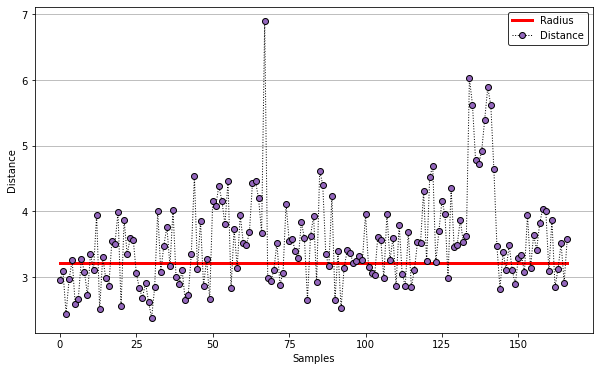

Epoch 1/3
4/4 [==============================] - 64s 16s/step - loss: 1.0275 - accuracy: 0.2115 - val_loss: 1.0221 - val_accuracy: 0.2316
Epoch 2/3
4/4 [==============================] - 49s 15s/step - loss: 1.0301 - accuracy: 0.2437 - val_loss: 1.0249 - val_accuracy: 0.2709
Epoch 3/3
4/4 [==============================] - 49s 15s/step - loss: 1.0499 - accuracy: 0.2811 - val_loss: 1.0389 - val_accuracy: 0.3068


*** Fitting of the SVDD model is completed. ***

running time         = 0.4062 seconds
kernel function      = poly
iterations           = 9
radius               = 2.9156
number of samples    = 267
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 5.6180 %
accuracy             = 29.9625 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 19
accuracy             = 26.9231 %




*** Prediction of the provided data is completed. ***

running time         = 0.0

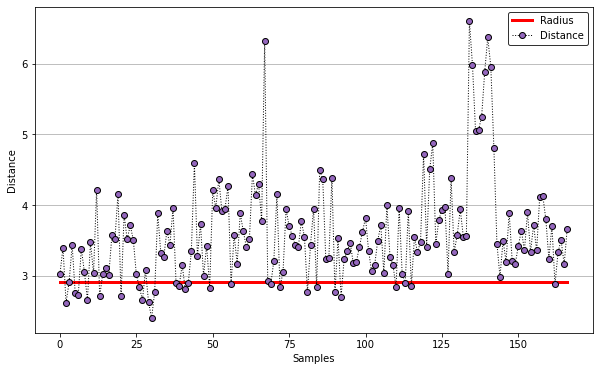

Epoch 1/2
2/2 [==============================] - 47s 41s/step - loss: 1.0980 - accuracy: 0.3135 - val_loss: 1.0583 - val_accuracy: 0.3262
Epoch 2/2
2/2 [==============================] - 46s 41s/step - loss: 1.1653 - accuracy: 0.3336 - val_loss: 1.0924 - val_accuracy: 0.3447


*** Fitting of the SVDD model is completed. ***

running time         = 0.4062 seconds
kernel function      = poly
iterations           = 9
radius               = 3.4212
number of samples    = 267
number of features   = 90112
number of SVs        = 12
ratio of SVs         = 4.4944 %
accuracy             = 79.7753 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 141
number of alarm      = 78
accuracy             = 55.3191 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 7
accuracy             = 73.0769 %




*** Prediction of the provided data i

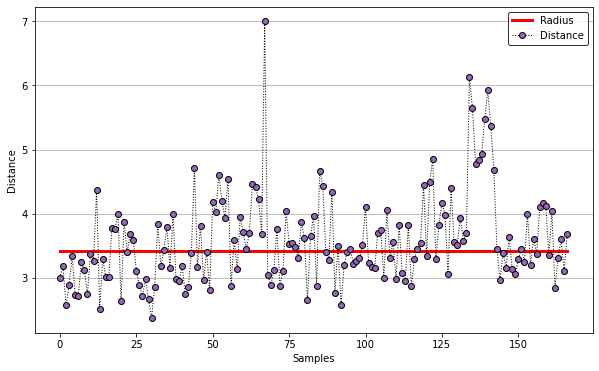

Epoch 1/3
4/4 [==============================] - 64s 15s/step - loss: 1.0299 - accuracy: 0.2356 - val_loss: 1.0287 - val_accuracy: 0.2538
Epoch 2/3
4/4 [==============================] - 49s 15s/step - loss: 1.0672 - accuracy: 0.2644 - val_loss: 1.0613 - val_accuracy: 0.2781
Epoch 3/3
4/4 [==============================] - 49s 15s/step - loss: 1.2015 - accuracy: 0.2935 - val_loss: 1.1610 - val_accuracy: 0.3154


*** Fitting of the SVDD model is completed. ***

running time         = 0.4530 seconds
kernel function      = poly
iterations           = 9
radius               = 3.0014
number of samples    = 267
number of features   = 90112
number of SVs        = 14
ratio of SVs         = 5.2434 %
accuracy             = 37.0787 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 19
accuracy             = 26.9231 %




*** Prediction of the provided data is completed. ***

running time         = 0.0

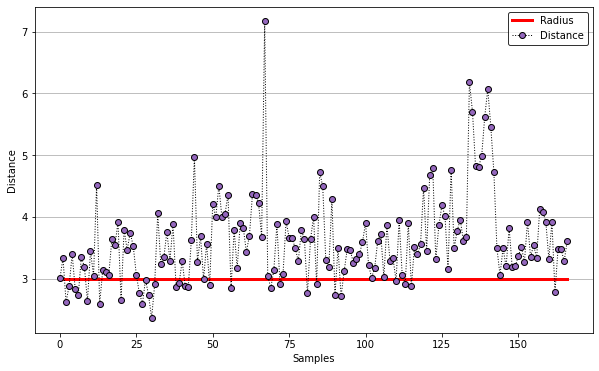

Epoch 1/2
2/2 [==============================] - 45s 40s/step - loss: 1.4147 - accuracy: 0.3240 - val_loss: 1.2496 - val_accuracy: 0.3438
Epoch 2/2
2/2 [==============================] - 45s 40s/step - loss: 1.6073 - accuracy: 0.3513 - val_loss: 1.3725 - val_accuracy: 0.3712


*** Fitting of the SVDD model is completed. ***

running time         = 0.3124 seconds
kernel function      = poly
iterations           = 9
radius               = 3.2812
number of samples    = 267
number of features   = 90112
number of SVs        = 14
ratio of SVs         = 5.2434 %
accuracy             = 72.6592 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 141
number of alarm      = 87
accuracy             = 61.7021 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 11
accuracy             = 57.6923 %




*** Prediction of the provided data 

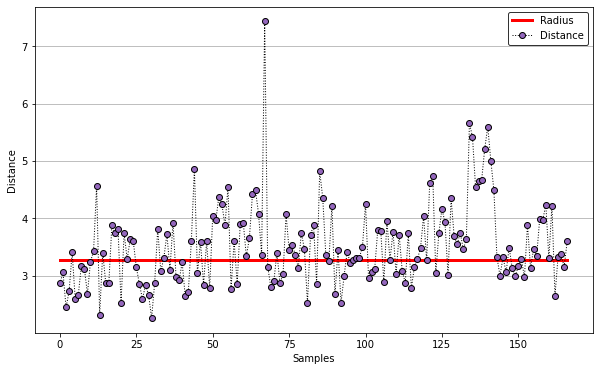

Epoch 1/3
4/4 [==============================] - 65s 16s/step - loss: 1.0310 - accuracy: 0.3763 - val_loss: 1.0220 - val_accuracy: 0.3809
Epoch 2/3
4/4 [==============================] - 50s 15s/step - loss: 1.0356 - accuracy: 0.3978 - val_loss: 1.0280 - val_accuracy: 0.3960
Epoch 3/3
4/4 [==============================] - 49s 15s/step - loss: 1.0689 - accuracy: 0.4074 - val_loss: 1.0558 - val_accuracy: 0.4034


*** Fitting of the SVDD model is completed. ***

running time         = 0.4374 seconds
kernel function      = poly
iterations           = 9
radius               = 3.1864
number of samples    = 267
number of features   = 90112
number of SVs        = 14
ratio of SVs         = 5.2434 %
accuracy             = 60.2996 %




*** Prediction of the provided data is completed. ***

running time         = 0.0313 seconds
number of samples    = 26
number of alarm      = 13
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0

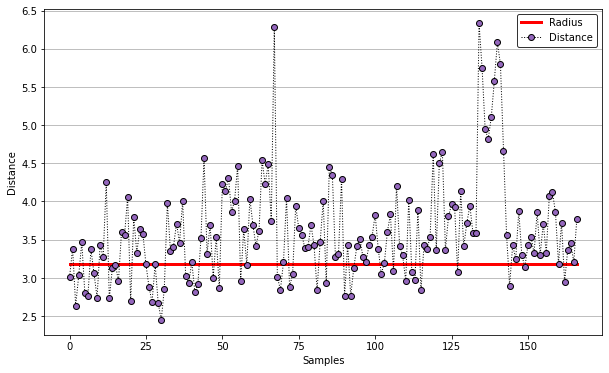

Epoch 1/2
2/2 [==============================] - 46s 41s/step - loss: 1.1499 - accuracy: 0.4062 - val_loss: 1.0893 - val_accuracy: 0.4008
Epoch 2/2
2/2 [==============================] - 45s 40s/step - loss: 1.2490 - accuracy: 0.4026 - val_loss: 1.1426 - val_accuracy: 0.3946


*** Fitting of the SVDD model is completed. ***

running time         = 0.3749 seconds
kernel function      = poly
iterations           = 9
radius               = 3.2672
number of samples    = 267
number of features   = 90112
number of SVs        = 13
ratio of SVs         = 4.8689 %
accuracy             = 68.9139 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 141
number of alarm      = 90
accuracy             = 63.8298 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 12
accuracy             = 53.8462 %




*** Prediction of the provided data 

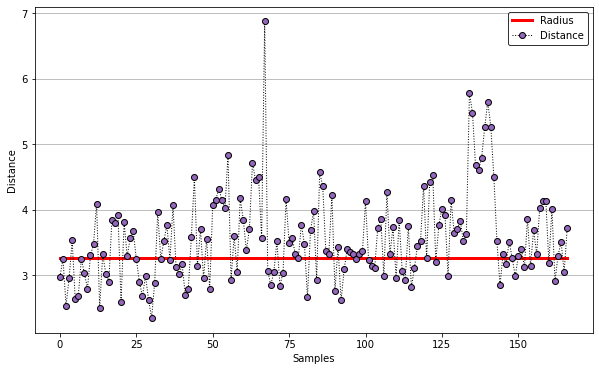

Epoch 1/3
4/4 [==============================] - 63s 16s/step - loss: 1.0230 - accuracy: 0.4686 - val_loss: 1.0214 - val_accuracy: 0.5029
Epoch 2/3
4/4 [==============================] - 48s 14s/step - loss: 1.0224 - accuracy: 0.4968 - val_loss: 1.0211 - val_accuracy: 0.5591
Epoch 3/3
4/4 [==============================] - 48s 14s/step - loss: 1.0222 - accuracy: 0.5443 - val_loss: 1.0209 - val_accuracy: 0.6037


*** Fitting of the SVDD model is completed. ***

running time         = 0.4218 seconds
kernel function      = poly
iterations           = 9
radius               = 2.1987
number of samples    = 267
number of features   = 90112
number of SVs        = 12
ratio of SVs         = 4.4944 %
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 26
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.109

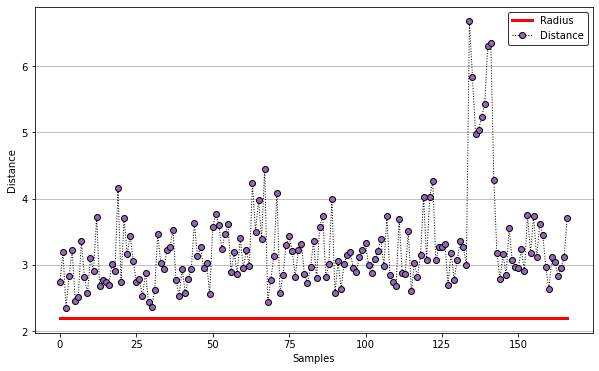

Epoch 1/2
2/2 [==============================] - 45s 40s/step - loss: 1.0317 - accuracy: 0.5747 - val_loss: 1.0209 - val_accuracy: 0.6195
Epoch 2/2
2/2 [==============================] - 44s 39s/step - loss: 1.0315 - accuracy: 0.5919 - val_loss: 1.0208 - val_accuracy: 0.6318


*** Fitting of the SVDD model is completed. ***

running time         = 0.4843 seconds
kernel function      = poly
iterations           = 9
radius               = 1.8860
number of samples    = 267
number of features   = 90112
number of SVs        = 11
ratio of SVs         = 4.1199 %
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0937 seconds
number of samples    = 141
number of alarm      = 141
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0469 seconds
number of samples    = 26
number of alarm      = 26
accuracy             = 0.0000 %




*** Prediction of the provided data 

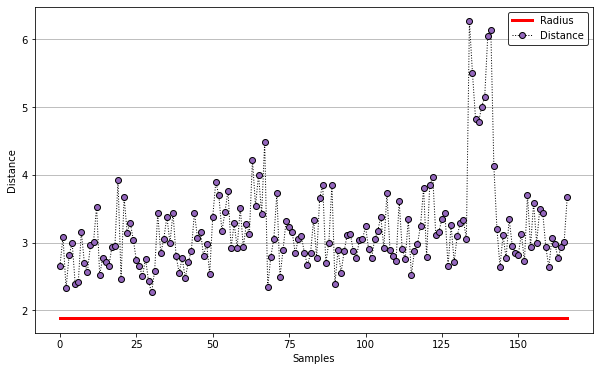

Wall time: 30min 59s


In [24]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), degree=5, kernel='poly', coef0=1, display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), degree=5, kernel='poly', coef0=1, display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
4/4 [==============================] - 73s 19s/step - loss: 2.3616 - accuracy: 0.2451 - val_loss: 2.3857 - val_accuracy: 0.2351
Epoch 2/3
4/4 [==============================] - 58s 18s/step - loss: 2.3624 - accuracy: 0.2175 - val_loss: 2.3872 - val_accuracy: 0.2066
Epoch 3/3
4/4 [==============================] - 59s 18s/step - loss: 2.3708 - accuracy: 0.1921 - val_loss: 2.3939 - val_accuracy: 0.1865


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.1906 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9879
number of samples    = 320
number of features   = 90112
number of SVs        = 260
ratio of SVs         = 81.2500 %
accuracy             = 30.3125 %




*** Prediction of the provided data is completed. ***

running time         = 0.5230 seconds
number of samples    = 41
number of alarm      = 31
accuracy             = 24.3902 %




*** Prediction of the provided data is completed. ***

running time         = 1.3293 seconds
number of samples    = 119
number of alarm      = 115
accuracy             = 96.6387 %




*** Prediction of the provided data is completed. ***

running time         = 1.7089 seconds
number of samples    = 160
number of alarm      = 146
accuracy             = 78.1250 %




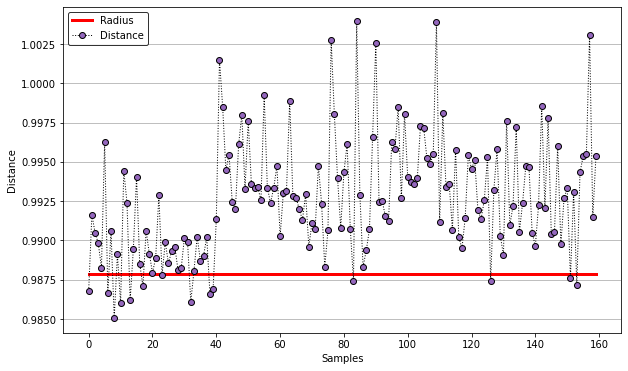

Epoch 1/2
33/33 [==============================] - 213s 6s/step - loss: 5.8498 - accuracy: 0.1651 - val_loss: 3.9581 - val_accuracy: 0.1550
Epoch 2/2
33/33 [==============================] - 201s 6s/step - loss: 82.0317 - accuracy: 0.1605 - val_loss: 30.6119 - val_accuracy: 0.1943


*** Fitting of the SVDD model is completed. ***

running time         = 3.2024 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.6417
number of samples    = 320
number of features   = 90112
number of SVs        = 9
ratio of SVs         = 2.8125 %
accuracy             = 99.6875 %




*** Prediction of the provided data is completed. ***

running time         = 1.4000 seconds
number of samples    = 119
number of alarm      = 8
accuracy             = 6.7227 %




*** Prediction of the provided data is completed. ***

running time         = 0.5434 seconds
number of samples    = 41
number of alarm      = 0
accuracy             = 100.0000 %




*** Prediction of the provided da

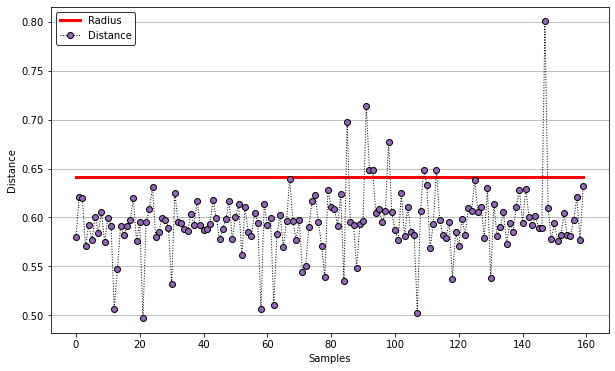

Epoch 1/3
4/4 [==============================] - 72s 19s/step - loss: 2.3813 - accuracy: 0.3040 - val_loss: 2.3835 - val_accuracy: 0.3349
Epoch 2/3
4/4 [==============================] - 61s 19s/step - loss: 2.3828 - accuracy: 0.3678 - val_loss: 2.3854 - val_accuracy: 0.3933
Epoch 3/3
4/4 [==============================] - 61s 19s/step - loss: 2.3951 - accuracy: 0.4185 - val_loss: 2.3938 - val_accuracy: 0.4362


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.2974 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9883
number of samples    = 320
number of features   = 90112
number of SVs        = 258
ratio of SVs         = 80.6250 %
accuracy             = 30.3125 %




*** Prediction of the provided data is completed. ***

running time         = 0.5738 seconds
number of samples    = 41
number of alarm      = 31
accuracy             = 24.3902 %




*** Prediction of the provided data is completed. ***

running time         = 1.3487 seconds
number of samples    = 119
number of alarm      = 115
accuracy             = 96.6387 %




*** Prediction of the provided data is completed. ***

running time         = 1.6163 seconds
number of samples    = 160
number of alarm      = 146
accuracy             = 78.1250 %




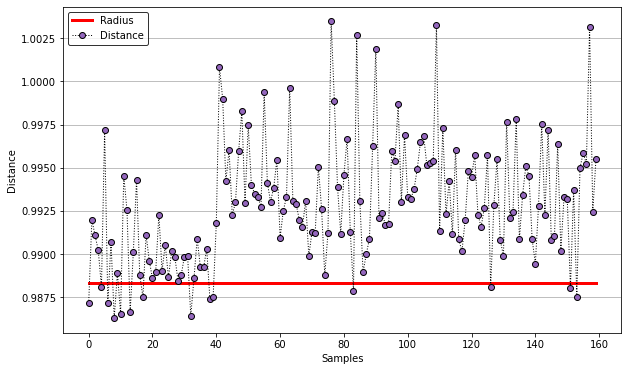

Epoch 1/2
33/33 [==============================] - 212s 6s/step - loss: 5.5164 - accuracy: 0.4711 - val_loss: 3.9561 - val_accuracy: 0.4142
Epoch 2/2
33/33 [==============================] - 200s 6s/step - loss: 63.6824 - accuracy: 0.3504 - val_loss: 18.5374 - val_accuracy: 0.2657


*** Fitting of the SVDD model is completed. ***

running time         = 3.2961 seconds
kernel function      = rbf
iterations           = 13
radius               = 0.6044
number of samples    = 320
number of features   = 90112
number of SVs        = 10
ratio of SVs         = 3.1250 %
accuracy             = 99.6875 %




*** Prediction of the provided data is completed. ***

running time         = 1.3560 seconds
number of samples    = 119
number of alarm      = 10
accuracy             = 8.4034 %




*** Prediction of the provided data is completed. ***

running time         = 0.5528 seconds
number of samples    = 41
number of alarm      = 0
accuracy             = 100.0000 %




*** Prediction of the provided 

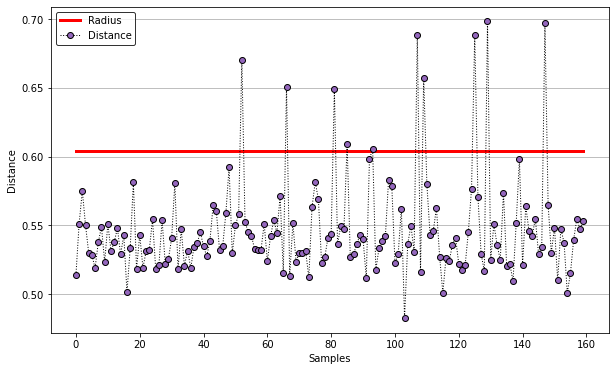

Epoch 1/3
4/4 [==============================] - 76s 20s/step - loss: 2.3831 - accuracy: 0.2808 - val_loss: 2.3854 - val_accuracy: 0.2676
Epoch 2/3
4/4 [==============================] - 62s 19s/step - loss: 2.3903 - accuracy: 0.2674 - val_loss: 2.3921 - val_accuracy: 0.2553
Epoch 3/3
4/4 [==============================] - 61s 19s/step - loss: 2.4341 - accuracy: 0.2578 - val_loss: 2.4176 - val_accuracy: 0.2473


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.2396 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9889
number of samples    = 320
number of features   = 90112
number of SVs        = 261
ratio of SVs         = 81.5625 %
accuracy             = 28.1250 %




*** Prediction of the provided data is completed. ***

running time         = 0.5893 seconds
number of samples    = 41
number of alarm      = 31
accuracy             = 24.3902 %




*** Prediction of the provided data is completed. ***

running time         = 1.3172 seconds
number of samples    = 119
number of alarm      = 115
accuracy             = 96.6387 %




*** Prediction of the provided data is completed. ***

running time         = 1.7095 seconds
number of samples    = 160
number of alarm      = 146
accuracy             = 78.1250 %




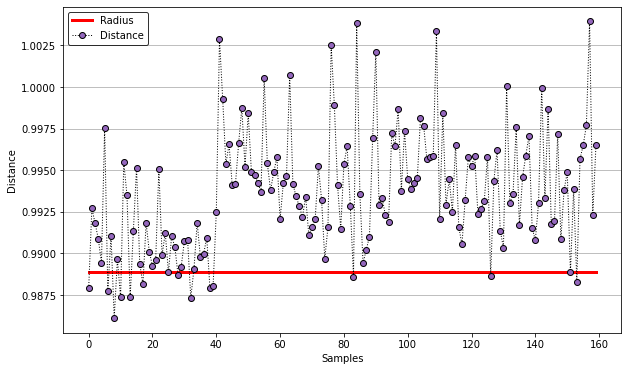

Epoch 1/2
33/33 [==============================] - 216s 6s/step - loss: 6.6226 - accuracy: 0.2562 - val_loss: 3.7647 - val_accuracy: 0.2759
Epoch 2/2
33/33 [==============================] - 204s 6s/step - loss: 66.7815 - accuracy: 0.3303 - val_loss: 22.6181 - val_accuracy: 0.4420


*** Fitting of the SVDD model is completed. ***

running time         = 3.0774 seconds
kernel function      = rbf
iterations           = 14
radius               = 0.5458
number of samples    = 320
number of features   = 90112
number of SVs        = 6
ratio of SVs         = 1.8750 %
accuracy             = 99.0625 %




*** Prediction of the provided data is completed. ***

running time         = 1.2136 seconds
number of samples    = 119
number of alarm      = 7
accuracy             = 5.8824 %




*** Prediction of the provided data is completed. ***

running time         = 0.5315 seconds
number of samples    = 41
number of alarm      = 0
accuracy             = 100.0000 %




*** Prediction of the provided da

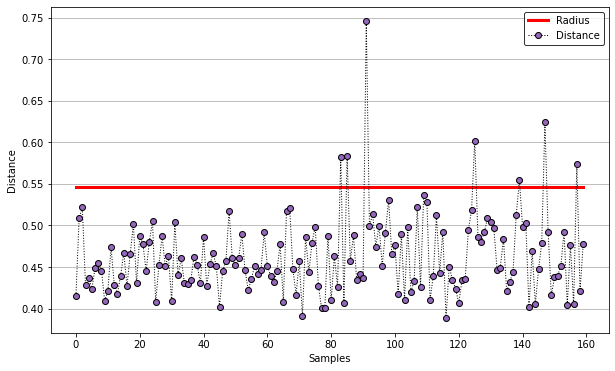

Epoch 1/3
4/4 [==============================] - 76s 20s/step - loss: 2.3681 - accuracy: 0.4206 - val_loss: 2.3847 - val_accuracy: 0.4180
Epoch 2/3
4/4 [==============================] - 61s 19s/step - loss: 2.3687 - accuracy: 0.4349 - val_loss: 2.3859 - val_accuracy: 0.4184
Epoch 3/3
4/4 [==============================] - 61s 19s/step - loss: 2.3745 - accuracy: 0.4305 - val_loss: 2.3910 - val_accuracy: 0.4177


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.3972 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9890
number of samples    = 320
number of features   = 90112
number of SVs        = 254
ratio of SVs         = 79.3750 %
accuracy             = 26.8750 %




*** Prediction of the provided data is completed. ***

running time         = 0.5803 seconds
number of samples    = 41
number of alarm      = 31
accuracy             = 24.3902 %




*** Prediction of the provided data is completed. ***

running time         = 1.3655 seconds
number of samples    = 119
number of alarm      = 116
accuracy             = 97.4790 %




*** Prediction of the provided data is completed. ***

running time         = 1.6183 seconds
number of samples    = 160
number of alarm      = 147
accuracy             = 78.7500 %




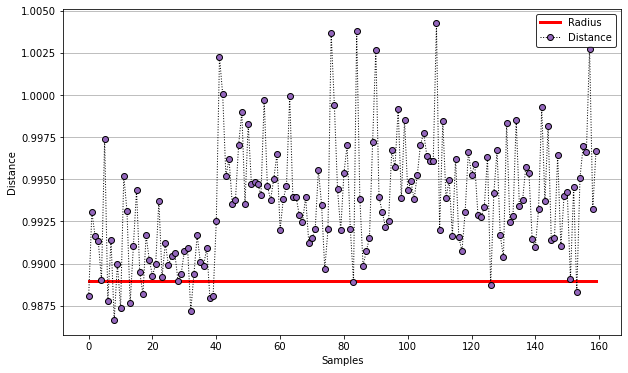

Epoch 1/2
32/32 [==============================] - 211s 6s/step - loss: 4.8006 - accuracy: 0.3570 - val_loss: 3.8997 - val_accuracy: 0.2946
Epoch 2/2
32/32 [==============================] - 201s 6s/step - loss: 64.9030 - accuracy: 0.3558 - val_loss: 24.3534 - val_accuracy: 0.4478


*** Fitting of the SVDD model is completed. ***

running time         = 3.1108 seconds
kernel function      = rbf
iterations           = 14
radius               = 0.8534
number of samples    = 320
number of features   = 90112
number of SVs        = 18
ratio of SVs         = 5.6250 %
accuracy             = 97.1875 %




*** Prediction of the provided data is completed. ***

running time         = 1.1637 seconds
number of samples    = 119
number of alarm      = 18
accuracy             = 15.1261 %




*** Prediction of the provided data is completed. ***

running time         = 0.4801 seconds
number of samples    = 41
number of alarm      = 7
accuracy             = 82.9268 %




*** Prediction of the provided 

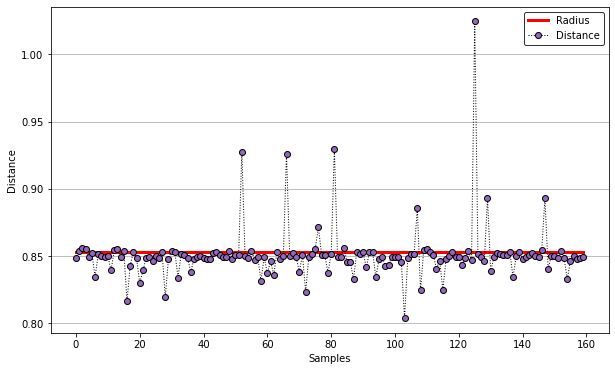

Epoch 1/3
4/4 [==============================] - 76s 20s/step - loss: 2.3900 - accuracy: 0.2115 - val_loss: 2.3837 - val_accuracy: 0.2280
Epoch 2/3
4/4 [==============================] - 62s 19s/step - loss: 2.3887 - accuracy: 0.2383 - val_loss: 2.3836 - val_accuracy: 0.2512
Epoch 3/3
4/4 [==============================] - 61s 19s/step - loss: 2.3892 - accuracy: 0.2697 - val_loss: 2.3846 - val_accuracy: 0.2789


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.2229 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.9852
number of samples    = 320
number of features   = 90112
number of SVs        = 218
ratio of SVs         = 68.1250 %
accuracy             = 36.8750 %




*** Prediction of the provided data is completed. ***

running time         = 0.5740 seconds
number of samples    = 41
number of alarm      = 29
accuracy             = 29.2683 %




*** Prediction of the provided data is completed. ***

running time         = 1.3486 seconds
number of samples    = 119
number of alarm      = 114
accuracy             = 95.7983 %




*** Prediction of the provided data is completed. ***

running time         = 1.6482 seconds
number of samples    = 160
number of alarm      = 143
accuracy             = 78.7500 %




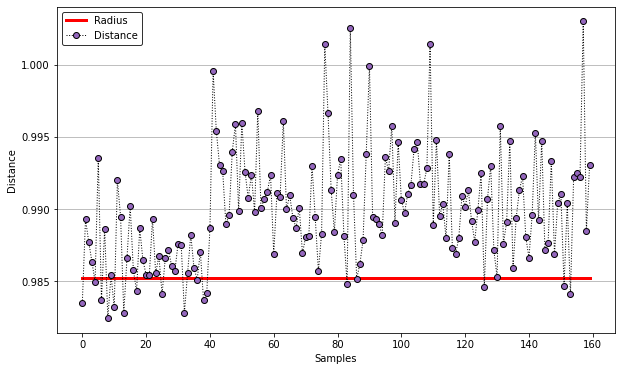

Epoch 1/2
28/28 [==============================] - 188s 6s/step - loss: 3.1315 - accuracy: 0.3563 - val_loss: 3.0799 - val_accuracy: 0.3853
Epoch 2/2
28/28 [==============================] - 177s 6s/step - loss: 23.8153 - accuracy: 0.4113 - val_loss: 12.9576 - val_accuracy: 0.4474


*** Fitting of the SVDD model is completed. ***

running time         = 3.2180 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6963
number of samples    = 320
number of features   = 90112
number of SVs        = 16
ratio of SVs         = 5.0000 %
accuracy             = 96.2500 %




*** Prediction of the provided data is completed. ***

running time         = 1.3918 seconds
number of samples    = 119
number of alarm      = 15
accuracy             = 12.6050 %




*** Prediction of the provided data is completed. ***

running time         = 0.5251 seconds
number of samples    = 41
number of alarm      = 2
accuracy             = 95.1220 %




*** Prediction of the provided 

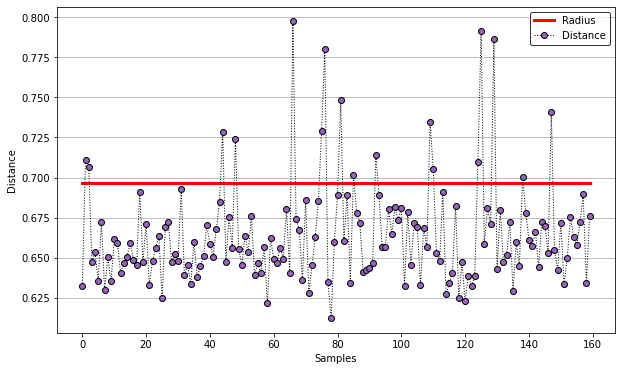

Wall time: 1h 2min 28s


In [25]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
3/3 [==============================] - 59s 21s/step - loss: 1.5344 - accuracy: 0.2615 - val_loss: 1.5089 - val_accuracy: 0.2622
Epoch 2/3
3/3 [==============================] - 45s 20s/step - loss: 1.5341 - accuracy: 0.2585 - val_loss: 1.5093 - val_accuracy: 0.2580
Epoch 3/3
3/3 [==============================] - 45s 20s/step - loss: 1.5345 - accuracy: 0.2534 - val_loss: 1.5103 - val_accuracy: 0.2524


*** Fitting of the SVDD model is completed. ***

running time         = 2.0620 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7216
number of samples    = 230
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 6.5217 %
accuracy             = 99.1304 %




*** Prediction of the provided data is completed. ***

running time         = 0.3437 seconds
number of samples    = 33
number of alarm      = 1
accuracy             = 96.9697 %




*** Prediction of the provided data is completed. ***

running time         = 0.79

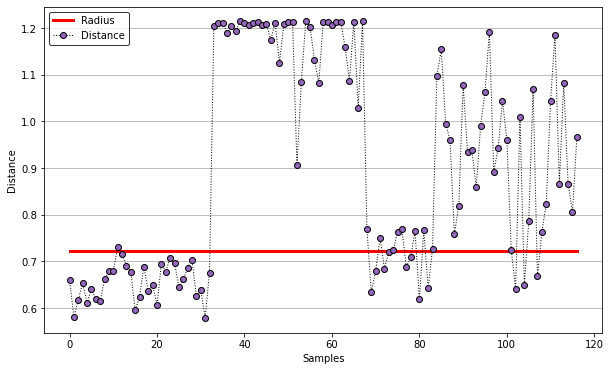

Epoch 1/2
2/2 [==============================] - 43s 38s/step - loss: 1.5190 - accuracy: 0.2672 - val_loss: 1.5143 - val_accuracy: 0.2483
Epoch 2/2
2/2 [==============================] - 42s 37s/step - loss: 1.5211 - accuracy: 0.2641 - val_loss: 1.5167 - val_accuracy: 0.2455


*** Fitting of the SVDD model is completed. ***

running time         = 2.1245 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7099
number of samples    = 230
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 6.5217 %
accuracy             = 98.6957 %




*** Prediction of the provided data is completed. ***

running time         = 0.9685 seconds
number of samples    = 84
number of alarm      = 70
accuracy             = 83.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.4218 seconds
number of samples    = 33
number of alarm      = 2
accuracy             = 93.9394 %




*** Prediction of the provided data is

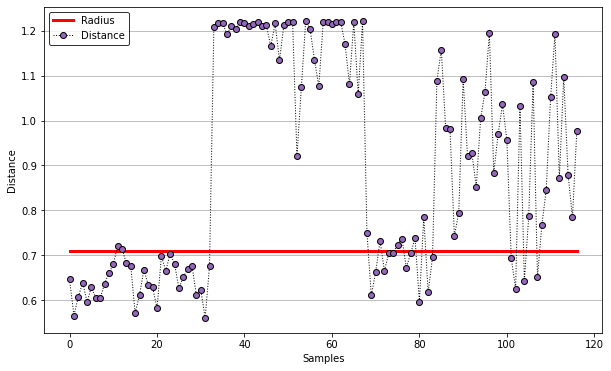

Epoch 1/3
3/3 [==============================] - 58s 21s/step - loss: 1.5470 - accuracy: 0.3200 - val_loss: 1.5067 - val_accuracy: 0.3261
Epoch 2/3
3/3 [==============================] - 44s 19s/step - loss: 1.5469 - accuracy: 0.3386 - val_loss: 1.5068 - val_accuracy: 0.3303
Epoch 3/3
3/3 [==============================] - 44s 20s/step - loss: 1.5471 - accuracy: 0.3574 - val_loss: 1.5072 - val_accuracy: 0.3336


*** Fitting of the SVDD model is completed. ***

running time         = 2.2026 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7065
number of samples    = 230
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 6.5217 %
accuracy             = 99.1304 %




*** Prediction of the provided data is completed. ***

running time         = 0.3593 seconds
number of samples    = 33
number of alarm      = 1
accuracy             = 96.9697 %




*** Prediction of the provided data is completed. ***

running time         = 0.92

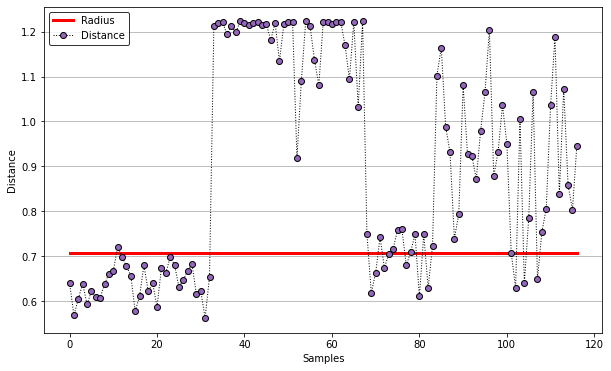

Epoch 1/2
2/2 [==============================] - 43s 37s/step - loss: 1.5329 - accuracy: 0.3511 - val_loss: 1.5120 - val_accuracy: 0.3384
Epoch 2/2
2/2 [==============================] - 43s 38s/step - loss: 1.5339 - accuracy: 0.3611 - val_loss: 1.5132 - val_accuracy: 0.3446


*** Fitting of the SVDD model is completed. ***

running time         = 2.1401 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6918
number of samples    = 230
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 6.5217 %
accuracy             = 99.1304 %




*** Prediction of the provided data is completed. ***

running time         = 0.8904 seconds
number of samples    = 84
number of alarm      = 73
accuracy             = 86.9048 %




*** Prediction of the provided data is completed. ***

running time         = 0.4686 seconds
number of samples    = 33
number of alarm      = 3
accuracy             = 90.9091 %




*** Prediction of the provided data is

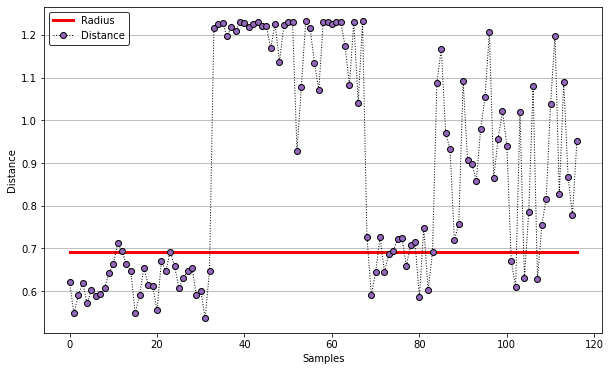

Epoch 1/3
3/3 [==============================] - 58s 21s/step - loss: 1.5373 - accuracy: 0.2810 - val_loss: 1.5078 - val_accuracy: 0.2933
Epoch 2/3
3/3 [==============================] - 46s 20s/step - loss: 1.5370 - accuracy: 0.2938 - val_loss: 1.5078 - val_accuracy: 0.3045
Epoch 3/3
3/3 [==============================] - 45s 20s/step - loss: 1.5370 - accuracy: 0.3054 - val_loss: 1.5080 - val_accuracy: 0.3149


*** Fitting of the SVDD model is completed. ***

running time         = 2.1089 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7273
number of samples    = 230
number of features   = 90112
number of SVs        = 16
ratio of SVs         = 6.9565 %
accuracy             = 98.6957 %




*** Prediction of the provided data is completed. ***

running time         = 0.3593 seconds
number of samples    = 33
number of alarm      = 1
accuracy             = 96.9697 %




*** Prediction of the provided data is completed. ***

running time         = 0.89

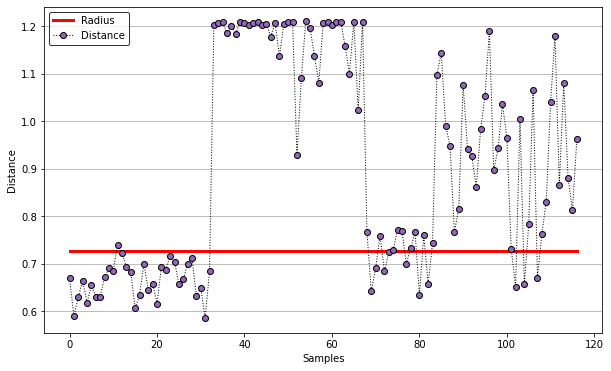

Epoch 1/2
2/2 [==============================] - 43s 38s/step - loss: 1.5239 - accuracy: 0.3195 - val_loss: 1.5112 - val_accuracy: 0.3211
Epoch 2/2
2/2 [==============================] - 43s 38s/step - loss: 1.5242 - accuracy: 0.3232 - val_loss: 1.5119 - val_accuracy: 0.3253


*** Fitting of the SVDD model is completed. ***

running time         = 2.1714 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.7240
number of samples    = 230
number of features   = 90112
number of SVs        = 16
ratio of SVs         = 6.9565 %
accuracy             = 99.1304 %




*** Prediction of the provided data is completed. ***

running time         = 0.9685 seconds
number of samples    = 84
number of alarm      = 71
accuracy             = 84.5238 %




*** Prediction of the provided data is completed. ***

running time         = 0.4218 seconds
number of samples    = 33
number of alarm      = 3
accuracy             = 90.9091 %




*** Prediction of the provided data is

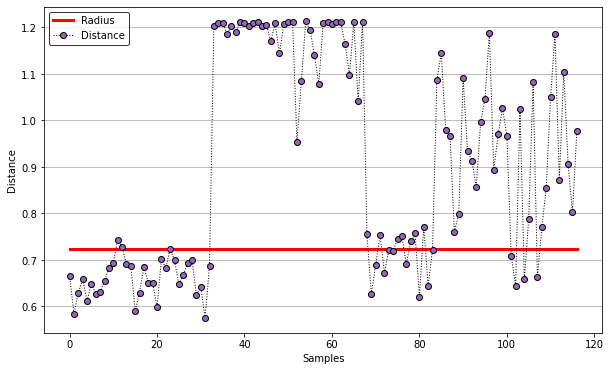

Epoch 1/3
3/3 [==============================] - 57s 21s/step - loss: 1.5135 - accuracy: 0.2339 - val_loss: 1.5126 - val_accuracy: 0.2505
Epoch 2/3
3/3 [==============================] - 44s 20s/step - loss: 1.5142 - accuracy: 0.2328 - val_loss: 1.5147 - val_accuracy: 0.2485
Epoch 3/3
3/3 [==============================] - 44s 20s/step - loss: 1.5170 - accuracy: 0.2318 - val_loss: 1.5205 - val_accuracy: 0.2461


*** Fitting of the SVDD model is completed. ***

running time         = 2.2495 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6818
number of samples    = 230
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.3913 %
accuracy             = 99.1304 %




*** Prediction of the provided data is completed. ***

running time         = 0.3749 seconds
number of samples    = 33
number of alarm      = 1
accuracy             = 96.9697 %




*** Prediction of the provided data is completed. ***

running time         = 0.90

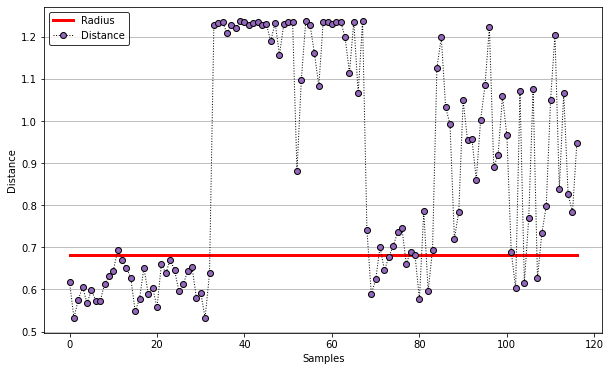

Epoch 1/2
3/3 [==============================] - 44s 20s/step - loss: 1.5403 - accuracy: 0.2599 - val_loss: 1.5321 - val_accuracy: 0.2427
Epoch 2/2
3/3 [==============================] - 45s 20s/step - loss: 1.5614 - accuracy: 0.2572 - val_loss: 1.5484 - val_accuracy: 0.2418


*** Fitting of the SVDD model is completed. ***

running time         = 2.1245 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6548
number of samples    = 230
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.3913 %
accuracy             = 98.6957 %




*** Prediction of the provided data is completed. ***

running time         = 0.9529 seconds
number of samples    = 84
number of alarm      = 71
accuracy             = 84.5238 %




*** Prediction of the provided data is completed. ***

running time         = 0.4843 seconds
number of samples    = 33
number of alarm      = 2
accuracy             = 93.9394 %




*** Prediction of the provided data is

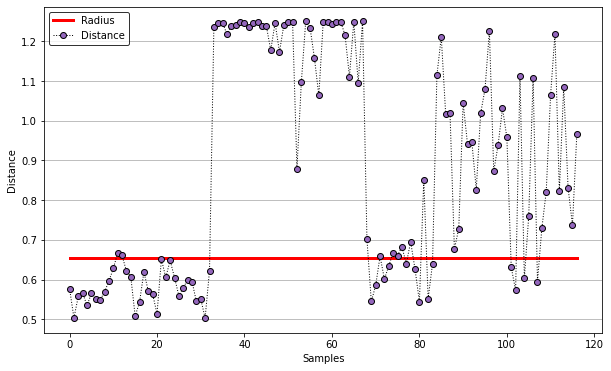

Epoch 1/3
3/3 [==============================] - 55s 21s/step - loss: 1.5231 - accuracy: 0.1237 - val_loss: 1.5110 - val_accuracy: 0.1296
Epoch 2/3
3/3 [==============================] - 44s 20s/step - loss: 1.5234 - accuracy: 0.1416 - val_loss: 1.5124 - val_accuracy: 0.1571
Epoch 3/3
3/3 [==============================] - 44s 20s/step - loss: 1.5259 - accuracy: 0.1609 - val_loss: 1.5159 - val_accuracy: 0.1846


*** Fitting of the SVDD model is completed. ***

running time         = 2.1557 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6942
number of samples    = 230
number of features   = 90112
number of SVs        = 16
ratio of SVs         = 6.9565 %
accuracy             = 99.1304 %




*** Prediction of the provided data is completed. ***

running time         = 0.4062 seconds
number of samples    = 33
number of alarm      = 1
accuracy             = 96.9697 %




*** Prediction of the provided data is completed. ***

running time         = 0.92

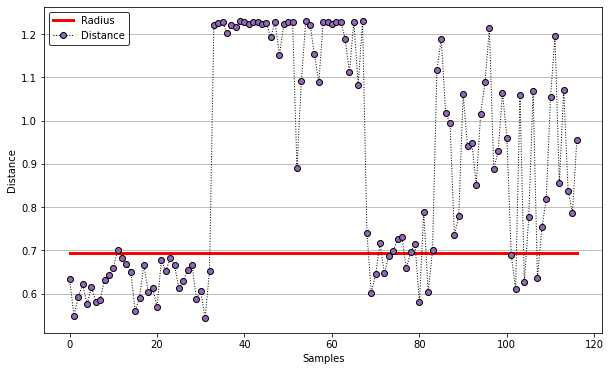

Epoch 1/2
2/2 [==============================] - 43s 38s/step - loss: 1.5285 - accuracy: 0.1808 - val_loss: 1.5212 - val_accuracy: 0.1998
Epoch 2/2
2/2 [==============================] - 43s 38s/step - loss: 1.5367 - accuracy: 0.1959 - val_loss: 1.5269 - val_accuracy: 0.2143


*** Fitting of the SVDD model is completed. ***

running time         = 2.7181 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.6701
number of samples    = 230
number of features   = 90112
number of SVs        = 16
ratio of SVs         = 6.9565 %
accuracy             = 98.6957 %




*** Prediction of the provided data is completed. ***

running time         = 1.0466 seconds
number of samples    = 84
number of alarm      = 71
accuracy             = 84.5238 %




*** Prediction of the provided data is completed. ***

running time         = 0.5468 seconds
number of samples    = 33
number of alarm      = 1
accuracy             = 96.9697 %




*** Prediction of the provided data is

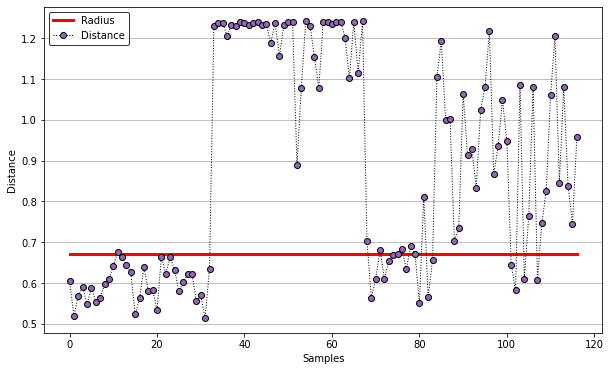

Wall time: 28min 17s


In [26]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
1/1 [==============================] - 23s 23s/step - loss: 0.6691 - accuracy: 0.4044 - val_loss: 0.6334 - val_accuracy: 0.3949
Epoch 2/3
1/1 [==============================] - 12s 12s/step - loss: 0.6689 - accuracy: 0.3939 - val_loss: 0.6333 - val_accuracy: 0.3832
Epoch 3/3
1/1 [==============================] - 12s 12s/step - loss: 0.6688 - accuracy: 0.3815 - val_loss: 0.6333 - val_accuracy: 0.3709


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4843 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.9097
number of samples    = 60
number of features   = 90112
number of SVs        = 39
ratio of SVs         = 65.0000 %
accuracy             = 45.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0937 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1875 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.2499 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




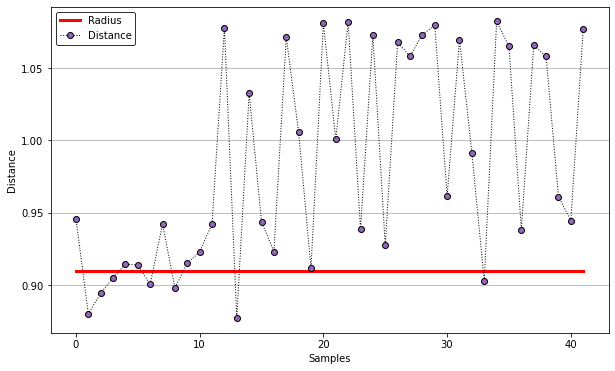

Epoch 1/2
5/5 [==============================] - 32s 7s/step - loss: 0.6337 - accuracy: 0.3488 - val_loss: 0.6371 - val_accuracy: 0.3169
Epoch 2/2
5/5 [==============================] - 32s 7s/step - loss: 0.6348 - accuracy: 0.3001 - val_loss: 0.6387 - val_accuracy: 0.2786


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4062 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9260
number of samples    = 60
number of features   = 90112
number of SVs        = 44
ratio of SVs         = 73.3333 %
accuracy             = 30.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 27
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2187 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 76.1905 %




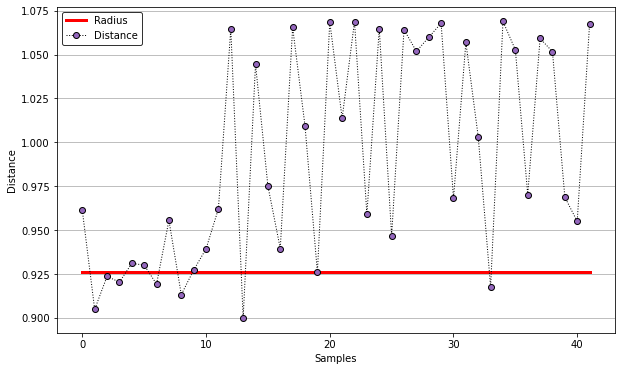

Epoch 1/3
1/1 [==============================] - 22s 22s/step - loss: 0.6350 - accuracy: 0.3645 - val_loss: 0.6371 - val_accuracy: 0.3583
Epoch 2/3
1/1 [==============================] - 12s 12s/step - loss: 0.6353 - accuracy: 0.3582 - val_loss: 0.6372 - val_accuracy: 0.3511
Epoch 3/3
1/1 [==============================] - 12s 12s/step - loss: 0.6355 - accuracy: 0.3491 - val_loss: 0.6374 - val_accuracy: 0.3424


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4999 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.9154
number of samples    = 60
number of features   = 90112
number of SVs        = 40
ratio of SVs         = 66.6667 %
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.2343 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




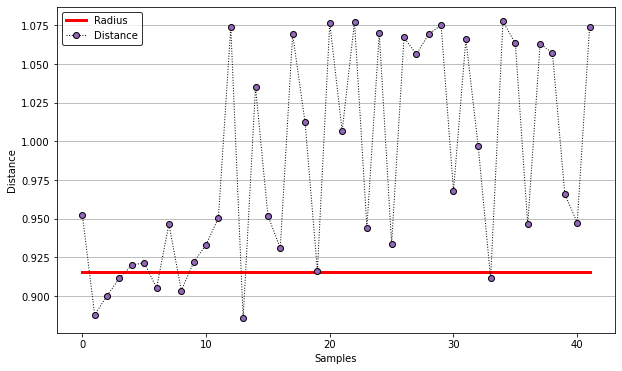

Epoch 1/2
5/5 [==============================] - 33s 7s/step - loss: 0.6375 - accuracy: 0.3202 - val_loss: 0.6410 - val_accuracy: 0.2980
Epoch 2/2
5/5 [==============================] - 33s 7s/step - loss: 0.6540 - accuracy: 0.2988 - val_loss: 0.6575 - val_accuracy: 0.2966


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.5155 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.9393
number of samples    = 60
number of features   = 90112
number of SVs        = 47
ratio of SVs         = 78.3333 %
accuracy             = 26.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2031 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 12
number of alarm      = 8
accuracy             = 33.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.2499 seconds
number of samples    = 42
number of alarm      = 36
accuracy             = 76.1905 %




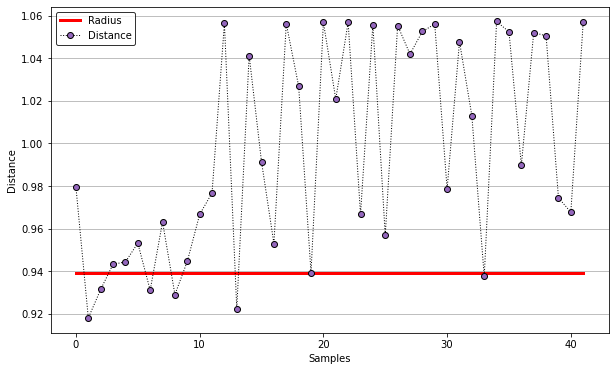

Epoch 1/3
1/1 [==============================] - 22s 22s/step - loss: 0.6215 - accuracy: 0.4716 - val_loss: 0.6389 - val_accuracy: 0.4682
Epoch 2/3
1/1 [==============================] - 12s 12s/step - loss: 0.6210 - accuracy: 0.4643 - val_loss: 0.6386 - val_accuracy: 0.4586
Epoch 3/3
1/1 [==============================] - 12s 12s/step - loss: 0.6209 - accuracy: 0.4567 - val_loss: 0.6385 - val_accuracy: 0.4511


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4218 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9077
number of samples    = 60
number of features   = 90112
number of SVs        = 35
ratio of SVs         = 58.3333 %
accuracy             = 46.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 27
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2187 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 76.1905 %




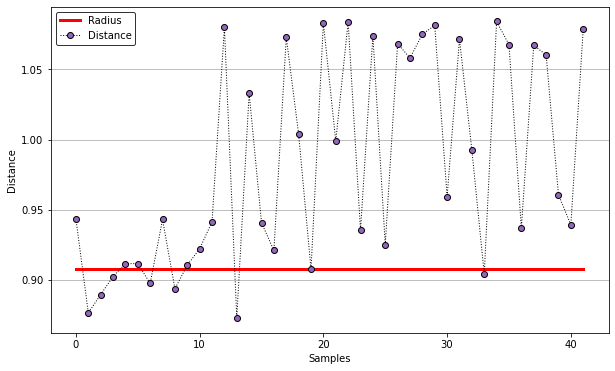

Epoch 1/2
5/5 [==============================] - 30s 6s/step - loss: 0.6319 - accuracy: 0.4408 - val_loss: 0.6366 - val_accuracy: 0.4376
Epoch 2/2
5/5 [==============================] - 30s 6s/step - loss: 0.6324 - accuracy: 0.4336 - val_loss: 0.6379 - val_accuracy: 0.4337


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4999 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9210
number of samples    = 60
number of features   = 90112
number of SVs        = 40
ratio of SVs         = 66.6667 %
accuracy             = 36.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 27
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2656 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 76.1905 %




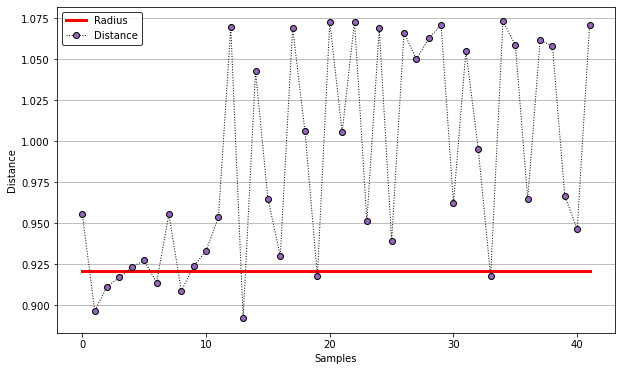

Epoch 1/3
1/1 [==============================] - 22s 22s/step - loss: 0.6554 - accuracy: 0.2397 - val_loss: 0.6350 - val_accuracy: 0.2075
Epoch 2/3
1/1 [==============================] - 11s 11s/step - loss: 0.6550 - accuracy: 0.2405 - val_loss: 0.6347 - val_accuracy: 0.2058
Epoch 3/3
1/1 [==============================] - 11s 11s/step - loss: 0.6546 - accuracy: 0.2416 - val_loss: 0.6346 - val_accuracy: 0.2040


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.5311 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9076
number of samples    = 60
number of features   = 90112
number of SVs        = 35
ratio of SVs         = 58.3333 %
accuracy             = 45.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.2499 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




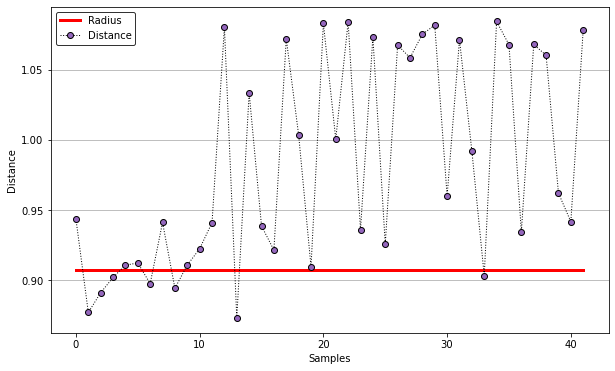

Epoch 1/2
5/5 [==============================] - 30s 6s/step - loss: 0.6315 - accuracy: 0.2043 - val_loss: 0.6370 - val_accuracy: 0.2024
Epoch 2/2
5/5 [==============================] - 30s 6s/step - loss: 0.6325 - accuracy: 0.2020 - val_loss: 0.6395 - val_accuracy: 0.1934


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4218 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9175
number of samples    = 60
number of features   = 90112
number of SVs        = 37
ratio of SVs         = 61.6667 %
accuracy             = 43.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2187 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




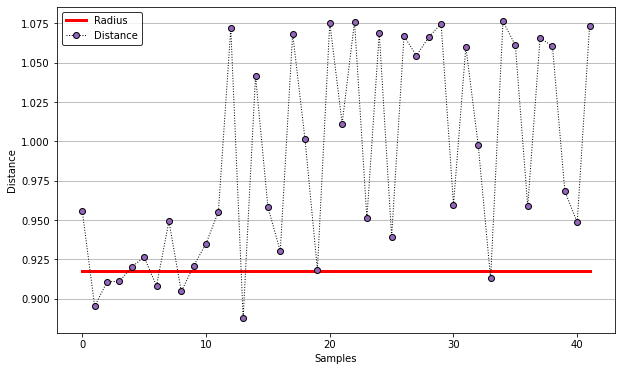

Epoch 1/3
1/1 [==============================] - 22s 22s/step - loss: 0.6077 - accuracy: 0.2383 - val_loss: 0.6398 - val_accuracy: 0.2514
Epoch 2/3
1/1 [==============================] - 11s 11s/step - loss: 0.6074 - accuracy: 0.2491 - val_loss: 0.6397 - val_accuracy: 0.2567
Epoch 3/3
1/1 [==============================] - 11s 11s/step - loss: 0.6072 - accuracy: 0.2597 - val_loss: 0.6397 - val_accuracy: 0.2617


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4374 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9097
number of samples    = 60
number of features   = 90112
number of SVs        = 35
ratio of SVs         = 58.3333 %
accuracy             = 45.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1562 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.2343 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




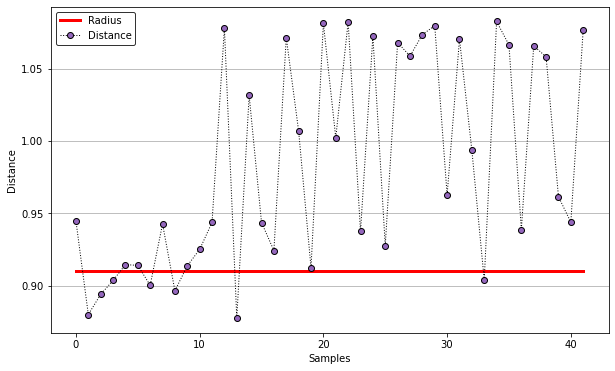

Epoch 1/2
5/5 [==============================] - 30s 6s/step - loss: 0.6316 - accuracy: 0.2677 - val_loss: 0.6365 - val_accuracy: 0.2681
Epoch 2/2
5/5 [==============================] - 30s 6s/step - loss: 0.6318 - accuracy: 0.2747 - val_loss: 0.6373 - val_accuracy: 0.2673


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4062 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9174
number of samples    = 60
number of features   = 90112
number of SVs        = 38
ratio of SVs         = 63.3333 %
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1562 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 12
number of alarm      = 6
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2343 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 80.9524 %




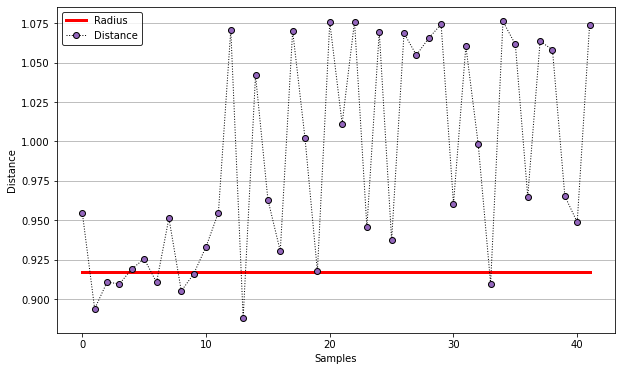

Wall time: 12min 4s


In [27]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
3/3 [==============================] - 52s 19s/step - loss: 1.0109 - accuracy: 0.0886 - val_loss: 0.9956 - val_accuracy: 0.1503
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 1.0085 - accuracy: 0.1881 - val_loss: 0.9941 - val_accuracy: 0.3033
Epoch 3/3
3/3 [==============================] - 40s 18s/step - loss: 1.0068 - accuracy: 0.3610 - val_loss: 0.9927 - val_accuracy: 0.5182


*** Fitting of the SVDD model is completed. ***

running time         = 1.9995 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.5681
number of samples    = 213
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.9812 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.5936 seconds
number of samples    = 60
number of alarm      = 3
accuracy             = 95.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.45

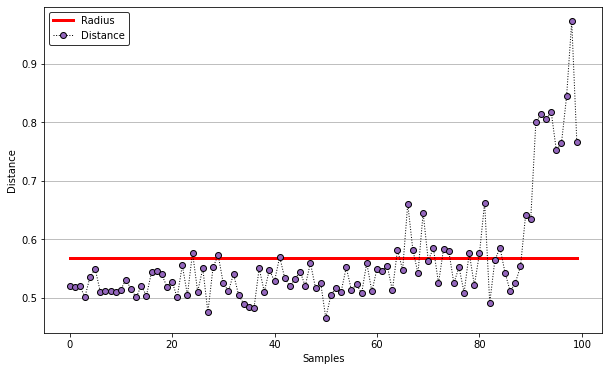

Epoch 1/2
3/3 [==============================] - 42s 19s/step - loss: 0.9884 - accuracy: 0.5569 - val_loss: 0.9926 - val_accuracy: 0.7212
Epoch 2/2
3/3 [==============================] - 41s 18s/step - loss: 0.9865 - accuracy: 0.7442 - val_loss: 0.9911 - val_accuracy: 0.8560


*** Fitting of the SVDD model is completed. ***

running time         = 2.1245 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.5723
number of samples    = 213
number of features   = 90112
number of SVs        = 15
ratio of SVs         = 7.0423 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.4374 seconds
number of samples    = 40
number of alarm      = 19
accuracy             = 47.5000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7186 seconds
number of samples    = 60
number of alarm      = 2
accuracy             = 96.6667 %




*** Prediction of the provided data is

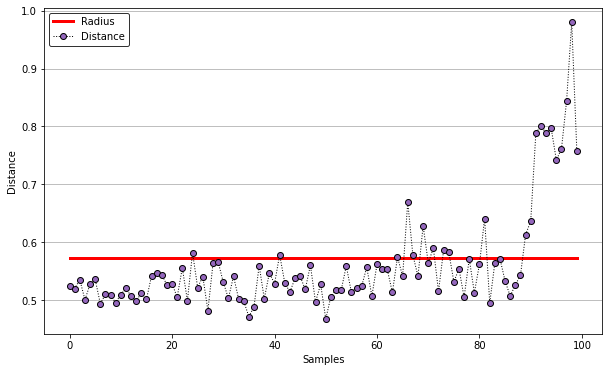

Epoch 1/3
3/3 [==============================] - 53s 19s/step - loss: 1.0001 - accuracy: 0.5223 - val_loss: 0.9915 - val_accuracy: 0.6767
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 0.9978 - accuracy: 0.7303 - val_loss: 0.9894 - val_accuracy: 0.8404
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.9951 - accuracy: 0.8672 - val_loss: 0.9874 - val_accuracy: 0.9205


*** Fitting of the SVDD model is completed. ***

running time         = 2.0776 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.5943
number of samples    = 213
number of features   = 90112
number of SVs        = 18
ratio of SVs         = 8.4507 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.7342 seconds
number of samples    = 60
number of alarm      = 4
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.49

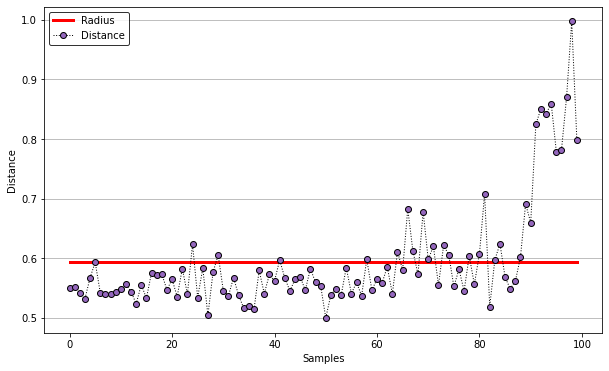

Epoch 1/2
3/3 [==============================] - 44s 19s/step - loss: 0.9784 - accuracy: 0.9285 - val_loss: 0.9869 - val_accuracy: 0.9495
Epoch 2/2
3/3 [==============================] - 41s 18s/step - loss: 0.9773 - accuracy: 0.9527 - val_loss: 0.9855 - val_accuracy: 0.9577


*** Fitting of the SVDD model is completed. ***

running time         = 2.0933 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.5983
number of samples    = 213
number of features   = 90112
number of SVs        = 12
ratio of SVs         = 5.6338 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.4374 seconds
number of samples    = 40
number of alarm      = 24
accuracy             = 60.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6873 seconds
number of samples    = 60
number of alarm      = 4
accuracy             = 93.3333 %




*** Prediction of the provided data is

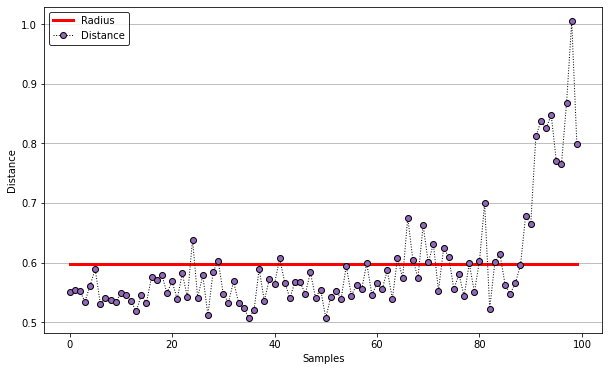

Epoch 1/3
3/3 [==============================] - 52s 19s/step - loss: 0.9799 - accuracy: 0.6241 - val_loss: 0.9933 - val_accuracy: 0.6992
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 0.9796 - accuracy: 0.6988 - val_loss: 0.9931 - val_accuracy: 0.7391
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.9813 - accuracy: 0.7317 - val_loss: 0.9942 - val_accuracy: 0.7515


*** Fitting of the SVDD model is completed. ***

running time         = 2.0464 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.6580
number of samples    = 213
number of features   = 90112
number of SVs        = 16
ratio of SVs         = 7.5117 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.6405 seconds
number of samples    = 60
number of alarm      = 7
accuracy             = 88.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.42

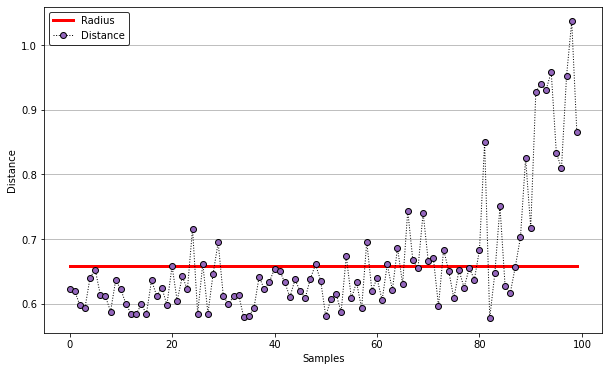

Epoch 1/2
2/2 [==============================] - 42s 37s/step - loss: 0.9893 - accuracy: 0.7442 - val_loss: 0.9951 - val_accuracy: 0.7480
Epoch 2/2
2/2 [==============================] - 40s 35s/step - loss: 0.9981 - accuracy: 0.7420 - val_loss: 0.9993 - val_accuracy: 0.7357


*** Fitting of the SVDD model is completed. ***

running time         = 2.2543 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.6906
number of samples    = 213
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.9812 %
accuracy             = 92.4883 %




*** Prediction of the provided data is completed. ***

running time         = 0.4686 seconds
number of samples    = 40
number of alarm      = 24
accuracy             = 60.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6561 seconds
number of samples    = 60
number of alarm      = 8
accuracy             = 86.6667 %




*** Prediction of the provided data is

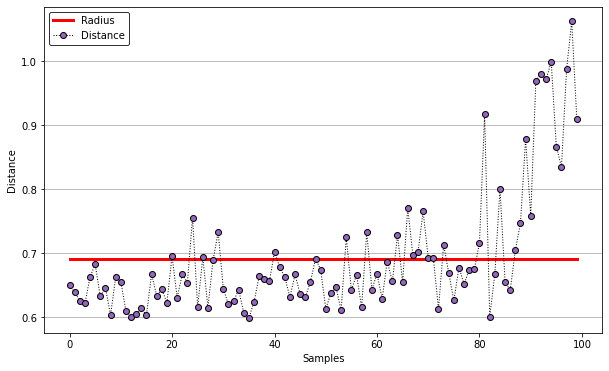

Epoch 1/3
3/3 [==============================] - 52s 19s/step - loss: 0.9917 - accuracy: 0.1827 - val_loss: 0.9960 - val_accuracy: 0.3141
Epoch 2/3
3/3 [==============================] - 42s 18s/step - loss: 0.9889 - accuracy: 0.3918 - val_loss: 0.9941 - val_accuracy: 0.5281
Epoch 3/3
3/3 [==============================] - 42s 18s/step - loss: 0.9873 - accuracy: 0.5950 - val_loss: 0.9927 - val_accuracy: 0.6782


*** Fitting of the SVDD model is completed. ***

running time         = 2.1089 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.6177
number of samples    = 213
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.9812 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.7342 seconds
number of samples    = 60
number of alarm      = 4
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.43

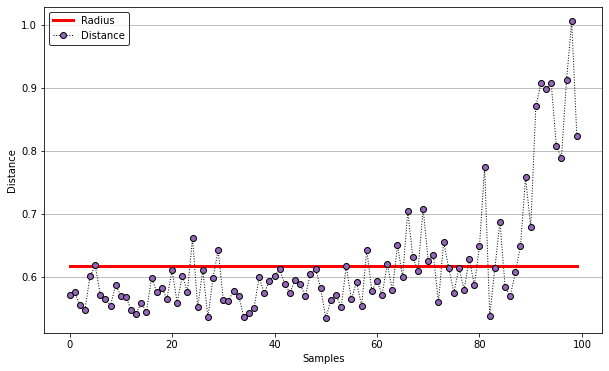

Epoch 1/2
3/3 [==============================] - 43s 19s/step - loss: 0.9870 - accuracy: 0.7017 - val_loss: 0.9919 - val_accuracy: 0.7587
Epoch 2/2
3/3 [==============================] - 41s 18s/step - loss: 0.9896 - accuracy: 0.7651 - val_loss: 0.9931 - val_accuracy: 0.7875


*** Fitting of the SVDD model is completed. ***

running time         = 2.0776 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.6647
number of samples    = 213
number of features   = 90112
number of SVs        = 18
ratio of SVs         = 8.4507 %
accuracy             = 92.9577 %




*** Prediction of the provided data is completed. ***

running time         = 0.5624 seconds
number of samples    = 40
number of alarm      = 24
accuracy             = 60.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6405 seconds
number of samples    = 60
number of alarm      = 7
accuracy             = 88.3333 %




*** Prediction of the provided data is

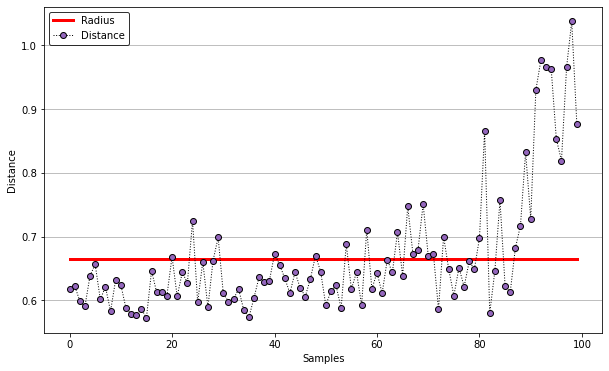

Epoch 1/3
3/3 [==============================] - 54s 19s/step - loss: 0.9880 - accuracy: 0.2746 - val_loss: 0.9954 - val_accuracy: 0.4053
Epoch 2/3
3/3 [==============================] - 41s 18s/step - loss: 0.9864 - accuracy: 0.4584 - val_loss: 0.9944 - val_accuracy: 0.5555
Epoch 3/3
3/3 [==============================] - 41s 18s/step - loss: 0.9872 - accuracy: 0.5896 - val_loss: 0.9946 - val_accuracy: 0.6486


*** Fitting of the SVDD model is completed. ***

running time         = 2.1401 seconds
kernel function      = rbf
iterations           = 12
radius               = 0.6447
number of samples    = 213
number of features   = 90112
number of SVs        = 12
ratio of SVs         = 5.6338 %
accuracy             = 99.5305 %




*** Prediction of the provided data is completed. ***

running time         = 0.7030 seconds
number of samples    = 60
number of alarm      = 4
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.45

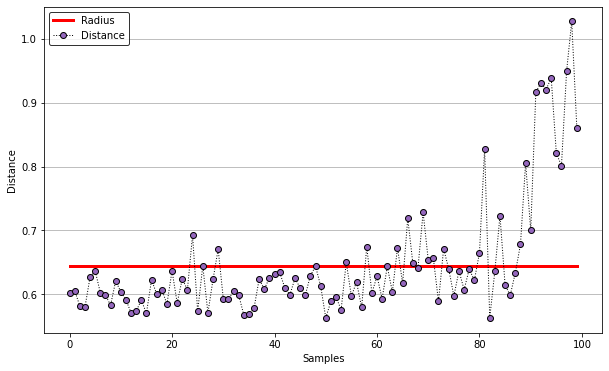

Epoch 1/2
2/2 [==============================] - 40s 35s/step - loss: 1.0006 - accuracy: 0.6602 - val_loss: 0.9951 - val_accuracy: 0.6830
Epoch 2/2
2/2 [==============================] - 38s 33s/step - loss: 1.0075 - accuracy: 0.6918 - val_loss: 0.9983 - val_accuracy: 0.6972


*** Fitting of the SVDD model is completed. ***

running time         = 2.0620 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.6773
number of samples    = 213
number of features   = 90112
number of SVs        = 17
ratio of SVs         = 7.9812 %
accuracy             = 93.4272 %




*** Prediction of the provided data is completed. ***

running time         = 0.4530 seconds
number of samples    = 40
number of alarm      = 24
accuracy             = 60.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.7030 seconds
number of samples    = 60
number of alarm      = 6
accuracy             = 90.0000 %




*** Prediction of the provided data is

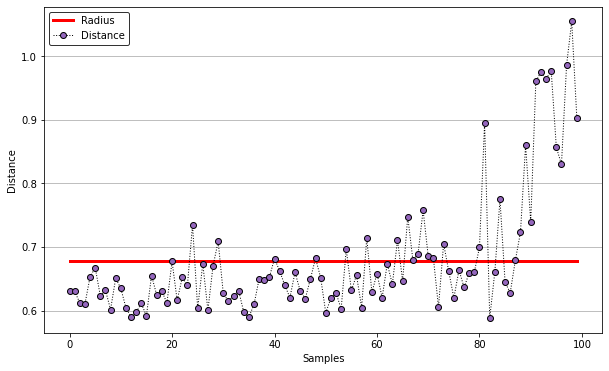

Wall time: 26min 10s


In [28]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-5), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [29]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-5), gamma=10**(-5), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-5), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

SyntaxError: invalid syntax (<unknown>, line 86)

Epoch 1/3
3/3 [==============================] - 68s 24s/step - loss: 1.3291 - accuracy: 0.0706 - val_loss: 1.3235 - val_accuracy: 0.0848
Epoch 2/3
3/3 [==============================] - 48s 22s/step - loss: 1.3298 - accuracy: 0.0975 - val_loss: 1.3238 - val_accuracy: 0.1001
Epoch 3/3
3/3 [==============================] - 47s 21s/step - loss: 1.3339 - accuracy: 0.1108 - val_loss: 1.3250 - val_accuracy: 0.1099


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.5421 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0083
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 64.5833 %




*** Prediction of the provided data is completed. ***

running time         = 0.3988 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.4366 seconds
number of samples    = 119
number of alarm      = 106
accuracy             = 89.0756 %




*** Prediction of the provided data is completed. ***

running time         = 1.5357 seconds
number of samples    = 151
number of alarm      = 116
accuracy             = 84.7682 %




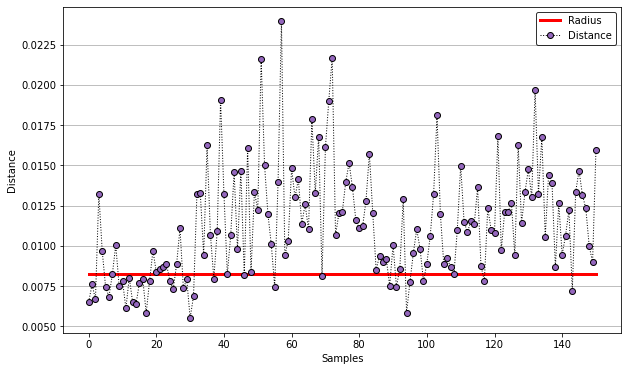

Epoch 1/2
30/30 [==============================] - 190s 6s/step - loss: 1.6498 - accuracy: 0.2007 - val_loss: 1.9665 - val_accuracy: 0.2004
Epoch 2/2
30/30 [==============================] - 207s 7s/step - loss: 5.7395 - accuracy: 0.1913 - val_loss: 16.4168 - val_accuracy: 0.2280


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.5741 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0130
number of samples    = 240
number of features   = 90112
number of SVs        = 151
ratio of SVs         = 62.9167 %
accuracy             = 78.3333 %




*** Prediction of the provided data is completed. ***

running time         = 1.2698 seconds
number of samples    = 119
number of alarm      = 101
accuracy             = 84.8739 %




*** Prediction of the provided data is completed. ***

running time         = 0.4915 seconds
number of samples    = 32
number of alarm      = 11
accuracy             = 65.6250 %




*** Prediction of the provided data is completed. ***

running time         = 1.4399 seconds
number of samples    = 151
number of alarm      = 112
accuracy             = 80.7947 %




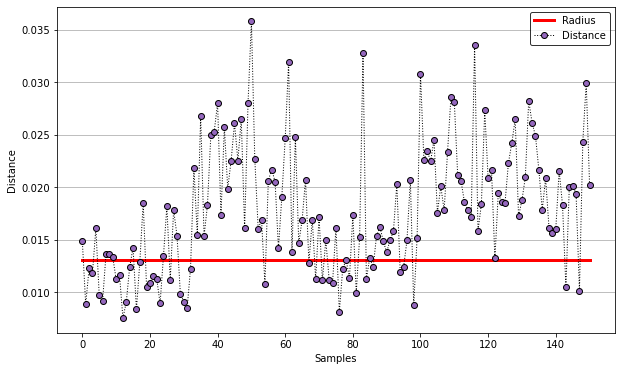

Epoch 1/3
3/3 [==============================] - 71s 26s/step - loss: 1.3220 - accuracy: 0.2869 - val_loss: 1.3241 - val_accuracy: 0.2761
Epoch 2/3
3/3 [==============================] - 49s 22s/step - loss: 1.3230 - accuracy: 0.2633 - val_loss: 1.3245 - val_accuracy: 0.2479
Epoch 3/3
3/3 [==============================] - 50s 23s/step - loss: 1.3281 - accuracy: 0.2326 - val_loss: 1.3258 - val_accuracy: 0.2154


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4939 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.0088
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 65.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.4516 seconds
number of samples    = 32
number of alarm      = 13
accuracy             = 59.3750 %




*** Prediction of the provided data is completed. ***

running time         = 1.3768 seconds
number of samples    = 119
number of alarm      = 109
accuracy             = 91.5966 %




*** Prediction of the provided data is completed. ***

running time         = 1.4689 seconds
number of samples    = 151
number of alarm      = 122
accuracy             = 84.7682 %




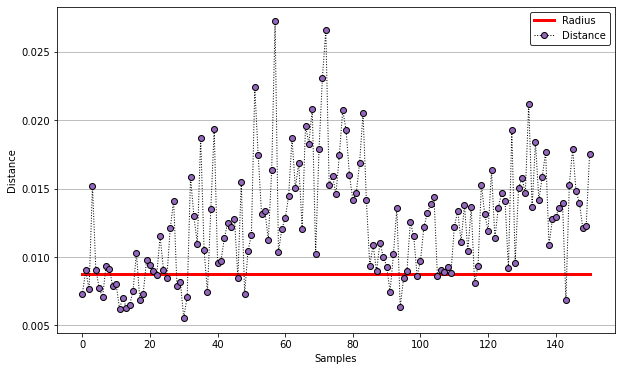

Epoch 1/2
30/30 [==============================] - 191s 6s/step - loss: 2.7537 - accuracy: 0.1511 - val_loss: 2.0123 - val_accuracy: 0.1685
Epoch 2/2
30/30 [==============================] - 184s 6s/step - loss: 26.5440 - accuracy: 0.1837 - val_loss: 9.6788 - val_accuracy: 0.2010


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4918 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0138
number of samples    = 240
number of features   = 90112
number of SVs        = 208
ratio of SVs         = 86.6667 %
accuracy             = 81.6667 %




*** Prediction of the provided data is completed. ***

running time         = 1.2422 seconds
number of samples    = 119
number of alarm      = 42
accuracy             = 35.2941 %




*** Prediction of the provided data is completed. ***

running time         = 0.4859 seconds
number of samples    = 32
number of alarm      = 5
accuracy             = 84.3750 %




*** Prediction of the provided data is completed. ***

running time         = 1.4272 seconds
number of samples    = 151
number of alarm      = 47
accuracy             = 45.6954 %




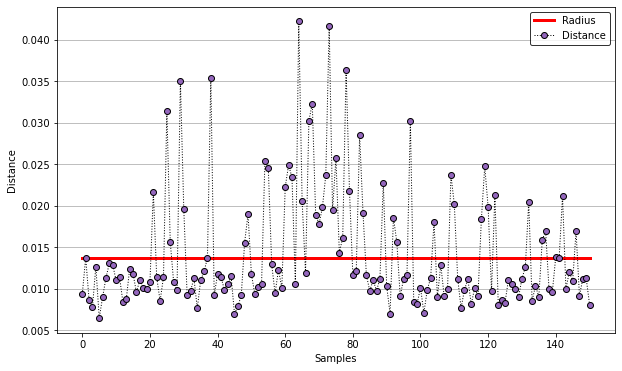

Epoch 1/3
3/3 [==============================] - 60s 23s/step - loss: 1.3216 - accuracy: 0.0238 - val_loss: 1.3249 - val_accuracy: 0.0313
Epoch 2/3
3/3 [==============================] - 47s 21s/step - loss: 1.3235 - accuracy: 0.0296 - val_loss: 1.3258 - val_accuracy: 0.0333
Epoch 3/3
3/3 [==============================] - 47s 21s/step - loss: 1.3349 - accuracy: 0.0309 - val_loss: 1.3287 - val_accuracy: 0.0335


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.5585 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0086
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 65.8333 %




*** Prediction of the provided data is completed. ***

running time         = 0.4084 seconds
number of samples    = 32
number of alarm      = 13
accuracy             = 59.3750 %




*** Prediction of the provided data is completed. ***

running time         = 1.2398 seconds
number of samples    = 119
number of alarm      = 108
accuracy             = 90.7563 %




*** Prediction of the provided data is completed. ***

running time         = 1.5536 seconds
number of samples    = 151
number of alarm      = 121
accuracy             = 84.1060 %




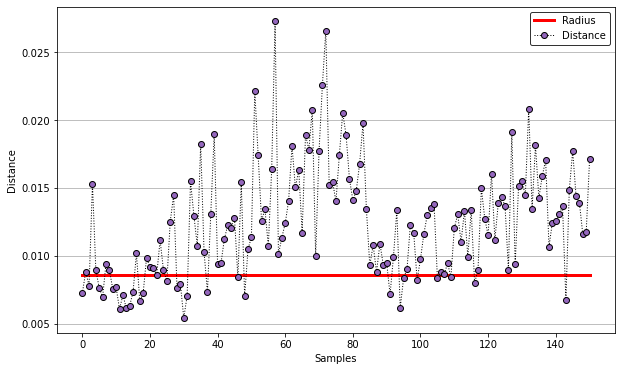

Epoch 1/2
30/30 [==============================] - 188s 6s/step - loss: 3.4358 - accuracy: 0.1013 - val_loss: 2.7077 - val_accuracy: 0.1308
Epoch 2/2
30/30 [==============================] - 181s 6s/step - loss: 32.0622 - accuracy: 0.2535 - val_loss: 16.4261 - val_accuracy: 0.2259


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4786 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.0151
number of samples    = 240
number of features   = 90112
number of SVs        = 197
ratio of SVs         = 82.0833 %
accuracy             = 75.8333 %




*** Prediction of the provided data is completed. ***

running time         = 1.2859 seconds
number of samples    = 119
number of alarm      = 44
accuracy             = 36.9748 %




*** Prediction of the provided data is completed. ***

running time         = 0.4244 seconds
number of samples    = 32
number of alarm      = 8
accuracy             = 75.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.4805 seconds
number of samples    = 151
number of alarm      = 52
accuracy             = 45.0331 %




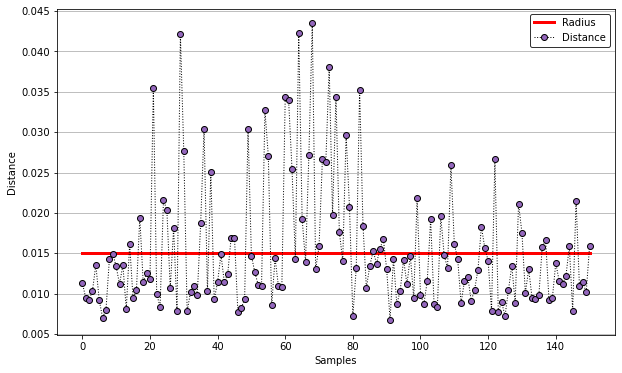

Epoch 1/3
3/3 [==============================] - 60s 23s/step - loss: 1.3203 - accuracy: 0.3988 - val_loss: 1.3249 - val_accuracy: 0.4154
Epoch 2/3
3/3 [==============================] - 47s 21s/step - loss: 1.3207 - accuracy: 0.4147 - val_loss: 1.3251 - val_accuracy: 0.4304
Epoch 3/3
3/3 [==============================] - 47s 21s/step - loss: 1.3241 - accuracy: 0.4281 - val_loss: 1.3261 - val_accuracy: 0.4393


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4737 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0086
number of samples    = 240
number of features   = 90112
number of SVs        = 233
ratio of SVs         = 97.0833 %
accuracy             = 68.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.4712 seconds
number of samples    = 32
number of alarm      = 13
accuracy             = 59.3750 %




*** Prediction of the provided data is completed. ***

running time         = 1.2179 seconds
number of samples    = 119
number of alarm      = 107
accuracy             = 89.9160 %




*** Prediction of the provided data is completed. ***

running time         = 1.4837 seconds
number of samples    = 151
number of alarm      = 120
accuracy             = 83.4437 %




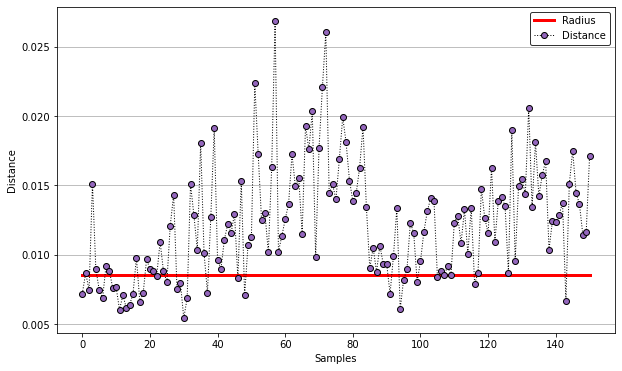

Epoch 1/2
30/30 [==============================] - 189s 6s/step - loss: 2.3819 - accuracy: 0.4458 - val_loss: 1.9491 - val_accuracy: 0.4269
Epoch 2/2
30/30 [==============================] - 179s 6s/step - loss: 20.3503 - accuracy: 0.3958 - val_loss: 6.9582 - val_accuracy: 0.3939


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.5424 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.0097
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 72.9167 %




*** Prediction of the provided data is completed. ***

running time         = 1.2132 seconds
number of samples    = 119
number of alarm      = 64
accuracy             = 53.7815 %




*** Prediction of the provided data is completed. ***

running time         = 0.3736 seconds
number of samples    = 32
number of alarm      = 16
accuracy             = 50.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.5236 seconds
number of samples    = 151
number of alarm      = 80
accuracy             = 52.9801 %




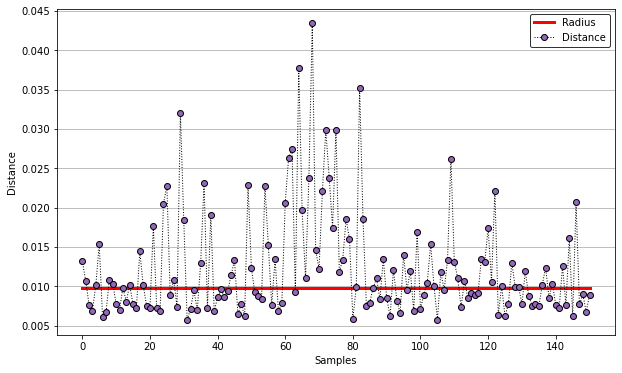

Epoch 1/3
3/3 [==============================] - 61s 23s/step - loss: 1.3192 - accuracy: 0.1996 - val_loss: 1.3245 - val_accuracy: 0.2314
Epoch 2/3
3/3 [==============================] - 47s 21s/step - loss: 1.3204 - accuracy: 0.2666 - val_loss: 1.3253 - val_accuracy: 0.3080
Epoch 3/3
3/3 [==============================] - 47s 21s/step - loss: 1.3288 - accuracy: 0.3293 - val_loss: 1.3277 - val_accuracy: 0.3805


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4777 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0088
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 67.5000 %




*** Prediction of the provided data is completed. ***

running time         = 0.4444 seconds
number of samples    = 32
number of alarm      = 13
accuracy             = 59.3750 %




*** Prediction of the provided data is completed. ***

running time         = 1.2315 seconds
number of samples    = 119
number of alarm      = 108
accuracy             = 90.7563 %




*** Prediction of the provided data is completed. ***

running time         = 1.4210 seconds
number of samples    = 151
number of alarm      = 121
accuracy             = 84.1060 %




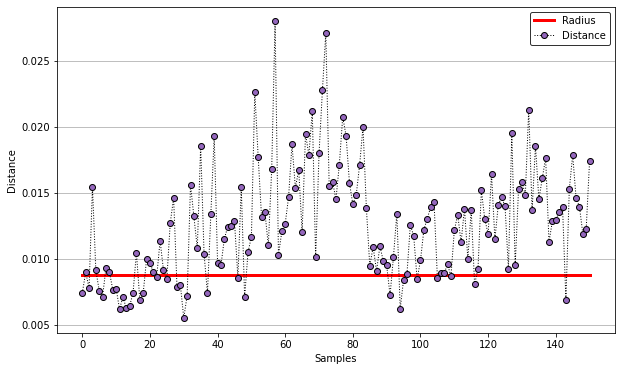

Epoch 1/2
30/30 [==============================] - 187s 6s/step - loss: 3.0603 - accuracy: 0.4709 - val_loss: 2.3544 - val_accuracy: 0.4191
Epoch 2/2
30/30 [==============================] - 181s 6s/step - loss: 19.6555 - accuracy: 0.2707 - val_loss: 5.4643 - val_accuracy: 0.1757


C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4791 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.0141
number of samples    = 240
number of features   = 90112
number of SVs        = 165
ratio of SVs         = 68.7500 %
accuracy             = 79.1667 %




*** Prediction of the provided data is completed. ***

running time         = 1.2568 seconds
number of samples    = 119
number of alarm      = 38
accuracy             = 31.9328 %




*** Prediction of the provided data is completed. ***

running time         = 0.3924 seconds
number of samples    = 32
number of alarm      = 4
accuracy             = 87.5000 %




*** Prediction of the provided data is completed. ***

running time         = 1.4935 seconds
number of samples    = 151
number of alarm      = 42
accuracy             = 43.7086 %




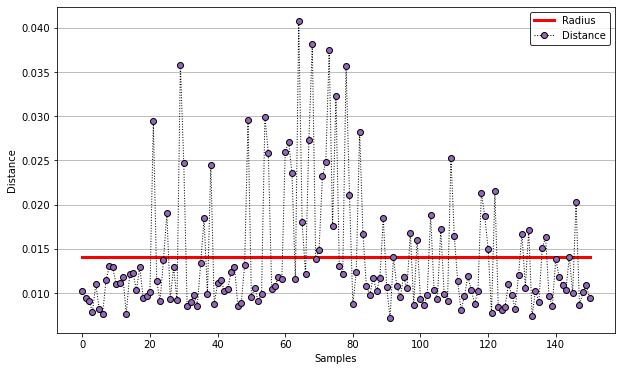

Wall time: 55min 12s


In [30]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
#     X_train_k1, X_test_k1 = train_test_split(X_train, test_size=0.2, random_state=4)


    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-7), gamma=10**(-8), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=8,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-7), gamma=10**(-8), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [2]:
a = acc

NameError: name 'acc' is not defined

In [1]:
# import pandas as pd
# acc=np.array(acc)
# a= a.reshape(65,3)
# a=a*100
# acc = acc/100
# print(acc)
# a.shape
df = pd.DataFrame(a)
print(df)
df.to_csv('output_pd.csv')

NameError: name 'a' is not defined